In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib notebook

In [4]:
%autosave 0

Autosave disabled


In [5]:
data=pd.read_csv('Downloads/combined.txt')

In [6]:
data.head()

Date    Open    High     Low   Close    Volume  OpenInt
0  1999-03-10  45.722  45.750  44.967  45.665  11700414        0
1  1999-03-11  45.994  46.260  44.988  45.880  21670048        0
2  1999-03-12  45.721  45.749  44.406  44.770  19553768        0
3  1999-03-15  45.101  46.103  44.625  46.052  14245348        0
4  1999-03-16  46.253  46.643  45.749  46.447  10971066        0

In [7]:
data['Average']=(data['Open']-data['Close'])/2

In [8]:
data.head()

Date    Open    High     Low   Close    Volume  OpenInt  Average
0  1999-03-10  45.722  45.750  44.967  45.665  11700414        0   0.0285
1  1999-03-11  45.994  46.260  44.988  45.880  21670048        0   0.0570
2  1999-03-12  45.721  45.749  44.406  44.770  19553768        0   0.4755
3  1999-03-15  45.101  46.103  44.625  46.052  14245348        0  -0.4755
4  1999-03-16  46.253  46.643  45.749  46.447  10971066        0  -0.0970

In [9]:
len(data['Average'])

20324

In [10]:
def observations():
    length=len(data['Average'])
    for i in range(0,length-3):
        yield np.array(data.iloc[i:i+4,-1])

In [11]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def relu(vector):
    vector[vector < 0] = 0
    return vector

def apply_neural_nets(observation_matrix, weights):
    """ Based on the observation_matrix and weights, compute the new hidden layer values and the new output layer values"""
    hidden_layer_values = np.dot(weights['1'], observation_matrix)
    hidden_layer_values = relu(hidden_layer_values)
    output_layer_values = np.dot(hidden_layer_values, weights['2'])
    output_layer_values = sigmoid(output_layer_values)
    return hidden_layer_values, output_layer_values


In [12]:
def choose_action(probability):
    random_value = np.random.uniform()
    if random_value < probability:
        return 1
    else:
        return 0

In [13]:
def compute_gradient(gradient_log_p, hidden_layer_values, observation_values, weights):
    delta_L = gradient_log_p
    dC_dw2 = np.dot(hidden_layer_values.T, delta_L).ravel()
    delta_l2 = np.outer(delta_L, weights['2'])
    delta_l2 = relu(delta_l2)
    print(delta_l2.shape)
    dC_dw1 = np.multiply(delta_l2.T, observation_values)
    return {
        '1': dC_dw1,
        '2': dC_dw2
    }

In [14]:
def update_weights(weights, expectation_g_squared, g_dict, decay_rate, learning_rate):
    epsilon = 1e-5
    for layer_name in weights.keys():
        g = g_dict[layer_name]
        expectation_g_squared[layer_name] = decay_rate * expectation_g_squared[layer_name] + (1 - decay_rate) * g**2
        weights[layer_name] += (learning_rate * g)/(np.sqrt(expectation_g_squared[layer_name] + epsilon))
        g_dict[layer_name] = np.zeros_like(weights[layer_name]) # reset batch gradient buffer

def discount_rewards(rewards, gamma):
    discounted_rewards = np.zeros_like(rewards).astype('float64')
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards

def discount_with_rewards(gradient_log_p, episode_rewards, gamma):
    """ discount the gradient with the normalized rewards """
    discounted_episode_rewards = discount_rewards(episode_rewards, gamma)
    discounted_episode_rewards -= (np.mean(discounted_episode_rewards)).astype('float64')
    discounted_episode_rewards /= np.std(discounted_episode_rewards)
    return gradient_log_p * discounted_episode_rewards


In [29]:
accuracy=[]
def main():
    # hyperparameters
    episode_number = 0
    batch_size = 10
    gamma = 0.99 # discount factor for reward
    decay_rate = 0.99
    num_hidden_layer_neurons = 200
    input_dimensions = 4
    learning_rate = 1e-4

    episode_number = 0
    reward_sum = 0
    running_reward = None

    weights = {
        '1': np.random.randn(num_hidden_layer_neurons, input_dimensions) / np.sqrt(input_dimensions),
        '2': np.random.randn(num_hidden_layer_neurons) / np.sqrt(num_hidden_layer_neurons)
    }

    expectation_g_squared = {}
    g_dict = {}
    for layer_name in weights.keys():
        expectation_g_squared[layer_name] = np.zeros_like(weights[layer_name])
        g_dict[layer_name] = np.zeros_like(weights[layer_name])

#     episode_hidden_layer_values, episode_observations, episode_gradient_log_ps, episode_rewards = [], [], [], []

    genobject=observations()
    
    for i in range(4,len(data['Average'])-1):
        processed_observations=next(genobject)
        hidden_layer_values, up_probability = apply_neural_nets(processed_observations, weights)
#         episode_observations.append(processed_observations)
#         episode_hidden_layer_values.append(hidden_layer_values)
        action = choose_action(up_probability)
        # carry out the chosen action

        if(data.iloc[i+1,-1]>data.iloc[i,-1] and action==1) or (data.iloc[i+1,-1]<data.iloc[i,-1] and action==0):
            reward=1
        else:
            reward=-1
        
        reward_sum += reward
#         episode_rewards.append(reward)

        fake_label = 1 if action == 1 else 0
        loss_function_gradient = fake_label - up_probability
#         episode_gradient_log_ps.append(loss_function_gradient)


#         if i%5==0:
        episode_number += 1

#             episode_hidden_layer_values = np.vstack(episode_hidden_layer_values)
#             episode_observations = np.vstack(episode_observations)
#             episode_gradient_log_ps = np.vstack(episode_gradient_log_ps)
#             episode_rewards = np.vstack(episode_rewards)

#             episode_gradient_log_ps_discounted = discount_with_rewards(episode_gradient_log_ps, episode_rewards, gamma)

        gradient = compute_gradient(
          loss_function_gradient,
          hidden_layer_values,
          processed_observations,
          weights
        )

            # Sum the gradient for use when we hit the batch size
        for layer_name in gradient:
            g_dict[layer_name] = gradient[layer_name]

#             if episode_number % batch_size == 0:
        update_weights(weights, expectation_g_squared, g_dict, decay_rate, learning_rate)
        print('*'*100)
#             print(weights)
        
#             episode_hidden_layer_values, episode_observations, episode_gradient_log_ps, episode_rewards = [], [], [], [] # reset values
#             running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
#             print ('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
#             reward_sum = 0
#             print(weights)
        temp=((reward_sum+episode_number)/2)/episode_number
        accuracy.append(temp)
        print(reward,reward_sum,episode_number,'Accuracy->',temp)
    return weights

(1, 200)
****************************************************************************************************
1 1 1 Accuracy-> 1.0


<IPython.core.display.Javascript object>


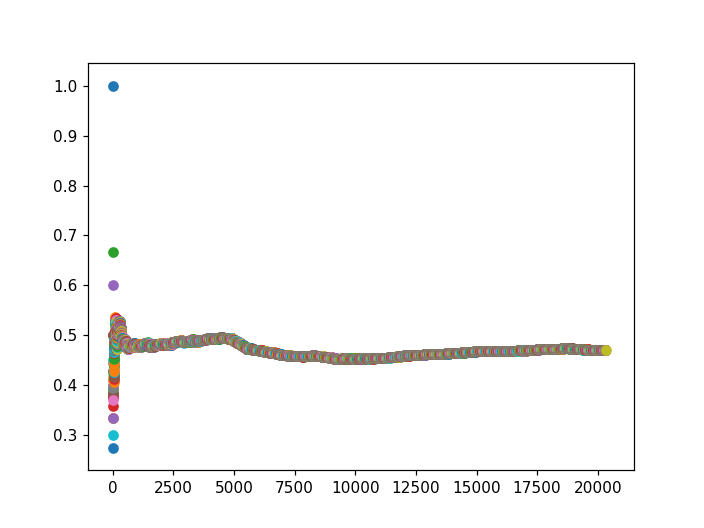

(1, 200)
****************************************************************************************************
-1 0 2 Accuracy-> 0.5
(1, 200)
****************************************************************************************************
1 1 3 Accuracy-> 0.6666666666666666
(1, 200)
****************************************************************************************************
-1 0 4 Accuracy-> 0.5
(1, 200)
****************************************************************************************************
1 1 5 Accuracy-> 0.6
(1, 200)
****************************************************************************************************
-1 0 6 Accuracy-> 0.5
(1, 200)
****************************************************************************************************
-1 -1 7 Accuracy-> 0.42857142857142855
(1, 200)
****************************************************************************************************
-1 -2 8 Accuracy-> 0.375
(1, 200)
**********************************

-1 -8 156 Accuracy-> 0.47435897435897434
(1, 200)
****************************************************************************************************
-1 -9 157 Accuracy-> 0.4713375796178344
(1, 200)
****************************************************************************************************
1 -8 158 Accuracy-> 0.47468354430379744
(1, 200)
****************************************************************************************************
-1 -9 159 Accuracy-> 0.4716981132075472
(1, 200)
****************************************************************************************************
1 -8 160 Accuracy-> 0.475
(1, 200)
****************************************************************************************************
1 -7 161 Accuracy-> 0.4782608695652174
(1, 200)
****************************************************************************************************
1 -6 162 Accuracy-> 0.48148148148148145
(1, 200)
*****************************************************************

****************************************************************************************************
-1 12 298 Accuracy-> 0.5201342281879194
(1, 200)
****************************************************************************************************
-1 11 299 Accuracy-> 0.5183946488294314
(1, 200)
****************************************************************************************************
-1 10 300 Accuracy-> 0.5166666666666667
(1, 200)
****************************************************************************************************
1 11 301 Accuracy-> 0.5182724252491694
(1, 200)
****************************************************************************************************
-1 10 302 Accuracy-> 0.5165562913907285
(1, 200)
****************************************************************************************************
1 11 303 Accuracy-> 0.5181518151815182
(1, 200)
****************************************************************************************************
1

-1 -16 440 Accuracy-> 0.4818181818181818
(1, 200)
****************************************************************************************************
-1 -17 441 Accuracy-> 0.48072562358276644
(1, 200)
****************************************************************************************************
-1 -18 442 Accuracy-> 0.4796380090497738
(1, 200)
****************************************************************************************************
1 -17 443 Accuracy-> 0.48081264108352145
(1, 200)
****************************************************************************************************
1 -16 444 Accuracy-> 0.481981981981982
(1, 200)
****************************************************************************************************
-1 -17 445 Accuracy-> 0.48089887640449436
(1, 200)
****************************************************************************************************
-1 -18 446 Accuracy-> 0.4798206278026906
(1, 200)
********************************************

-1 -17 531 Accuracy-> 0.4839924670433145
(1, 200)
****************************************************************************************************
1 -16 532 Accuracy-> 0.4849624060150376
(1, 200)
****************************************************************************************************
1 -15 533 Accuracy-> 0.48592870544090055
(1, 200)
****************************************************************************************************
1 -14 534 Accuracy-> 0.4868913857677903
(1, 200)
****************************************************************************************************
-1 -15 535 Accuracy-> 0.48598130841121495
(1, 200)
****************************************************************************************************
1 -14 536 Accuracy-> 0.4869402985074627
(1, 200)
****************************************************************************************************
-1 -15 537 Accuracy-> 0.4860335195530726
(1, 200)
**********************************************

1 -30 660 Accuracy-> 0.4772727272727273
(1, 200)
****************************************************************************************************
-1 -31 661 Accuracy-> 0.47655068078668683
(1, 200)
****************************************************************************************************
1 -30 662 Accuracy-> 0.4773413897280967
(1, 200)
****************************************************************************************************
1 -29 663 Accuracy-> 0.4781297134238311
(1, 200)
****************************************************************************************************
1 -28 664 Accuracy-> 0.4789156626506024
(1, 200)
****************************************************************************************************
-1 -29 665 Accuracy-> 0.4781954887218045
(1, 200)
****************************************************************************************************
-1 -30 666 Accuracy-> 0.4774774774774775
(1, 200)
***********************************************

(1, 200)
****************************************************************************************************
-1 -31 801 Accuracy-> 0.48064918851435706
(1, 200)
****************************************************************************************************
1 -30 802 Accuracy-> 0.48129675810473815
(1, 200)
****************************************************************************************************
-1 -31 803 Accuracy-> 0.4806973848069738
(1, 200)
****************************************************************************************************
-1 -32 804 Accuracy-> 0.48009950248756217
(1, 200)
****************************************************************************************************
-1 -33 805 Accuracy-> 0.4795031055900621
(1, 200)
****************************************************************************************************
-1 -34 806 Accuracy-> 0.47890818858560796
(1, 200)
**********************************************************************************

-1 -42 940 Accuracy-> 0.4776595744680851
(1, 200)
****************************************************************************************************
-1 -43 941 Accuracy-> 0.4771519659936238
(1, 200)
****************************************************************************************************
-1 -44 942 Accuracy-> 0.47664543524416136
(1, 200)
****************************************************************************************************
1 -43 943 Accuracy-> 0.47720042417815484
(1, 200)
****************************************************************************************************
1 -42 944 Accuracy-> 0.4777542372881356
(1, 200)
****************************************************************************************************
1 -41 945 Accuracy-> 0.4783068783068783
(1, 200)
****************************************************************************************************
-1 -42 946 Accuracy-> 0.47780126849894294
(1, 200)
********************************************

1 -43 1081 Accuracy-> 0.4801110083256244
(1, 200)
****************************************************************************************************
-1 -44 1082 Accuracy-> 0.47966728280961185
(1, 200)
****************************************************************************************************
-1 -45 1083 Accuracy-> 0.4792243767313019
(1, 200)
****************************************************************************************************
-1 -46 1084 Accuracy-> 0.47878228782287824
(1, 200)
****************************************************************************************************
1 -45 1085 Accuracy-> 0.4792626728110599
(1, 200)
****************************************************************************************************
1 -44 1086 Accuracy-> 0.47974217311233885
(1, 200)
****************************************************************************************************
-1 -45 1087 Accuracy-> 0.47930082796688134
(1, 200)
************************************

1 -49 1225 Accuracy-> 0.48
(1, 200)
****************************************************************************************************
-1 -50 1226 Accuracy-> 0.4796084828711256
(1, 200)
****************************************************************************************************
-1 -51 1227 Accuracy-> 0.4792176039119804
(1, 200)
****************************************************************************************************
-1 -52 1228 Accuracy-> 0.4788273615635179
(1, 200)
****************************************************************************************************
1 -51 1229 Accuracy-> 0.4792514239218877
(1, 200)
****************************************************************************************************
-1 -52 1230 Accuracy-> 0.4788617886178862
(1, 200)
****************************************************************************************************
-1 -53 1231 Accuracy-> 0.4784727863525589
(1, 200)
*****************************************************

-1 -46 1368 Accuracy-> 0.483187134502924
(1, 200)
****************************************************************************************************
-1 -47 1369 Accuracy-> 0.4828341855368882
(1, 200)
****************************************************************************************************
-1 -48 1370 Accuracy-> 0.4824817518248175
(1, 200)
****************************************************************************************************
-1 -49 1371 Accuracy-> 0.48212983223924144
(1, 200)
****************************************************************************************************
1 -48 1372 Accuracy-> 0.48250728862973763
(1, 200)
****************************************************************************************************
1 -47 1373 Accuracy-> 0.482884195193008
(1, 200)
****************************************************************************************************
-1 -48 1374 Accuracy-> 0.48253275109170307
(1, 200)
**************************************

1 -58 1510 Accuracy-> 0.48079470198675495
(1, 200)
****************************************************************************************************
-1 -59 1511 Accuracy-> 0.4804765056254136
(1, 200)
****************************************************************************************************
-1 -60 1512 Accuracy-> 0.4801587301587302
(1, 200)
****************************************************************************************************
-1 -61 1513 Accuracy-> 0.47984137475214805
(1, 200)
****************************************************************************************************
-1 -62 1514 Accuracy-> 0.4795244385733157
(1, 200)
****************************************************************************************************
1 -61 1515 Accuracy-> 0.47986798679867987
(1, 200)
****************************************************************************************************
1 -60 1516 Accuracy-> 0.48021108179419525
(1, 200)
************************************

1 -74 1652 Accuracy-> 0.47760290556900725
(1, 200)
****************************************************************************************************
-1 -75 1653 Accuracy-> 0.47731397459165154
(1, 200)
****************************************************************************************************
1 -74 1654 Accuracy-> 0.47762998790810157
(1, 200)
****************************************************************************************************
1 -73 1655 Accuracy-> 0.4779456193353474
(1, 200)
****************************************************************************************************
-1 -74 1656 Accuracy-> 0.4776570048309179
(1, 200)
****************************************************************************************************
-1 -75 1657 Accuracy-> 0.47736873868436935
(1, 200)
****************************************************************************************************
-1 -76 1658 Accuracy-> 0.47708082026537996
(1, 200)
***********************************

1 -73 1735 Accuracy-> 0.4789625360230548
(1, 200)
****************************************************************************************************
-1 -74 1736 Accuracy-> 0.47868663594470046
(1, 200)
****************************************************************************************************
1 -73 1737 Accuracy-> 0.4789867587795049
(1, 200)
****************************************************************************************************
-1 -74 1738 Accuracy-> 0.47871116225546606
(1, 200)
****************************************************************************************************
-1 -75 1739 Accuracy-> 0.47843588269120185
(1, 200)
****************************************************************************************************
-1 -76 1740 Accuracy-> 0.4781609195402299
(1, 200)
****************************************************************************************************
1 -75 1741 Accuracy-> 0.4784606547960942
(1, 200)
*************************************

-1 -72 1870 Accuracy-> 0.4807486631016043
(1, 200)
****************************************************************************************************
-1 -73 1871 Accuracy-> 0.4804917156600748
(1, 200)
****************************************************************************************************
-1 -74 1872 Accuracy-> 0.48023504273504275
(1, 200)
****************************************************************************************************
-1 -75 1873 Accuracy-> 0.4799786438868126
(1, 200)
****************************************************************************************************
1 -74 1874 Accuracy-> 0.48025613660619
(1, 200)
****************************************************************************************************
-1 -75 1875 Accuracy-> 0.48
(1, 200)
****************************************************************************************************
-1 -76 1876 Accuracy-> 0.47974413646055436
(1, 200)
****************************************************

-1 -68 2010 Accuracy-> 0.48308457711442787
(1, 200)
****************************************************************************************************
-1 -69 2011 Accuracy-> 0.4828443560417703
(1, 200)
****************************************************************************************************
1 -68 2012 Accuracy-> 0.4831013916500994
(1, 200)
****************************************************************************************************
-1 -69 2013 Accuracy-> 0.4828614008941878
(1, 200)
****************************************************************************************************
-1 -70 2014 Accuracy-> 0.4826216484607746
(1, 200)
****************************************************************************************************
-1 -71 2015 Accuracy-> 0.4823821339950372
(1, 200)
****************************************************************************************************
-1 -72 2016 Accuracy-> 0.48214285714285715
(1, 200)
************************************

(1, 200)
****************************************************************************************************
1 -74 2154 Accuracy-> 0.4828226555246054
(1, 200)
****************************************************************************************************
1 -73 2155 Accuracy-> 0.48306264501160096
(1, 200)
****************************************************************************************************
1 -72 2156 Accuracy-> 0.48330241187384043
(1, 200)
****************************************************************************************************
-1 -73 2157 Accuracy-> 0.48307834955957346
(1, 200)
****************************************************************************************************
-1 -74 2158 Accuracy-> 0.48285449490268767
(1, 200)
****************************************************************************************************
-1 -75 2159 Accuracy-> 0.4826308476146364
(1, 200)
******************************************************************************

1 -87 2295 Accuracy-> 0.48104575163398694
(1, 200)
****************************************************************************************************
-1 -88 2296 Accuracy-> 0.4808362369337979
(1, 200)
****************************************************************************************************
1 -87 2297 Accuracy-> 0.4810622551153679
(1, 200)
****************************************************************************************************
-1 -88 2298 Accuracy-> 0.48085291557876414
(1, 200)
****************************************************************************************************
1 -87 2299 Accuracy-> 0.4810787298825576
(1, 200)
****************************************************************************************************
-1 -88 2300 Accuracy-> 0.4808695652173913
(1, 200)
****************************************************************************************************
-1 -89 2301 Accuracy-> 0.48066058235549763
(1, 200)
*************************************

1 -81 2437 Accuracy-> 0.4833812064013131
(1, 200)
****************************************************************************************************
1 -80 2438 Accuracy-> 0.4835931091058244
(1, 200)
****************************************************************************************************
-1 -81 2439 Accuracy-> 0.4833948339483395
(1, 200)
****************************************************************************************************
-1 -82 2440 Accuracy-> 0.4831967213114754
(1, 200)
****************************************************************************************************
1 -81 2441 Accuracy-> 0.48340843916427695
(1, 200)
****************************************************************************************************
1 -80 2442 Accuracy-> 0.4836199836199836
(1, 200)
****************************************************************************************************
1 -79 2443 Accuracy-> 0.4838313548915268
(1, 200)
*****************************************

1 -71 2523 Accuracy-> 0.48592944906856916
(1, 200)
****************************************************************************************************
-1 -72 2524 Accuracy-> 0.4857369255150555
(1, 200)
****************************************************************************************************
-1 -73 2525 Accuracy-> 0.48554455445544553
(1, 200)
****************************************************************************************************
-1 -74 2526 Accuracy-> 0.48535233570863023
(1, 200)
****************************************************************************************************
-1 -75 2527 Accuracy-> 0.4851602690937871
(1, 200)
****************************************************************************************************
1 -74 2528 Accuracy-> 0.4853639240506329
(1, 200)
****************************************************************************************************
1 -73 2529 Accuracy-> 0.48556741795175956
(1, 200)
************************************

1 -67 2655 Accuracy-> 0.4873822975517891
(1, 200)
****************************************************************************************************
1 -66 2656 Accuracy-> 0.4875753012048193
(1, 200)
****************************************************************************************************
1 -65 2657 Accuracy-> 0.48776815957847197
(1, 200)
****************************************************************************************************
-1 -66 2658 Accuracy-> 0.48758465011286684
(1, 200)
****************************************************************************************************
1 -65 2659 Accuracy-> 0.4877773599097405
(1, 200)
****************************************************************************************************
1 -64 2660 Accuracy-> 0.48796992481203005
(1, 200)
****************************************************************************************************
-1 -65 2661 Accuracy-> 0.4877865464111236
(1, 200)
***************************************

-1 -68 2754 Accuracy-> 0.4876543209876543
(1, 200)
****************************************************************************************************
1 -67 2755 Accuracy-> 0.48784029038112525
(1, 200)
****************************************************************************************************
-1 -68 2756 Accuracy-> 0.4876632801161103
(1, 200)
****************************************************************************************************
1 -67 2757 Accuracy-> 0.48784911135291986
(1, 200)
****************************************************************************************************
1 -66 2758 Accuracy-> 0.4880348078317622
(1, 200)
****************************************************************************************************
-1 -67 2759 Accuracy-> 0.4878579195360638
(1, 200)
****************************************************************************************************
-1 -68 2760 Accuracy-> 0.48768115942028983
(1, 200)
*************************************

-1 -70 2868 Accuracy-> 0.48779637377963736
(1, 200)
****************************************************************************************************
-1 -71 2869 Accuracy-> 0.48762635064482396
(1, 200)
****************************************************************************************************
-1 -72 2870 Accuracy-> 0.48745644599303134
(1, 200)
****************************************************************************************************
1 -71 2871 Accuracy-> 0.4876349703935911
(1, 200)
****************************************************************************************************
1 -70 2872 Accuracy-> 0.4878133704735376
(1, 200)
****************************************************************************************************
1 -69 2873 Accuracy-> 0.4879916463626871
(1, 200)
****************************************************************************************************
-1 -70 2874 Accuracy-> 0.48782185107863607
(1, 200)
************************************

-1 -88 2958 Accuracy-> 0.4851250845165652
(1, 200)
****************************************************************************************************
1 -87 2959 Accuracy-> 0.4852990875295708
(1, 200)
****************************************************************************************************
1 -86 2960 Accuracy-> 0.485472972972973
(1, 200)
****************************************************************************************************
1 -85 2961 Accuracy-> 0.4856467409658899
(1, 200)
****************************************************************************************************
1 -84 2962 Accuracy-> 0.48582039162727886
(1, 200)
****************************************************************************************************
1 -83 2963 Accuracy-> 0.48599392507593653
(1, 200)
****************************************************************************************************
1 -82 2964 Accuracy-> 0.48616734143049933
(1, 200)
*****************************************

****************************************************************************************************
1 -86 3082 Accuracy-> 0.48604802076573655
(1, 200)
****************************************************************************************************
-1 -87 3083 Accuracy-> 0.48589036652611095
(1, 200)
****************************************************************************************************
-1 -88 3084 Accuracy-> 0.48573281452658884
(1, 200)
****************************************************************************************************
-1 -89 3085 Accuracy-> 0.48557536466774714
(1, 200)
****************************************************************************************************
1 -88 3086 Accuracy-> 0.48574206092028516
(1, 200)
****************************************************************************************************
-1 -89 3087 Accuracy-> 0.485584710074506
(1, 200)
**************************************************************************************

1 -71 3223 Accuracy-> 0.4889854173130624
(1, 200)
****************************************************************************************************
1 -70 3224 Accuracy-> 0.4891439205955335
(1, 200)
****************************************************************************************************
-1 -71 3225 Accuracy-> 0.4889922480620155
(1, 200)
****************************************************************************************************
1 -70 3226 Accuracy-> 0.48915065096094235
(1, 200)
****************************************************************************************************
1 -69 3227 Accuracy-> 0.48930895568639604
(1, 200)
****************************************************************************************************
1 -68 3228 Accuracy-> 0.48946716232961585
(1, 200)
****************************************************************************************************
-1 -69 3229 Accuracy-> 0.4893155775781976
(1, 200)
***************************************

****************************************************************************************************
-1 -67 3309 Accuracy-> 0.489876095497129
(1, 200)
****************************************************************************************************
-1 -68 3310 Accuracy-> 0.48972809667673717
(1, 200)
****************************************************************************************************
-1 -69 3311 Accuracy-> 0.48958018725460584
(1, 200)
****************************************************************************************************
1 -68 3312 Accuracy-> 0.4897342995169082
(1, 200)
****************************************************************************************************
-1 -69 3313 Accuracy-> 0.48958647751282824
(1, 200)
****************************************************************************************************
1 -68 3314 Accuracy-> 0.48974049487024746
(1, 200)
***************************************************************************************

-1 -100 3438 Accuracy-> 0.485456660849331
(1, 200)
****************************************************************************************************
1 -99 3439 Accuracy-> 0.4856062808956092
(1, 200)
****************************************************************************************************
-1 -100 3440 Accuracy-> 0.48546511627906974
(1, 200)
****************************************************************************************************
-1 -101 3441 Accuracy-> 0.4853240337111305
(1, 200)
****************************************************************************************************
1 -100 3442 Accuracy-> 0.48547356188262636
(1, 200)
****************************************************************************************************
1 -99 3443 Accuracy-> 0.48562300319488816
(1, 200)
****************************************************************************************************
1 -98 3444 Accuracy-> 0.48577235772357724
(1, 200)
**********************************

-1 -86 3580 Accuracy-> 0.4879888268156425
(1, 200)
****************************************************************************************************
1 -85 3581 Accuracy-> 0.48813180675788886
(1, 200)
****************************************************************************************************
-1 -86 3582 Accuracy-> 0.4879955332216639
(1, 200)
****************************************************************************************************
1 -85 3583 Accuracy-> 0.4881384314819983
(1, 200)
****************************************************************************************************
-1 -86 3584 Accuracy-> 0.48800223214285715
(1, 200)
****************************************************************************************************
1 -85 3585 Accuracy-> 0.4881450488145049
(1, 200)
****************************************************************************************************
1 -84 3586 Accuracy-> 0.4882877858337981
(1, 200)
***************************************

1 -77 3671 Accuracy-> 0.4895123944429311
(1, 200)
****************************************************************************************************
-1 -78 3672 Accuracy-> 0.48937908496732024
(1, 200)
****************************************************************************************************
1 -77 3673 Accuracy-> 0.4895181050912061
(1, 200)
****************************************************************************************************
1 -76 3674 Accuracy-> 0.48965704953728906
(1, 200)
****************************************************************************************************
-1 -77 3675 Accuracy-> 0.4895238095238095
(1, 200)
****************************************************************************************************
-1 -78 3676 Accuracy-> 0.4893906420021763
(1, 200)
****************************************************************************************************
-1 -79 3677 Accuracy-> 0.48925754691324447
(1, 200)
*************************************

****************************************************************************************************
1 -75 3795 Accuracy-> 0.4901185770750988
(1, 200)
****************************************************************************************************
-1 -76 3796 Accuracy-> 0.48998946259220233
(1, 200)
****************************************************************************************************
1 -75 3797 Accuracy-> 0.4901237819331051
(1, 200)
****************************************************************************************************
-1 -76 3798 Accuracy-> 0.48999473407056343
(1, 200)
****************************************************************************************************
1 -75 3799 Accuracy-> 0.4901289813108713
(1, 200)
****************************************************************************************************
1 -74 3800 Accuracy-> 0.49026315789473685
(1, 200)
*****************************************************************************************

-1 -55 3937 Accuracy-> 0.49301498602997207
(1, 200)
****************************************************************************************************
1 -54 3938 Accuracy-> 0.4931437277805993
(1, 200)
****************************************************************************************************
1 -53 3939 Accuracy-> 0.49327240416349327
(1, 200)
****************************************************************************************************
-1 -54 3940 Accuracy-> 0.4931472081218274
(1, 200)
****************************************************************************************************
1 -53 3941 Accuracy-> 0.49327581832022327
(1, 200)
****************************************************************************************************
-1 -54 3942 Accuracy-> 0.4931506849315068
(1, 200)
****************************************************************************************************
-1 -55 3943 Accuracy-> 0.49302561501394876
(1, 200)
************************************

(1, 200)
****************************************************************************************************
1 -58 4072 Accuracy-> 0.49287819253438114
(1, 200)
****************************************************************************************************
1 -57 4073 Accuracy-> 0.4930027007120059
(1, 200)
****************************************************************************************************
-1 -58 4074 Accuracy-> 0.49288168875797744
(1, 200)
****************************************************************************************************
-1 -59 4075 Accuracy-> 0.492760736196319
(1, 200)
****************************************************************************************************
1 -58 4076 Accuracy-> 0.49288518155053973
(1, 200)
****************************************************************************************************
1 -57 4077 Accuracy-> 0.493009565857248
(1, 200)
**********************************************************************************

-1 -64 4152 Accuracy-> 0.49229287090558765
(1, 200)
****************************************************************************************************
1 -63 4153 Accuracy-> 0.4924151215988442
(1, 200)
****************************************************************************************************
1 -62 4154 Accuracy-> 0.4925373134328358
(1, 200)
****************************************************************************************************
1 -61 4155 Accuracy-> 0.49265944645006016
(1, 200)
****************************************************************************************************
1 -60 4156 Accuracy-> 0.49278152069297404
(1, 200)
****************************************************************************************************
-1 -61 4157 Accuracy-> 0.4926629781092134
(1, 200)
****************************************************************************************************
-1 -62 4158 Accuracy-> 0.49254449254449256
(1, 200)
*************************************

-1 -63 4293 Accuracy-> 0.49266247379454925
(1, 200)
****************************************************************************************************
-1 -64 4294 Accuracy-> 0.49254774103400095
(1, 200)
****************************************************************************************************
-1 -65 4295 Accuracy-> 0.49243306169965073
(1, 200)
****************************************************************************************************
-1 -66 4296 Accuracy-> 0.49231843575418993
(1, 200)
****************************************************************************************************
1 -65 4297 Accuracy-> 0.49243658366302073
(1, 200)
****************************************************************************************************
1 -64 4298 Accuracy-> 0.49255467659376456
(1, 200)
****************************************************************************************************
1 -63 4299 Accuracy-> 0.4926727145847872
(1, 200)
**********************************

****************************************************************************************************
1 -57 4379 Accuracy-> 0.49349166476364464
(1, 200)
****************************************************************************************************
-1 -58 4380 Accuracy-> 0.49337899543378994
(1, 200)
****************************************************************************************************
-1 -59 4381 Accuracy-> 0.4932663775393746
(1, 200)
****************************************************************************************************
1 -58 4382 Accuracy-> 0.4933820173436787
(1, 200)
****************************************************************************************************
1 -57 4383 Accuracy-> 0.4934976043805613
(1, 200)
****************************************************************************************************
-1 -58 4384 Accuracy-> 0.49338503649635035
(1, 200)
****************************************************************************************

1 -48 4510 Accuracy-> 0.49467849223946786
(1, 200)
****************************************************************************************************
1 -47 4511 Accuracy-> 0.49479051208157837
(1, 200)
****************************************************************************************************
-1 -48 4512 Accuracy-> 0.4946808510638298
(1, 200)
****************************************************************************************************
-1 -49 4513 Accuracy-> 0.49457123864391755
(1, 200)
****************************************************************************************************
-1 -50 4514 Accuracy-> 0.4944616747895436
(1, 200)
****************************************************************************************************
1 -49 4515 Accuracy-> 0.4945736434108527
(1, 200)
****************************************************************************************************
1 -48 4516 Accuracy-> 0.4946855624446413
(1, 200)
**************************************

1 -57 4651 Accuracy-> 0.49387228552999357
(1, 200)
****************************************************************************************************
1 -56 4652 Accuracy-> 0.4939810834049871
(1, 200)
****************************************************************************************************
-1 -57 4653 Accuracy-> 0.4938749194068343
(1, 200)
****************************************************************************************************
-1 -58 4654 Accuracy-> 0.4937688010313709
(1, 200)
****************************************************************************************************
1 -57 4655 Accuracy-> 0.49387755102040815
(1, 200)
****************************************************************************************************
-1 -58 4656 Accuracy-> 0.49377147766323026
(1, 200)
****************************************************************************************************
-1 -59 4657 Accuracy-> 0.49366544986042515
(1, 200)
************************************

****************************************************************************************************
1 -62 4736 Accuracy-> 0.4934543918918919
(1, 200)
****************************************************************************************************
1 -61 4737 Accuracy-> 0.49356132573358663
(1, 200)
****************************************************************************************************
1 -60 4738 Accuracy-> 0.4936682144364711
(1, 200)
****************************************************************************************************
-1 -61 4739 Accuracy-> 0.49356404304705637
(1, 200)
****************************************************************************************************
-1 -62 4740 Accuracy-> 0.49345991561181435
(1, 200)
****************************************************************************************************
1 -61 4741 Accuracy-> 0.49356675806791817
(1, 200)
****************************************************************************************

1 -68 4866 Accuracy-> 0.4930127414714344
(1, 200)
****************************************************************************************************
1 -67 4867 Accuracy-> 0.49311690980069856
(1, 200)
****************************************************************************************************
1 -66 4868 Accuracy-> 0.49322103533278555
(1, 200)
****************************************************************************************************
1 -65 4869 Accuracy-> 0.4933251180940645
(1, 200)
****************************************************************************************************
1 -64 4870 Accuracy-> 0.49342915811088295
(1, 200)
****************************************************************************************************
-1 -65 4871 Accuracy-> 0.4933278587559023
(1, 200)
****************************************************************************************************
1 -64 4872 Accuracy-> 0.493431855500821
(1, 200)
*****************************************

1 -93 4951 Accuracy-> 0.4906079579882852
(1, 200)
****************************************************************************************************
1 -92 4952 Accuracy-> 0.4907108239095315
(1, 200)
****************************************************************************************************
-1 -93 4953 Accuracy-> 0.49061175045427013
(1, 200)
****************************************************************************************************
1 -92 4954 Accuracy-> 0.4907145740815503
(1, 200)
****************************************************************************************************
1 -91 4955 Accuracy-> 0.49081735620585265
(1, 200)
****************************************************************************************************
1 -90 4956 Accuracy-> 0.49092009685230026
(1, 200)
****************************************************************************************************
-1 -91 4957 Accuracy-> 0.49082106112568086
(1, 200)
**************************************

-1 -128 5080 Accuracy-> 0.4874015748031496
(1, 200)
****************************************************************************************************
-1 -129 5081 Accuracy-> 0.48730564849439084
(1, 200)
****************************************************************************************************
1 -128 5082 Accuracy-> 0.4874065328610783
(1, 200)
****************************************************************************************************
1 -127 5083 Accuracy-> 0.487507377532953
(1, 200)
****************************************************************************************************
-1 -128 5084 Accuracy-> 0.487411487018096
(1, 200)
****************************************************************************************************
-1 -129 5085 Accuracy-> 0.4873156342182891
(1, 200)
****************************************************************************************************
-1 -130 5086 Accuracy-> 0.48721981911128587
(1, 200)
********************************

-1 -169 5221 Accuracy-> 0.483815361041946
(1, 200)
****************************************************************************************************
1 -168 5222 Accuracy-> 0.4839142091152815
(1, 200)
****************************************************************************************************
-1 -169 5223 Accuracy-> 0.48382155849128855
(1, 200)
****************************************************************************************************
-1 -170 5224 Accuracy-> 0.48372894333843797
(1, 200)
****************************************************************************************************
-1 -171 5225 Accuracy-> 0.48363636363636364
(1, 200)
****************************************************************************************************
-1 -172 5226 Accuracy-> 0.4835438193647149
(1, 200)
****************************************************************************************************
-1 -173 5227 Accuracy-> 0.4834513105031567
(1, 200)
*****************************

(1, 200)
****************************************************************************************************
1 -207 5307 Accuracy-> 0.48049745618993783
(1, 200)
****************************************************************************************************
-1 -208 5308 Accuracy-> 0.4804069329314243
(1, 200)
****************************************************************************************************
-1 -209 5309 Accuracy-> 0.48031644377472216
(1, 200)
****************************************************************************************************
-1 -210 5310 Accuracy-> 0.480225988700565
(1, 200)
****************************************************************************************************
1 -209 5311 Accuracy-> 0.48032385614761813
(1, 200)
****************************************************************************************************
1 -208 5312 Accuracy-> 0.48042168674698793
(1, 200)
*************************************************************************

-1 -252 5436 Accuracy-> 0.4768211920529801
(1, 200)
****************************************************************************************************
-1 -253 5437 Accuracy-> 0.4767334927349641
(1, 200)
****************************************************************************************************
-1 -254 5438 Accuracy-> 0.47664582567120267
(1, 200)
****************************************************************************************************
-1 -255 5439 Accuracy-> 0.4765581908439051
(1, 200)
****************************************************************************************************
-1 -256 5440 Accuracy-> 0.4764705882352941
(1, 200)
****************************************************************************************************
-1 -257 5441 Accuracy-> 0.4763830178276052
(1, 200)
****************************************************************************************************
-1 -258 5442 Accuracy-> 0.4762954796030871
(1, 200)
*****************************

-1 -295 5521 Accuracy-> 0.47328382539395036
(1, 200)
****************************************************************************************************
-1 -296 5522 Accuracy-> 0.47319811662441147
(1, 200)
****************************************************************************************************
-1 -297 5523 Accuracy-> 0.4731124388919066
(1, 200)
****************************************************************************************************
-1 -298 5524 Accuracy-> 0.47302679217958
(1, 200)
****************************************************************************************************
-1 -299 5525 Accuracy-> 0.47294117647058825
(1, 200)
****************************************************************************************************
1 -298 5526 Accuracy-> 0.4730365544697792
(1, 200)
****************************************************************************************************
-1 -299 5527 Accuracy-> 0.47295096797539354
(1, 200)
*****************************

1 -300 5650 Accuracy-> 0.47345132743362833
(1, 200)
****************************************************************************************************
1 -299 5651 Accuracy-> 0.47354450539727483
(1, 200)
****************************************************************************************************
1 -298 5652 Accuracy-> 0.47363765038924277
(1, 200)
****************************************************************************************************
-1 -299 5653 Accuracy-> 0.4735538652043163
(1, 200)
****************************************************************************************************
-1 -300 5654 Accuracy-> 0.4734701096568801
(1, 200)
****************************************************************************************************
1 -299 5655 Accuracy-> 0.4735632183908046
(1, 200)
****************************************************************************************************
-1 -300 5656 Accuracy-> 0.4734794908062235
(1, 200)
*******************************

1 -334 5790 Accuracy-> 0.4711571675302245
(1, 200)
****************************************************************************************************
1 -333 5791 Accuracy-> 0.471248489034709
(1, 200)
****************************************************************************************************
-1 -334 5792 Accuracy-> 0.4711671270718232
(1, 200)
****************************************************************************************************
-1 -335 5793 Accuracy-> 0.4710857931986881
(1, 200)
****************************************************************************************************
-1 -336 5794 Accuracy-> 0.4710044874007594
(1, 200)
****************************************************************************************************
-1 -337 5795 Accuracy-> 0.47092320966350304
(1, 200)
****************************************************************************************************
1 -336 5796 Accuracy-> 0.47101449275362317
(1, 200)
********************************

-1 -353 5865 Accuracy-> 0.4699062233589088
(1, 200)
****************************************************************************************************
1 -352 5866 Accuracy-> 0.4699965905216502
(1, 200)
****************************************************************************************************
1 -351 5867 Accuracy-> 0.4700869268791546
(1, 200)
****************************************************************************************************
-1 -352 5868 Accuracy-> 0.4700068166325835
(1, 200)
****************************************************************************************************
1 -351 5869 Accuracy-> 0.47009712046345203
(1, 200)
****************************************************************************************************
1 -350 5870 Accuracy-> 0.47018739352640543
(1, 200)
****************************************************************************************************
-1 -351 5871 Accuracy-> 0.4701073071027082
(1, 200)
********************************

1 -357 5955 Accuracy-> 0.47002518891687656
(1, 200)
****************************************************************************************************
1 -356 5956 Accuracy-> 0.47011417058428473
(1, 200)
****************************************************************************************************
-1 -357 5957 Accuracy-> 0.4700352526439483
(1, 200)
****************************************************************************************************
-1 -358 5958 Accuracy-> 0.46995636119503187
(1, 200)
****************************************************************************************************
1 -357 5959 Accuracy-> 0.47004530961570734
(1, 200)
****************************************************************************************************
1 -356 5960 Accuracy-> 0.47013422818791945
(1, 200)
****************************************************************************************************
1 -355 5961 Accuracy-> 0.47022311692669017
(1, 200)
*****************************

1 -376 6078 Accuracy-> 0.46906877262257324
(1, 200)
****************************************************************************************************
-1 -377 6079 Accuracy-> 0.4689916104622471
(1, 200)
****************************************************************************************************
1 -376 6080 Accuracy-> 0.46907894736842104
(1, 200)
****************************************************************************************************
-1 -377 6081 Accuracy-> 0.46900180891300774
(1, 200)
****************************************************************************************************
-1 -378 6082 Accuracy-> 0.4689246958237422
(1, 200)
****************************************************************************************************
-1 -379 6083 Accuracy-> 0.46884760808811443
(1, 200)
****************************************************************************************************
-1 -380 6084 Accuracy-> 0.46877054569362264
(1, 200)
***************************

1 -387 6165 Accuracy-> 0.4686131386861314
(1, 200)
****************************************************************************************************
1 -386 6166 Accuracy-> 0.46869931884528054
(1, 200)
****************************************************************************************************
-1 -387 6167 Accuracy-> 0.46862331765850496
(1, 200)
****************************************************************************************************
1 -386 6168 Accuracy-> 0.4687094682230869
(1, 200)
****************************************************************************************************
1 -385 6169 Accuracy-> 0.4687955908575134
(1, 200)
****************************************************************************************************
-1 -386 6170 Accuracy-> 0.4687196110210697
(1, 200)
****************************************************************************************************
-1 -387 6171 Accuracy-> 0.46864365580943124
(1, 200)
*******************************

(1, 200)
****************************************************************************************************
-1 -414 6294 Accuracy-> 0.4671115347950429
(1, 200)
****************************************************************************************************
-1 -415 6295 Accuracy-> 0.4670373312152502
(1, 200)
****************************************************************************************************
-1 -416 6296 Accuracy-> 0.4669631512071156
(1, 200)
****************************************************************************************************
-1 -417 6297 Accuracy-> 0.46688899475940926
(1, 200)
****************************************************************************************************
-1 -418 6298 Accuracy-> 0.4668148618609082
(1, 200)
****************************************************************************************************
-1 -419 6299 Accuracy-> 0.46674075250039687
(1, 200)
***********************************************************************

1 -429 6377 Accuracy-> 0.46636349380586484
(1, 200)
****************************************************************************************************
-1 -430 6378 Accuracy-> 0.4662903731577297
(1, 200)
****************************************************************************************************
-1 -431 6379 Accuracy-> 0.4662172754350212
(1, 200)
****************************************************************************************************
-1 -432 6380 Accuracy-> 0.46614420062695927
(1, 200)
****************************************************************************************************
1 -431 6381 Accuracy-> 0.4662278639711644
(1, 200)
****************************************************************************************************
-1 -432 6382 Accuracy-> 0.466154810404262
(1, 200)
****************************************************************************************************
1 -431 6383 Accuracy-> 0.4662384458718471
(1, 200)
********************************

-1 -463 6507 Accuracy-> 0.4644229291532196
(1, 200)
****************************************************************************************************
-1 -464 6508 Accuracy-> 0.4643515673017824
(1, 200)
****************************************************************************************************
-1 -465 6509 Accuracy-> 0.4642802273774773
(1, 200)
****************************************************************************************************
1 -464 6510 Accuracy-> 0.4643625192012289
(1, 200)
****************************************************************************************************
1 -463 6511 Accuracy-> 0.46444478574719705
(1, 200)
****************************************************************************************************
-1 -464 6512 Accuracy-> 0.4643734643734644
(1, 200)
****************************************************************************************************
1 -463 6513 Accuracy-> 0.4644557039766621
(1, 200)
********************************

****************************************************************************************************
1 -462 6592 Accuracy-> 0.46495752427184467
(1, 200)
****************************************************************************************************
1 -461 6593 Accuracy-> 0.4650386773851054
(1, 200)
****************************************************************************************************
1 -460 6594 Accuracy-> 0.4651198058841371
(1, 200)
****************************************************************************************************
1 -459 6595 Accuracy-> 0.46520090978013645
(1, 200)
****************************************************************************************************
1 -458 6596 Accuracy-> 0.4652819890842935
(1, 200)
****************************************************************************************************
1 -457 6597 Accuracy-> 0.4653630438077914
(1, 200)
**************************************************************************************

1 -491 6721 Accuracy-> 0.4634726975152507
(1, 200)
****************************************************************************************************
1 -490 6722 Accuracy-> 0.4635525141326986
(1, 200)
****************************************************************************************************
1 -489 6723 Accuracy-> 0.463632307005801
(1, 200)
****************************************************************************************************
-1 -490 6724 Accuracy-> 0.4635633551457466
(1, 200)
****************************************************************************************************
-1 -491 6725 Accuracy-> 0.46349442379182154
(1, 200)
****************************************************************************************************
-1 -492 6726 Accuracy-> 0.46342551293487955
(1, 200)
****************************************************************************************************
-1 -493 6727 Accuracy-> 0.4633566225657797
(1, 200)
********************************

-1 -516 6854 Accuracy-> 0.4623577473008462
(1, 200)
****************************************************************************************************
-1 -517 6855 Accuracy-> 0.46229029905178703
(1, 200)
****************************************************************************************************
1 -516 6856 Accuracy-> 0.46236872812135354
(1, 200)
****************************************************************************************************
1 -515 6857 Accuracy-> 0.4624471343152982
(1, 200)
****************************************************************************************************
-1 -516 6858 Accuracy-> 0.46237970253718286
(1, 200)
****************************************************************************************************
-1 -517 6859 Accuracy-> 0.4623122904213442
(1, 200)
****************************************************************************************************
-1 -518 6860 Accuracy-> 0.46224489795918366
(1, 200)
****************************

1 -544 6936 Accuracy-> 0.46078431372549017
(1, 200)
****************************************************************************************************
-1 -545 6937 Accuracy-> 0.4607178895776272
(1, 200)
****************************************************************************************************
1 -544 6938 Accuracy-> 0.4607956183338138
(1, 200)
****************************************************************************************************
-1 -545 6939 Accuracy-> 0.46072921170197434
(1, 200)
****************************************************************************************************
-1 -546 6940 Accuracy-> 0.46066282420749277
(1, 200)
****************************************************************************************************
-1 -547 6941 Accuracy-> 0.4605964558420977
(1, 200)
****************************************************************************************************
-1 -548 6942 Accuracy-> 0.4605301065975223
(1, 200)
*****************************

-1 -561 7019 Accuracy-> 0.4600370423137199
(1, 200)
****************************************************************************************************
-1 -562 7020 Accuracy-> 0.45997150997151
(1, 200)
****************************************************************************************************
-1 -563 7021 Accuracy-> 0.4599059962968238
(1, 200)
****************************************************************************************************
1 -562 7022 Accuracy-> 0.45998291085160925
(1, 200)
****************************************************************************************************
-1 -563 7023 Accuracy-> 0.45991741421045135
(1, 200)
****************************************************************************************************
-1 -564 7024 Accuracy-> 0.4598519362186788
(1, 200)
****************************************************************************************************
-1 -565 7025 Accuracy-> 0.4597864768683274
(1, 200)
*******************************

1 -577 7169 Accuracy-> 0.4597572883247315
(1, 200)
****************************************************************************************************
-1 -578 7170 Accuracy-> 0.4596931659693166
(1, 200)
****************************************************************************************************
1 -577 7171 Accuracy-> 0.4597685120624739
(1, 200)
****************************************************************************************************
-1 -578 7172 Accuracy-> 0.45970440602342444
(1, 200)
****************************************************************************************************
-1 -579 7173 Accuracy-> 0.45964031785863657
(1, 200)
****************************************************************************************************
1 -578 7174 Accuracy-> 0.4597156398104265
(1, 200)
****************************************************************************************************
-1 -579 7175 Accuracy-> 0.4596515679442509
(1, 200)
*******************************

-1 -594 7230 Accuracy-> 0.4589211618257261
(1, 200)
****************************************************************************************************
1 -593 7231 Accuracy-> 0.45899598948969716
(1, 200)
****************************************************************************************************
-1 -594 7232 Accuracy-> 0.4589325221238938
(1, 200)
****************************************************************************************************
-1 -595 7233 Accuracy-> 0.4588690723074796
(1, 200)
****************************************************************************************************
-1 -596 7234 Accuracy-> 0.45880564003317664
(1, 200)
****************************************************************************************************
-1 -597 7235 Accuracy-> 0.4587422252937111
(1, 200)
****************************************************************************************************
-1 -598 7236 Accuracy-> 0.45867882808181315
(1, 200)
****************************

1 -603 7313 Accuracy-> 0.4587720497743744
(1, 200)
****************************************************************************************************
1 -602 7314 Accuracy-> 0.4588460486737763
(1, 200)
****************************************************************************************************
-1 -603 7315 Accuracy-> 0.4587833219412167
(1, 200)
****************************************************************************************************
1 -602 7316 Accuracy-> 0.45885729907053036
(1, 200)
****************************************************************************************************
-1 -603 7317 Accuracy-> 0.45879458794587946
(1, 200)
****************************************************************************************************
-1 -604 7318 Accuracy-> 0.4587318939600984
(1, 200)
****************************************************************************************************
-1 -605 7319 Accuracy-> 0.45866921710616204
(1, 200)
******************************

****************************************************************************************************
-1 -623 7435 Accuracy-> 0.4581035642232683
(1, 200)
****************************************************************************************************
1 -622 7436 Accuracy-> 0.45817643894566973
(1, 200)
****************************************************************************************************
-1 -623 7437 Accuracy-> 0.4581148312491596
(1, 200)
****************************************************************************************************
1 -622 7438 Accuracy-> 0.4581876848615219
(1, 200)
****************************************************************************************************
1 -621 7439 Accuracy-> 0.4582605188869472
(1, 200)
****************************************************************************************************
1 -620 7440 Accuracy-> 0.4583333333333333
(1, 200)
*************************************************************************************

-1 -636 7516 Accuracy-> 0.45769026077700903
(1, 200)
****************************************************************************************************
1 -635 7517 Accuracy-> 0.45776240521484635
(1, 200)
****************************************************************************************************
1 -634 7518 Accuracy-> 0.45783453046022876
(1, 200)
****************************************************************************************************
1 -633 7519 Accuracy-> 0.4579066365208139
(1, 200)
****************************************************************************************************
-1 -634 7520 Accuracy-> 0.45784574468085104
(1, 200)
****************************************************************************************************
1 -633 7521 Accuracy-> 0.4579178300757878
(1, 200)
****************************************************************************************************
-1 -634 7522 Accuracy-> 0.4578569529380484
(1, 200)
******************************

-1 -655 7649 Accuracy-> 0.4571839456138057
(1, 200)
****************************************************************************************************
1 -654 7650 Accuracy-> 0.45725490196078433
(1, 200)
****************************************************************************************************
1 -653 7651 Accuracy-> 0.4573258397595086
(1, 200)
****************************************************************************************************
1 -652 7652 Accuracy-> 0.4573967590172504
(1, 200)
****************************************************************************************************
-1 -653 7653 Accuracy-> 0.4573369920292696
(1, 200)
****************************************************************************************************
-1 -654 7654 Accuracy-> 0.45727724065847924
(1, 200)
****************************************************************************************************
1 -653 7655 Accuracy-> 0.4573481384715872
(1, 200)
********************************

****************************************************************************************************
1 -657 7741 Accuracy-> 0.45756362227102443
(1, 200)
****************************************************************************************************
1 -656 7742 Accuracy-> 0.45763368638594676
(1, 200)
****************************************************************************************************
1 -655 7743 Accuracy-> 0.4577037324034612
(1, 200)
****************************************************************************************************
1 -654 7744 Accuracy-> 0.45777376033057854
(1, 200)
****************************************************************************************************
-1 -655 7745 Accuracy-> 0.45771465461588123
(1, 200)
****************************************************************************************************
1 -654 7746 Accuracy-> 0.45778466305189774
(1, 200)
**********************************************************************************

1 -673 7863 Accuracy-> 0.45720462927635763
(1, 200)
****************************************************************************************************
-1 -674 7864 Accuracy-> 0.45714649033570703
(1, 200)
****************************************************************************************************
1 -673 7865 Accuracy-> 0.4572155117609663
(1, 200)
****************************************************************************************************
1 -672 7866 Accuracy-> 0.4572845156369184
(1, 200)
****************************************************************************************************
1 -671 7867 Accuracy-> 0.4573535019702555
(1, 200)
****************************************************************************************************
1 -670 7868 Accuracy-> 0.4574224707676665
(1, 200)
****************************************************************************************************
-1 -671 7869 Accuracy-> 0.4573643410852713
(1, 200)
*********************************

-1 -666 7942 Accuracy-> 0.45807101485771845
(1, 200)
****************************************************************************************************
1 -665 7943 Accuracy-> 0.4581392420999622
(1, 200)
****************************************************************************************************
1 -664 7944 Accuracy-> 0.45820745216515607
(1, 200)
****************************************************************************************************
-1 -665 7945 Accuracy-> 0.4581497797356828
(1, 200)
****************************************************************************************************
1 -664 7946 Accuracy-> 0.45821797130631764
(1, 200)
****************************************************************************************************
1 -663 7947 Accuracy-> 0.4582861457153643
(1, 200)
****************************************************************************************************
-1 -664 7948 Accuracy-> 0.45822848515349773
(1, 200)
******************************

1 -671 8077 Accuracy-> 0.4584623003590442
(1, 200)
****************************************************************************************************
1 -670 8078 Accuracy-> 0.45852933894528347
(1, 200)
****************************************************************************************************
-1 -671 8079 Accuracy-> 0.45847258324050005
(1, 200)
****************************************************************************************************
1 -670 8080 Accuracy-> 0.45853960396039606
(1, 200)
****************************************************************************************************
1 -669 8081 Accuracy-> 0.4586066080930578
(1, 200)
****************************************************************************************************
1 -668 8082 Accuracy-> 0.45867359564464244
(1, 200)
****************************************************************************************************
-1 -669 8083 Accuracy-> 0.45861685017938886
(1, 200)
******************************

****************************************************************************************************
1 -679 8161 Accuracy-> 0.45839970591839235
(1, 200)
****************************************************************************************************
1 -678 8162 Accuracy-> 0.45846606223964714
(1, 200)
****************************************************************************************************
-1 -679 8163 Accuracy-> 0.45840989832169543
(1, 200)
****************************************************************************************************
1 -678 8164 Accuracy-> 0.45847623713865754
(1, 200)
****************************************************************************************************
1 -677 8165 Accuracy-> 0.45854255970606245
(1, 200)
****************************************************************************************************
1 -676 8166 Accuracy-> 0.45860886602988
(1, 200)
************************************************************************************

(1, 200)
****************************************************************************************************
1 -679 8291 Accuracy-> 0.45905198407912196
(1, 200)
****************************************************************************************************
-1 -680 8292 Accuracy-> 0.45899662325132656
(1, 200)
****************************************************************************************************
-1 -681 8293 Accuracy-> 0.4589412757747498
(1, 200)
****************************************************************************************************
1 -680 8294 Accuracy-> 0.4590065107306487
(1, 200)
****************************************************************************************************
-1 -681 8295 Accuracy-> 0.45895117540687164
(1, 200)
****************************************************************************************************
-1 -682 8296 Accuracy-> 0.45889585342333655
(1, 200)
***********************************************************************

1 -701 8373 Accuracy-> 0.4581392571360325
(1, 200)
****************************************************************************************************
1 -700 8374 Accuracy-> 0.4582039646524958
(1, 200)
****************************************************************************************************
-1 -701 8375 Accuracy-> 0.4581492537313433
(1, 200)
****************************************************************************************************
-1 -702 8376 Accuracy-> 0.4580945558739255
(1, 200)
****************************************************************************************************
-1 -703 8377 Accuracy-> 0.45803987107556404
(1, 200)
****************************************************************************************************
1 -702 8378 Accuracy-> 0.45810455956075435
(1, 200)
****************************************************************************************************
-1 -703 8379 Accuracy-> 0.4580498866213152
(1, 200)
*******************************

(1, 200)
****************************************************************************************************
1 -715 8505 Accuracy-> 0.45796590241034685
(1, 200)
****************************************************************************************************
1 -714 8506 Accuracy-> 0.4580296261462497
(1, 200)
****************************************************************************************************
-1 -715 8507 Accuracy-> 0.457975784647937
(1, 200)
****************************************************************************************************
1 -714 8508 Accuracy-> 0.4580394922425952
(1, 200)
****************************************************************************************************
1 -713 8509 Accuracy-> 0.45810318486308615
(1, 200)
****************************************************************************************************
-1 -714 8510 Accuracy-> 0.4580493537015276
(1, 200)
****************************************************************************

1 -725 8587 Accuracy-> 0.45778502387329684
(1, 200)
****************************************************************************************************
-1 -726 8588 Accuracy-> 0.457731718677224
(1, 200)
****************************************************************************************************
-1 -727 8589 Accuracy-> 0.4576784258935848
(1, 200)
****************************************************************************************************
1 -726 8590 Accuracy-> 0.45774155995343424
(1, 200)
****************************************************************************************************
-1 -727 8591 Accuracy-> 0.4576882784309161
(1, 200)
****************************************************************************************************
-1 -728 8592 Accuracy-> 0.45763500931098694
(1, 200)
****************************************************************************************************
-1 -729 8593 Accuracy-> 0.4575817525893169
(1, 200)
******************************

-1 -765 8719 Accuracy-> 0.4561302901708912
(1, 200)
****************************************************************************************************
1 -764 8720 Accuracy-> 0.4561926605504587
(1, 200)
****************************************************************************************************
1 -763 8721 Accuracy-> 0.45625501662653367
(1, 200)
****************************************************************************************************
-1 -764 8722 Accuracy-> 0.4562027058014217
(1, 200)
****************************************************************************************************
-1 -765 8723 Accuracy-> 0.4561504069700791
(1, 200)
****************************************************************************************************
1 -764 8724 Accuracy-> 0.45621274644658416
(1, 200)
****************************************************************************************************
1 -763 8725 Accuracy-> 0.4562750716332378
(1, 200)
********************************

-1 -773 8797 Accuracy-> 0.4560645674661816
(1, 200)
****************************************************************************************************
1 -772 8798 Accuracy-> 0.45612639236190045
(1, 200)
****************************************************************************************************
-1 -773 8799 Accuracy-> 0.4560745539265826
(1, 200)
****************************************************************************************************
-1 -774 8800 Accuracy-> 0.45602272727272725
(1, 200)
****************************************************************************************************
1 -773 8801 Accuracy-> 0.4560845358481991
(1, 200)
****************************************************************************************************
1 -772 8802 Accuracy-> 0.45614633037945923
(1, 200)
****************************************************************************************************
1 -771 8803 Accuracy-> 0.45620811087129387
(1, 200)
******************************

1 -799 8929 Accuracy-> 0.45525814760891475
(1, 200)
****************************************************************************************************
-1 -800 8930 Accuracy-> 0.4552071668533035
(1, 200)
****************************************************************************************************
-1 -801 8931 Accuracy-> 0.4551561975142761
(1, 200)
****************************************************************************************************
-1 -802 8932 Accuracy-> 0.4551052395879982
(1, 200)
****************************************************************************************************
-1 -803 8933 Accuracy-> 0.45505429307063694
(1, 200)
****************************************************************************************************
-1 -804 8934 Accuracy-> 0.45500335795836133
(1, 200)
****************************************************************************************************
-1 -805 8935 Accuracy-> 0.45495243424734194
(1, 200)
***************************

****************************************************************************************************
-1 -816 9006 Accuracy-> 0.4546968687541639
(1, 200)
****************************************************************************************************
1 -815 9007 Accuracy-> 0.4547574109026313
(1, 200)
****************************************************************************************************
-1 -816 9008 Accuracy-> 0.4547069271758437
(1, 200)
****************************************************************************************************
1 -815 9009 Accuracy-> 0.4547674547674548
(1, 200)
****************************************************************************************************
1 -814 9010 Accuracy-> 0.4548279689234184
(1, 200)
****************************************************************************************************
1 -813 9011 Accuracy-> 0.4548884696482077
(1, 200)
**************************************************************************************

(1, 200)
****************************************************************************************************
-1 -830 9084 Accuracy-> 0.4543152796125055
(1, 200)
****************************************************************************************************
-1 -831 9085 Accuracy-> 0.4542652724270776
(1, 200)
****************************************************************************************************
-1 -832 9086 Accuracy-> 0.45421527624917457
(1, 200)
****************************************************************************************************
1 -831 9087 Accuracy-> 0.45427533839551004
(1, 200)
****************************************************************************************************
-1 -832 9088 Accuracy-> 0.45422535211267606
(1, 200)
****************************************************************************************************
-1 -833 9089 Accuracy-> 0.4541753768291341
(1, 200)
***********************************************************************

1 -877 9219 Accuracy-> 0.45243518819828615
(1, 200)
****************************************************************************************************
-1 -878 9220 Accuracy-> 0.45238611713665944
(1, 200)
****************************************************************************************************
1 -877 9221 Accuracy-> 0.4524455048259408
(1, 200)
****************************************************************************************************
1 -876 9222 Accuracy-> 0.4525048796356539
(1, 200)
****************************************************************************************************
1 -875 9223 Accuracy-> 0.4525642415699881
(1, 200)
****************************************************************************************************
-1 -876 9224 Accuracy-> 0.4525151777970512
(1, 200)
****************************************************************************************************
1 -875 9225 Accuracy-> 0.45257452574525747
(1, 200)
********************************

1 -885 9299 Accuracy-> 0.4524142380901172
(1, 200)
****************************************************************************************************
-1 -886 9300 Accuracy-> 0.4523655913978495
(1, 200)
****************************************************************************************************
-1 -887 9301 Accuracy-> 0.45231695516611115
(1, 200)
****************************************************************************************************
1 -886 9302 Accuracy-> 0.4523758331541604
(1, 200)
****************************************************************************************************
-1 -887 9303 Accuracy-> 0.45232720627754486
(1, 200)
****************************************************************************************************
1 -886 9304 Accuracy-> 0.45238607050730867
(1, 200)
****************************************************************************************************
-1 -887 9305 Accuracy-> 0.4523374529822676
(1, 200)
******************************

-1 -902 9394 Accuracy-> 0.4519906323185012
(1, 200)
****************************************************************************************************
1 -901 9395 Accuracy-> 0.4520489622139436
(1, 200)
****************************************************************************************************
-1 -902 9396 Accuracy-> 0.45200085142613877
(1, 200)
****************************************************************************************************
-1 -903 9397 Accuracy-> 0.4519527508779398
(1, 200)
****************************************************************************************************
1 -902 9398 Accuracy-> 0.45201106618429454
(1, 200)
****************************************************************************************************
1 -901 9399 Accuracy-> 0.4520693690818172
(1, 200)
****************************************************************************************************
1 -900 9400 Accuracy-> 0.4521276595744681
(1, 200)
********************************

1 -889 9505 Accuracy-> 0.4532351394003156
(1, 200)
****************************************************************************************************
1 -888 9506 Accuracy-> 0.4532926572690932
(1, 200)
****************************************************************************************************
1 -887 9507 Accuracy-> 0.45335016303776166
(1, 200)
****************************************************************************************************
-1 -888 9508 Accuracy-> 0.4533024821203197
(1, 200)
****************************************************************************************************
-1 -889 9509 Accuracy-> 0.45325481123146494
(1, 200)
****************************************************************************************************
1 -888 9510 Accuracy-> 0.4533123028391167
(1, 200)
****************************************************************************************************
-1 -889 9511 Accuracy-> 0.4532646409420671
(1, 200)
********************************

1 -902 9588 Accuracy-> 0.45296203587818107
(1, 200)
****************************************************************************************************
-1 -903 9589 Accuracy-> 0.452914798206278
(1, 200)
****************************************************************************************************
1 -902 9590 Accuracy-> 0.4529718456725756
(1, 200)
****************************************************************************************************
1 -901 9591 Accuracy-> 0.4530288812428318
(1, 200)
****************************************************************************************************
-1 -902 9592 Accuracy-> 0.45298165137614677
(1, 200)
****************************************************************************************************
-1 -903 9593 Accuracy-> 0.4529344313561972
(1, 200)
****************************************************************************************************
-1 -904 9594 Accuracy-> 0.4528872211799041
(1, 200)
********************************

1 -908 9718 Accuracy-> 0.45328256842971804
(1, 200)
****************************************************************************************************
-1 -909 9719 Accuracy-> 0.4532359296223891
(1, 200)
****************************************************************************************************
1 -908 9720 Accuracy-> 0.45329218106995883
(1, 200)
****************************************************************************************************
1 -907 9721 Accuracy-> 0.4533484209443473
(1, 200)
****************************************************************************************************
-1 -908 9722 Accuracy-> 0.4533017897551944
(1, 200)
****************************************************************************************************
-1 -909 9723 Accuracy-> 0.45325516815797595
(1, 200)
****************************************************************************************************
1 -908 9724 Accuracy-> 0.45331139448786506
(1, 200)
******************************

1 -929 9799 Accuracy-> 0.45259720379630575
(1, 200)
****************************************************************************************************
1 -928 9800 Accuracy-> 0.4526530612244898
(1, 200)
****************************************************************************************************
-1 -929 9801 Accuracy-> 0.45260687684930107
(1, 200)
****************************************************************************************************
-1 -930 9802 Accuracy-> 0.4525607018975719
(1, 200)
****************************************************************************************************
1 -929 9803 Accuracy-> 0.4526165459553198
(1, 200)
****************************************************************************************************
-1 -930 9804 Accuracy-> 0.4525703794369645
(1, 200)
****************************************************************************************************
-1 -931 9805 Accuracy-> 0.45252422233554307
(1, 200)
******************************

-1 -936 9932 Accuracy-> 0.45287958115183247
(1, 200)
****************************************************************************************************
1 -935 9933 Accuracy-> 0.4529346622369878
(1, 200)
****************************************************************************************************
-1 -936 9934 Accuracy-> 0.4528890678477954
(1, 200)
****************************************************************************************************
-1 -937 9935 Accuracy-> 0.4528434826371414
(1, 200)
****************************************************************************************************
-1 -938 9936 Accuracy-> 0.45279790660225444
(1, 200)
****************************************************************************************************
1 -937 9937 Accuracy-> 0.45285297373452754
(1, 200)
****************************************************************************************************
1 -936 9938 Accuracy-> 0.45290802978466493
(1, 200)
*****************************

****************************************************************************************************
-1 -958 10012 Accuracy-> 0.452157411106672
(1, 200)
****************************************************************************************************
1 -957 10013 Accuracy-> 0.45221212423848994
(1, 200)
****************************************************************************************************
1 -956 10014 Accuracy-> 0.45226682644297983
(1, 200)
****************************************************************************************************
1 -955 10015 Accuracy-> 0.4523215177234149
(1, 200)
****************************************************************************************************
-1 -956 10016 Accuracy-> 0.45227635782747605
(1, 200)
****************************************************************************************************
-1 -957 10017 Accuracy-> 0.4522312069481881
(1, 200)
*****************************************************************************

-1 -964 10146 Accuracy-> 0.4524935935343978
(1, 200)
****************************************************************************************************
-1 -965 10147 Accuracy-> 0.4524489997043461
(1, 200)
****************************************************************************************************
-1 -966 10148 Accuracy-> 0.4524044146629878
(1, 200)
****************************************************************************************************
1 -965 10149 Accuracy-> 0.45245837028278646
(1, 200)
****************************************************************************************************
1 -964 10150 Accuracy-> 0.45251231527093594
(1, 200)
****************************************************************************************************
1 -963 10151 Accuracy-> 0.4525662496305783
(1, 200)
****************************************************************************************************
-1 -964 10152 Accuracy-> 0.452521670606777
(1, 200)
*************************

(1, 200)
****************************************************************************************************
-1 -959 10227 Accuracy-> 0.4531143052703628
(1, 200)
****************************************************************************************************
1 -958 10228 Accuracy-> 0.45316777473601877
(1, 200)
****************************************************************************************************
-1 -959 10229 Accuracy-> 0.45312347248020335
(1, 200)
****************************************************************************************************
1 -958 10230 Accuracy-> 0.45317693059628544
(1, 200)
****************************************************************************************************
-1 -959 10231 Accuracy-> 0.4531326361059525
(1, 200)
****************************************************************************************************
-1 -960 10232 Accuracy-> 0.4530883502736513
(1, 200)
******************************************************************

1 -972 10360 Accuracy-> 0.4530888030888031
(1, 200)
****************************************************************************************************
-1 -973 10361 Accuracy-> 0.45304507286941414
(1, 200)
****************************************************************************************************
-1 -974 10362 Accuracy-> 0.4530013510905231
(1, 200)
****************************************************************************************************
1 -973 10363 Accuracy-> 0.4530541349030204
(1, 200)
****************************************************************************************************
1 -972 10364 Accuracy-> 0.4531069085295253
(1, 200)
****************************************************************************************************
-1 -973 10365 Accuracy-> 0.4530631934394597
(1, 200)
****************************************************************************************************
1 -972 10366 Accuracy-> 0.4531159560100328
(1, 200)
**************************

1 -983 10441 Accuracy-> 0.4529259649458864
(1, 200)
****************************************************************************************************
-1 -984 10442 Accuracy-> 0.4528825895422333
(1, 200)
****************************************************************************************************
1 -983 10443 Accuracy-> 0.4529349803696256
(1, 200)
****************************************************************************************************
1 -982 10444 Accuracy-> 0.4529873611643049
(1, 200)
****************************************************************************************************
1 -981 10445 Accuracy-> 0.4530397319291527
(1, 200)
****************************************************************************************************
1 -980 10446 Accuracy-> 0.4530920926670496
(1, 200)
****************************************************************************************************
-1 -981 10447 Accuracy-> 0.45304872212118313
(1, 200)
***************************

-1 -998 10574 Accuracy-> 0.45280877624361643
(1, 200)
****************************************************************************************************
1 -997 10575 Accuracy-> 0.4528605200945626
(1, 200)
****************************************************************************************************
1 -996 10576 Accuracy-> 0.45291225416036307
(1, 200)
****************************************************************************************************
-1 -997 10577 Accuracy-> 0.452869433676846
(1, 200)
****************************************************************************************************
-1 -998 10578 Accuracy-> 0.4528266212894687
(1, 200)
****************************************************************************************************
-1 -999 10579 Accuracy-> 0.45278381699593534
(1, 200)
****************************************************************************************************
1 -998 10580 Accuracy-> 0.45283553875236293
(1, 200)
***********************

1 -996 10654 Accuracy-> 0.4532569926788061
(1, 200)
****************************************************************************************************
1 -995 10655 Accuracy-> 0.4533083059596434
(1, 200)
****************************************************************************************************
1 -994 10656 Accuracy-> 0.45335960960960964
(1, 200)
****************************************************************************************************
1 -993 10657 Accuracy-> 0.45341090363141595
(1, 200)
****************************************************************************************************
-1 -994 10658 Accuracy-> 0.45336836179395756
(1, 200)
****************************************************************************************************
-1 -995 10659 Accuracy-> 0.453325827938831
(1, 200)
****************************************************************************************************
-1 -996 10660 Accuracy-> 0.45328330206378986
(1, 200)
************************

1 -1000 10788 Accuracy-> 0.453652206154987
(1, 200)
****************************************************************************************************
-1 -1001 10789 Accuracy-> 0.45361015849476316
(1, 200)
****************************************************************************************************
-1 -1002 10790 Accuracy-> 0.4535681186283596
(1, 200)
****************************************************************************************************
1 -1001 10791 Accuracy-> 0.4536187563710499
(1, 200)
****************************************************************************************************
1 -1000 10792 Accuracy-> 0.4536693847294292
(1, 200)
****************************************************************************************************
1 -999 10793 Accuracy-> 0.4537200037061058
(1, 200)
****************************************************************************************************
1 -998 10794 Accuracy-> 0.45377061330368723
(1, 200)
**********************

(1, 200)
****************************************************************************************************
1 -1007 10867 Accuracy-> 0.4536670654274409
(1, 200)
****************************************************************************************************
1 -1006 10868 Accuracy-> 0.45371733529628266
(1, 200)
****************************************************************************************************
1 -1005 10869 Accuracy-> 0.45376759591498755
(1, 200)
****************************************************************************************************
1 -1004 10870 Accuracy-> 0.4538178472861086
(1, 200)
****************************************************************************************************
-1 -1005 10871 Accuracy-> 0.4537761015545948
(1, 200)
****************************************************************************************************
-1 -1006 10872 Accuracy-> 0.4537343635025754
(1, 200)
***************************************************************

****************************************************************************************************
1 -1009 11003 Accuracy-> 0.4541488684904117
(1, 200)
****************************************************************************************************
1 -1008 11004 Accuracy-> 0.4541984732824427
(1, 200)
****************************************************************************************************
-1 -1009 11005 Accuracy-> 0.45415720127214904
(1, 200)
****************************************************************************************************
-1 -1010 11006 Accuracy-> 0.4541159367617663
(1, 200)
****************************************************************************************************
-1 -1011 11007 Accuracy-> 0.4540746797492505
(1, 200)
****************************************************************************************************
1 -1010 11008 Accuracy-> 0.45412427325581395
(1, 200)
***********************************************************************

-1 -1014 11082 Accuracy-> 0.4542501353546291
(1, 200)
****************************************************************************************************
1 -1013 11083 Accuracy-> 0.45429937742488496
(1, 200)
****************************************************************************************************
-1 -1014 11084 Accuracy-> 0.4542583904727535
(1, 200)
****************************************************************************************************
-1 -1015 11085 Accuracy-> 0.45421741091565176
(1, 200)
****************************************************************************************************
1 -1014 11086 Accuracy-> 0.4542666426123038
(1, 200)
****************************************************************************************************
-1 -1015 11087 Accuracy-> 0.45422566970325606
(1, 200)
****************************************************************************************************
-1 -1016 11088 Accuracy-> 0.4541847041847042
(1, 200)
***************

-1 -1029 11217 Accuracy-> 0.454132120887938
(1, 200)
****************************************************************************************************
1 -1028 11218 Accuracy-> 0.4541807808878588
(1, 200)
****************************************************************************************************
-1 -1029 11219 Accuracy-> 0.45414029770924325
(1, 200)
****************************************************************************************************
-1 -1030 11220 Accuracy-> 0.45409982174688057
(1, 200)
****************************************************************************************************
1 -1029 11221 Accuracy-> 0.45414847161572053
(1, 200)
****************************************************************************************************
-1 -1030 11222 Accuracy-> 0.4541080021386562
(1, 200)
****************************************************************************************************
1 -1029 11223 Accuracy-> 0.4541566426089281
(1, 200)
*****************

-1 -1023 11295 Accuracy-> 0.4547144754316069
(1, 200)
****************************************************************************************************
-1 -1024 11296 Accuracy-> 0.4546742209631728
(1, 200)
****************************************************************************************************
1 -1023 11297 Accuracy-> 0.45472249269717624
(1, 200)
****************************************************************************************************
-1 -1024 11298 Accuracy-> 0.4546822446450699
(1, 200)
****************************************************************************************************
1 -1023 11299 Accuracy-> 0.4547305071245243
(1, 200)
****************************************************************************************************
1 -1022 11300 Accuracy-> 0.4547787610619469
(1, 200)
****************************************************************************************************
1 -1021 11301 Accuracy-> 0.45482700645960533
(1, 200)
******************

1 -1016 11430 Accuracy-> 0.45555555555555555
(1, 200)
****************************************************************************************************
-1 -1017 11431 Accuracy-> 0.455515702913131
(1, 200)
****************************************************************************************************
1 -1016 11432 Accuracy-> 0.4555633310006998
(1, 200)
****************************************************************************************************
1 -1015 11433 Accuracy-> 0.4556109507565818
(1, 200)
****************************************************************************************************
-1 -1016 11434 Accuracy-> 0.4555711037257303
(1, 200)
****************************************************************************************************
-1 -1017 11435 Accuracy-> 0.4555312636641889
(1, 200)
****************************************************************************************************
1 -1016 11436 Accuracy-> 0.4555788737320742
(1, 200)
********************

(1, 200)
****************************************************************************************************
1 -1008 11512 Accuracy-> 0.45621959694232106
(1, 200)
****************************************************************************************************
1 -1007 11513 Accuracy-> 0.4562668288022236
(1, 200)
****************************************************************************************************
-1 -1008 11514 Accuracy-> 0.45622720166753516
(1, 200)
****************************************************************************************************
-1 -1009 11515 Accuracy-> 0.45618758141554494
(1, 200)
****************************************************************************************************
-1 -1010 11516 Accuracy-> 0.4561479680444599
(1, 200)
****************************************************************************************************
-1 -1011 11517 Accuracy-> 0.45610836155248763
(1, 200)
***********************************************************

1 -1017 11645 Accuracy-> 0.4563331902103907
(1, 200)
****************************************************************************************************
1 -1016 11646 Accuracy-> 0.45637987291774
(1, 200)
****************************************************************************************************
1 -1015 11647 Accuracy-> 0.4564265476088263
(1, 200)
****************************************************************************************************
-1 -1016 11648 Accuracy-> 0.4563873626373626
(1, 200)
****************************************************************************************************
-1 -1017 11649 Accuracy-> 0.45634818439351016
(1, 200)
****************************************************************************************************
1 -1016 11650 Accuracy-> 0.45639484978540773
(1, 200)
****************************************************************************************************
-1 -1017 11651 Accuracy-> 0.4563556776242383
(1, 200)
********************

1 -1016 11724 Accuracy-> 0.4566700784715114
(1, 200)
****************************************************************************************************
-1 -1017 11725 Accuracy-> 0.4566311300639659
(1, 200)
****************************************************************************************************
-1 -1018 11726 Accuracy-> 0.4565921882995054
(1, 200)
****************************************************************************************************
1 -1017 11727 Accuracy-> 0.4566385264773599
(1, 200)
****************************************************************************************************
1 -1016 11728 Accuracy-> 0.4566848567530696
(1, 200)
****************************************************************************************************
1 -1015 11729 Accuracy-> 0.45673117912865546
(1, 200)
****************************************************************************************************
1 -1014 11730 Accuracy-> 0.4567774936061381
(1, 200)
********************

-1 -999 11859 Accuracy-> 0.4578800910700734
(1, 200)
****************************************************************************************************
-1 -1000 11860 Accuracy-> 0.45784148397976393
(1, 200)
****************************************************************************************************
1 -999 11861 Accuracy-> 0.4578871933226541
(1, 200)
****************************************************************************************************
-1 -1000 11862 Accuracy-> 0.4578485921429776
(1, 200)
****************************************************************************************************
-1 -1001 11863 Accuracy-> 0.4578099974711287
(1, 200)
****************************************************************************************************
-1 -1002 11864 Accuracy-> 0.4577714093054619
(1, 200)
****************************************************************************************************
-1 -1003 11865 Accuracy-> 0.4577328276443321
(1, 200)
******************

(1, 200)
****************************************************************************************************
1 -999 11937 Accuracy-> 0.4581553154058809
(1, 200)
****************************************************************************************************
1 -998 11938 Accuracy-> 0.45820070363544985
(1, 200)
****************************************************************************************************
1 -997 11939 Accuracy-> 0.45824608426166347
(1, 200)
****************************************************************************************************
-1 -998 11940 Accuracy-> 0.4582077051926298
(1, 200)
****************************************************************************************************
1 -997 11941 Accuracy-> 0.45825307763168915
(1, 200)
****************************************************************************************************
1 -996 11942 Accuracy-> 0.45829844247194773
(1, 200)
********************************************************************

-1 -991 12073 Accuracy-> 0.458958005466744
(1, 200)
****************************************************************************************************
-1 -992 12074 Accuracy-> 0.4589199933741925
(1, 200)
****************************************************************************************************
1 -991 12075 Accuracy-> 0.4589648033126294
(1, 200)
****************************************************************************************************
1 -990 12076 Accuracy-> 0.4590096058297449
(1, 200)
****************************************************************************************************
-1 -991 12077 Accuracy-> 0.45897159890701333
(1, 200)
****************************************************************************************************
-1 -992 12078 Accuracy-> 0.45893359827786057
(1, 200)
****************************************************************************************************
1 -991 12079 Accuracy-> 0.45897839225101417
(1, 200)
************************

1 -1002 12152 Accuracy-> 0.4587722185648453
(1, 200)
****************************************************************************************************
1 -1001 12153 Accuracy-> 0.4588167530650868
(1, 200)
****************************************************************************************************
-1 -1002 12154 Accuracy-> 0.45877900279743294
(1, 200)
****************************************************************************************************
1 -1001 12155 Accuracy-> 0.4588235294117647
(1, 200)
****************************************************************************************************
-1 -1002 12156 Accuracy-> 0.4587857847976308
(1, 200)
****************************************************************************************************
-1 -1003 12157 Accuracy-> 0.4587480463930246
(1, 200)
****************************************************************************************************
1 -1002 12158 Accuracy-> 0.45879256456654055
(1, 200)
******************

-1 -1001 12287 Accuracy-> 0.459265890778872
(1, 200)
****************************************************************************************************
1 -1000 12288 Accuracy-> 0.4593098958333333
(1, 200)
****************************************************************************************************
-1 -1001 12289 Accuracy-> 0.45927252013996256
(1, 200)
****************************************************************************************************
-1 -1002 12290 Accuracy-> 0.45923515052888525
(1, 200)
****************************************************************************************************
1 -1001 12291 Accuracy-> 0.4592791473435847
(1, 200)
****************************************************************************************************
-1 -1002 12292 Accuracy-> 0.45924178327367393
(1, 200)
****************************************************************************************************
1 -1001 12293 Accuracy-> 0.4592857723907915
(1, 200)
*****************

-1 -1001 12365 Accuracy-> 0.45952284674484434
(1, 200)
****************************************************************************************************
-1 -1002 12366 Accuracy-> 0.4594856865599224
(1, 200)
****************************************************************************************************
1 -1001 12367 Accuracy-> 0.4595293927387402
(1, 200)
****************************************************************************************************
1 -1000 12368 Accuracy-> 0.45957309184993533
(1, 200)
****************************************************************************************************
-1 -1001 12369 Accuracy-> 0.4595359366157329
(1, 200)
****************************************************************************************************
-1 -1002 12370 Accuracy-> 0.459498787388844
(1, 200)
****************************************************************************************************
1 -1001 12371 Accuracy-> 0.4595424783768491
(1, 200)
******************

1 -994 12502 Accuracy-> 0.46024636058230683
(1, 200)
****************************************************************************************************
-1 -995 12503 Accuracy-> 0.46020954970807004
(1, 200)
****************************************************************************************************
-1 -996 12504 Accuracy-> 0.46017274472168906
(1, 200)
****************************************************************************************************
1 -995 12505 Accuracy-> 0.46021591363454617
(1, 200)
****************************************************************************************************
1 -994 12506 Accuracy-> 0.460259075643691
(1, 200)
****************************************************************************************************
-1 -995 12507 Accuracy-> 0.4602222755257056
(1, 200)
****************************************************************************************************
-1 -996 12508 Accuracy-> 0.4601854812919731
(1, 200)
***********************

1 -994 12580 Accuracy-> 0.4604928457869634
(1, 200)
****************************************************************************************************
1 -993 12581 Accuracy-> 0.4605357284794531
(1, 200)
****************************************************************************************************
-1 -994 12582 Accuracy-> 0.46049912573517726
(1, 200)
****************************************************************************************************
1 -993 12583 Accuracy-> 0.46054200111261223
(1, 200)
****************************************************************************************************
-1 -994 12584 Accuracy-> 0.46050540368722187
(1, 200)
****************************************************************************************************
-1 -995 12585 Accuracy-> 0.4604688120778705
(1, 200)
****************************************************************************************************
1 -994 12586 Accuracy-> 0.46051167964404893
(1, 200)
***********************

1 -1013 12715 Accuracy-> 0.4601651592607157
(1, 200)
****************************************************************************************************
1 -1012 12716 Accuracy-> 0.4602076124567474
(1, 200)
****************************************************************************************************
1 -1011 12717 Accuracy-> 0.4602500589761736
(1, 200)
****************************************************************************************************
1 -1010 12718 Accuracy-> 0.4602924988205693
(1, 200)
****************************************************************************************************
-1 -1011 12719 Accuracy-> 0.46025630945829077
(1, 200)
****************************************************************************************************
1 -1010 12720 Accuracy-> 0.4602987421383648
(1, 200)
****************************************************************************************************
-1 -1011 12721 Accuracy-> 0.460262557975002
(1, 200)
*********************

-1 -1016 12792 Accuracy-> 0.46028767979987495
(1, 200)
****************************************************************************************************
1 -1015 12793 Accuracy-> 0.46032986789650593
(1, 200)
****************************************************************************************************
1 -1014 12794 Accuracy-> 0.4603720493981554
(1, 200)
****************************************************************************************************
-1 -1015 12795 Accuracy-> 0.46033606877686595
(1, 200)
****************************************************************************************************
1 -1014 12796 Accuracy-> 0.4603782432010003
(1, 200)
****************************************************************************************************
-1 -1015 12797 Accuracy-> 0.46034226771899667
(1, 200)
****************************************************************************************************
1 -1014 12798 Accuracy-> 0.4603844350679794
(1, 200)
****************

****************************************************************************************************
1 -1006 12930 Accuracy-> 0.4610982211910286
(1, 200)
****************************************************************************************************
-1 -1007 12931 Accuracy-> 0.4610625628335009
(1, 200)
****************************************************************************************************
-1 -1008 12932 Accuracy-> 0.4610269099907207
(1, 200)
****************************************************************************************************
1 -1007 12933 Accuracy-> 0.4610685842418619
(1, 200)
****************************************************************************************************
1 -1006 12934 Accuracy-> 0.46111025204886347
(1, 200)
****************************************************************************************************
1 -1005 12935 Accuracy-> 0.4611519134132199
(1, 200)
*************************************************************************

1 -1005 13007 Accuracy-> 0.4613669562543246
(1, 200)
****************************************************************************************************
1 -1004 13008 Accuracy-> 0.46140836408364083
(1, 200)
****************************************************************************************************
-1 -1005 13009 Accuracy-> 0.46137289568760087
(1, 200)
****************************************************************************************************
-1 -1006 13010 Accuracy-> 0.46133743274404304
(1, 200)
****************************************************************************************************
-1 -1007 13011 Accuracy-> 0.4613019752517101
(1, 200)
****************************************************************************************************
-1 -1008 13012 Accuracy-> 0.46126652320934525
(1, 200)
****************************************************************************************************
-1 -1009 13013 Accuracy-> 0.461231076615692
(1, 200)
***************

****************************************************************************************************
-1 -1004 13144 Accuracy-> 0.46180766889835667
(1, 200)
****************************************************************************************************
1 -1003 13145 Accuracy-> 0.4618486116394066
(1, 200)
****************************************************************************************************
1 -1002 13146 Accuracy-> 0.461889548151529
(1, 200)
****************************************************************************************************
-1 -1003 13147 Accuracy-> 0.4618544154559976
(1, 200)
****************************************************************************************************
1 -1002 13148 Accuracy-> 0.46189534529966536
(1, 200)
****************************************************************************************************
-1 -1003 13149 Accuracy-> 0.46186021750703476
(1, 200)
***********************************************************************

-1 -1004 13222 Accuracy-> 0.4620329753441234
(1, 200)
****************************************************************************************************
-1 -1005 13223 Accuracy-> 0.46199803372910836
(1, 200)
****************************************************************************************************
1 -1004 13224 Accuracy-> 0.46203871748336356
(1, 200)
****************************************************************************************************
-1 -1005 13225 Accuracy-> 0.4620037807183365
(1, 200)
****************************************************************************************************
1 -1004 13226 Accuracy-> 0.46204445788598214
(1, 200)
****************************************************************************************************
-1 -1005 13227 Accuracy-> 0.46200952596960765
(1, 200)
****************************************************************************************************
1 -1004 13228 Accuracy-> 0.46205019655276686
(1, 200)
**************

1 -1022 13358 Accuracy-> 0.46174577032489894
(1, 200)
****************************************************************************************************
1 -1021 13359 Accuracy-> 0.46178606183097537
(1, 200)
****************************************************************************************************
1 -1020 13360 Accuracy-> 0.46182634730538924
(1, 200)
****************************************************************************************************
1 -1019 13361 Accuracy-> 0.4618666267494948
(1, 200)
****************************************************************************************************
-1 -1020 13362 Accuracy-> 0.4618320610687023
(1, 200)
****************************************************************************************************
1 -1019 13363 Accuracy-> 0.4618723340567238
(1, 200)
****************************************************************************************************
1 -1018 13364 Accuracy-> 0.4619126010176594
(1, 200)
*******************

-1 -1024 13446 Accuracy-> 0.46192176111854827
(1, 200)
****************************************************************************************************
-1 -1025 13447 Accuracy-> 0.4618874098311891
(1, 200)
****************************************************************************************************
1 -1024 13448 Accuracy-> 0.4619274241522903
(1, 200)
****************************************************************************************************
1 -1023 13449 Accuracy-> 0.46196743252286415
(1, 200)
****************************************************************************************************
-1 -1024 13450 Accuracy-> 0.46193308550185874
(1, 200)
****************************************************************************************************
1 -1023 13451 Accuracy-> 0.46197308750278787
(1, 200)
****************************************************************************************************
-1 -1024 13452 Accuracy-> 0.46193874516800476
(1, 200)
**************

-1 -1017 13519 Accuracy-> 0.4623862711739034
(1, 200)
****************************************************************************************************
1 -1016 13520 Accuracy-> 0.4624260355029586
(1, 200)
****************************************************************************************************
-1 -1017 13521 Accuracy-> 0.4623918349234524
(1, 200)
****************************************************************************************************
-1 -1018 13522 Accuracy-> 0.4623576394024553
(1, 200)
****************************************************************************************************
-1 -1019 13523 Accuracy-> 0.4623234489388449
(1, 200)
****************************************************************************************************
1 -1018 13524 Accuracy-> 0.46236320615202603
(1, 200)
****************************************************************************************************
-1 -1019 13525 Accuracy-> 0.46232902033271717
(1, 200)
****************

-1 -1041 13645 Accuracy-> 0.4618541590326127
(1, 200)
****************************************************************************************************
1 -1040 13646 Accuracy-> 0.4618935951927305
(1, 200)
****************************************************************************************************
-1 -1041 13647 Accuracy-> 0.46185974939547153
(1, 200)
****************************************************************************************************
1 -1040 13648 Accuracy-> 0.4618991793669402
(1, 200)
****************************************************************************************************
-1 -1041 13649 Accuracy-> 0.4618653381200088
(1, 200)
****************************************************************************************************
-1 -1042 13650 Accuracy-> 0.46183150183150184
(1, 200)
****************************************************************************************************
1 -1041 13651 Accuracy-> 0.46187092520694456
(1, 200)
****************

1 -1025 13723 Accuracy-> 0.46265393864315385
(1, 200)
****************************************************************************************************
1 -1024 13724 Accuracy-> 0.46269309239288836
(1, 200)
****************************************************************************************************
-1 -1025 13725 Accuracy-> 0.46265938069216755
(1, 200)
****************************************************************************************************
-1 -1026 13726 Accuracy-> 0.4626256739035407
(1, 200)
****************************************************************************************************
1 -1025 13727 Accuracy-> 0.4626648211553872
(1, 200)
****************************************************************************************************
-1 -1026 13728 Accuracy-> 0.4626311188811189
(1, 200)
****************************************************************************************************
1 -1025 13729 Accuracy-> 0.4626702600335057
(1, 200)
*****************

-1 -1024 13802 Accuracy-> 0.4629039269671062
(1, 200)
****************************************************************************************************
-1 -1025 13803 Accuracy-> 0.46287039049482
(1, 200)
****************************************************************************************************
-1 -1026 13804 Accuracy-> 0.4628368588814836
(1, 200)
****************************************************************************************************
-1 -1027 13805 Accuracy-> 0.4628033321260413
(1, 200)
****************************************************************************************************
-1 -1028 13806 Accuracy-> 0.46276981022743735
(1, 200)
****************************************************************************************************
1 -1027 13807 Accuracy-> 0.462808720214384
(1, 200)
****************************************************************************************************
-1 -1028 13808 Accuracy-> 0.46277520278099654
(1, 200)
******************

1 -1026 13882 Accuracy-> 0.46304567065264374
(1, 200)
****************************************************************************************************
1 -1025 13883 Accuracy-> 0.4630843477634517
(1, 200)
****************************************************************************************************
1 -1024 13884 Accuracy-> 0.4631230193027946
(1, 200)
****************************************************************************************************
1 -1023 13885 Accuracy-> 0.4631616852718761
(1, 200)
****************************************************************************************************
1 -1022 13886 Accuracy-> 0.46320034567189977
(1, 200)
****************************************************************************************************
-1 -1023 13887 Accuracy-> 0.46316699071073664
(1, 200)
****************************************************************************************************
1 -1022 13888 Accuracy-> 0.4632056451612903
(1, 200)
*******************

-1 -1025 13957 Accuracy-> 0.4632800745145805
(1, 200)
****************************************************************************************************
1 -1024 13958 Accuracy-> 0.46331852700960025
(1, 200)
****************************************************************************************************
-1 -1025 13959 Accuracy-> 0.4632853356257612
(1, 200)
****************************************************************************************************
1 -1024 13960 Accuracy-> 0.463323782234957
(1, 200)
****************************************************************************************************
1 -1023 13961 Accuracy-> 0.46336222333643723
(1, 200)
****************************************************************************************************
1 -1022 13962 Accuracy-> 0.4634006589313852
(1, 200)
****************************************************************************************************
1 -1021 13963 Accuracy-> 0.463439089020984
(1, 200)
*********************

-1 -1026 14072 Accuracy-> 0.46354462762933485
(1, 200)
****************************************************************************************************
-1 -1027 14073 Accuracy-> 0.4635116890499538
(1, 200)
****************************************************************************************************
-1 -1028 14074 Accuracy-> 0.4634787551513429
(1, 200)
****************************************************************************************************
1 -1027 14075 Accuracy-> 0.46351687388987567
(1, 200)
****************************************************************************************************
-1 -1028 14076 Accuracy-> 0.4634839443023586
(1, 200)
****************************************************************************************************
1 -1027 14077 Accuracy-> 0.46352205725651774
(1, 200)
****************************************************************************************************
1 -1026 14078 Accuracy-> 0.4635601647961358
(1, 200)
****************

-1 -1026 14150 Accuracy-> 0.46374558303886926
(1, 200)
****************************************************************************************************
1 -1025 14151 Accuracy-> 0.46378347819942056
(1, 200)
****************************************************************************************************
1 -1024 14152 Accuracy-> 0.46382136800452234
(1, 200)
****************************************************************************************************
1 -1023 14153 Accuracy-> 0.46385925245530985
(1, 200)
****************************************************************************************************
1 -1022 14154 Accuracy-> 0.4638971315529179
(1, 200)
****************************************************************************************************
-1 -1023 14155 Accuracy-> 0.46386435888378663
(1, 200)
****************************************************************************************************
1 -1022 14156 Accuracy-> 0.46390223226900257
(1, 200)
***************

-1 -1032 14250 Accuracy-> 0.46378947368421053
(1, 200)
****************************************************************************************************
1 -1031 14251 Accuracy-> 0.4638270998526419
(1, 200)
****************************************************************************************************
-1 -1032 14252 Accuracy-> 0.4637945551501544
(1, 200)
****************************************************************************************************
1 -1031 14253 Accuracy-> 0.4638321756823125
(1, 200)
****************************************************************************************************
1 -1030 14254 Accuracy-> 0.46386979093587766
(1, 200)
****************************************************************************************************
-1 -1031 14255 Accuracy-> 0.46383725008768856
(1, 200)
****************************************************************************************************
1 -1030 14256 Accuracy-> 0.46387485970819303
(1, 200)
****************

1 -1015 14359 Accuracy-> 0.46465631311372657
(1, 200)
****************************************************************************************************
-1 -1016 14360 Accuracy-> 0.4646239554317549
(1, 200)
****************************************************************************************************
1 -1015 14361 Accuracy-> 0.46466123529002157
(1, 200)
****************************************************************************************************
1 -1014 14362 Accuracy-> 0.46469850995683054
(1, 200)
****************************************************************************************************
-1 -1015 14363 Accuracy-> 0.4646661560955232
(1, 200)
****************************************************************************************************
1 -1014 14364 Accuracy-> 0.464703425229741
(1, 200)
****************************************************************************************************
1 -1013 14365 Accuracy-> 0.4647406891750783
(1, 200)
*******************

(1, 200)
****************************************************************************************************
-1 -1009 14435 Accuracy-> 0.4650502251472116
(1, 200)
****************************************************************************************************
-1 -1010 14436 Accuracy-> 0.4650180105292325
(1, 200)
****************************************************************************************************
1 -1009 14437 Accuracy-> 0.4650550668421417
(1, 200)
****************************************************************************************************
-1 -1010 14438 Accuracy-> 0.4650228563512952
(1, 200)
****************************************************************************************************
1 -1009 14439 Accuracy-> 0.46505990719578916
(1, 200)
****************************************************************************************************
-1 -1010 14440 Accuracy-> 0.4650277008310249
(1, 200)
**************************************************************

1 -1014 14518 Accuracy-> 0.4650778344124535
(1, 200)
****************************************************************************************************
1 -1013 14519 Accuracy-> 0.4651146773193746
(1, 200)
****************************************************************************************************
-1 -1014 14520 Accuracy-> 0.4650826446280992
(1, 200)
****************************************************************************************************
-1 -1015 14521 Accuracy-> 0.4650506163487363
(1, 200)
****************************************************************************************************
-1 -1016 14522 Accuracy-> 0.4650185924803746
(1, 200)
****************************************************************************************************
1 -1015 14523 Accuracy-> 0.4650554293190112
(1, 200)
****************************************************************************************************
-1 -1016 14524 Accuracy-> 0.46502340952905535
(1, 200)
******************

(1, 200)
****************************************************************************************************
1 -1017 14643 Accuracy-> 0.46527350952673635
(1, 200)
****************************************************************************************************
1 -1016 14644 Accuracy-> 0.46531002458344717
(1, 200)
****************************************************************************************************
-1 -1017 14645 Accuracy-> 0.46527825196312733
(1, 200)
****************************************************************************************************
1 -1016 14646 Accuracy-> 0.46531476170968183
(1, 200)
****************************************************************************************************
-1 -1017 14647 Accuracy-> 0.46528299310439
(1, 200)
****************************************************************************************************
-1 -1018 14648 Accuracy-> 0.4652512288367013
(1, 200)
**************************************************************

****************************************************************************************************
-1 -1019 14721 Accuracy-> 0.4653895795122614
(1, 200)
****************************************************************************************************
1 -1018 14722 Accuracy-> 0.46542589322102973
(1, 200)
****************************************************************************************************
-1 -1019 14723 Accuracy-> 0.4653942810568498
(1, 200)
****************************************************************************************************
-1 -1020 14724 Accuracy-> 0.46536267318663405
(1, 200)
****************************************************************************************************
-1 -1021 14725 Accuracy-> 0.46533106960950765
(1, 200)
****************************************************************************************************
1 -1020 14726 Accuracy-> 0.4653673774276789
(1, 200)
*********************************************************************

****************************************************************************************************
-1 -999 14857 Accuracy-> 0.4663794844181194
(1, 200)
****************************************************************************************************
-1 -1000 14858 Accuracy-> 0.4663480953021941
(1, 200)
****************************************************************************************************
-1 -1001 14859 Accuracy-> 0.4663167104111986
(1, 200)
****************************************************************************************************
1 -1000 14860 Accuracy-> 0.46635262449528936
(1, 200)
****************************************************************************************************
1 -999 14861 Accuracy-> 0.4663885337460467
(1, 200)
****************************************************************************************************
-1 -1000 14862 Accuracy-> 0.46635715246938503
(1, 200)
************************************************************************

1 -987 14935 Accuracy-> 0.46695681285570806
(1, 200)
****************************************************************************************************
1 -986 14936 Accuracy-> 0.4669925013390466
(1, 200)
****************************************************************************************************
-1 -987 14937 Accuracy-> 0.4669612371962241
(1, 200)
****************************************************************************************************
-1 -988 14938 Accuracy-> 0.4669299772392556
(1, 200)
****************************************************************************************************
-1 -989 14939 Accuracy-> 0.4668987214673004
(1, 200)
****************************************************************************************************
1 -988 14940 Accuracy-> 0.4669344042838019
(1, 200)
****************************************************************************************************
-1 -989 14941 Accuracy-> 0.4669031523994378
(1, 200)
*************************

1 -972 15070 Accuracy-> 0.467750497677505
(1, 200)
****************************************************************************************************
1 -971 15071 Accuracy-> 0.4677858138146108
(1, 200)
****************************************************************************************************
-1 -972 15072 Accuracy-> 0.4677547770700637
(1, 200)
****************************************************************************************************
-1 -973 15073 Accuracy-> 0.4677237444437073
(1, 200)
****************************************************************************************************
1 -972 15074 Accuracy-> 0.4677590553270532
(1, 200)
****************************************************************************************************
1 -971 15075 Accuracy-> 0.4677943615257048
(1, 200)
****************************************************************************************************
-1 -972 15076 Accuracy-> 0.46776333244892543
(1, 200)
***************************

1 -975 15147 Accuracy-> 0.46781540899187957
(1, 200)
****************************************************************************************************
-1 -976 15148 Accuracy-> 0.46778452601003434
(1, 200)
****************************************************************************************************
-1 -977 15149 Accuracy-> 0.4677536471054195
(1, 200)
****************************************************************************************************
-1 -978 15150 Accuracy-> 0.46772277227722775
(1, 200)
****************************************************************************************************
1 -977 15151 Accuracy-> 0.4677579037687281
(1, 200)
****************************************************************************************************
-1 -978 15152 Accuracy-> 0.4677270327349525
(1, 200)
****************************************************************************************************
-1 -979 15153 Accuracy-> 0.46769616577575396
(1, 200)
*********************

-1 -997 15285 Accuracy-> 0.4673863264638535
(1, 200)
****************************************************************************************************
-1 -998 15286 Accuracy-> 0.46735575035980637
(1, 200)
****************************************************************************************************
1 -997 15287 Accuracy-> 0.467390593314581
(1, 200)
****************************************************************************************************
1 -996 15288 Accuracy-> 0.467425431711146
(1, 200)
****************************************************************************************************
-1 -997 15289 Accuracy-> 0.4673948590489895
(1, 200)
****************************************************************************************************
1 -996 15290 Accuracy-> 0.4674296926095487
(1, 200)
****************************************************************************************************
-1 -997 15291 Accuracy-> 0.46739912366751685
(1, 200)
**************************

-1 -984 15364 Accuracy-> 0.46797708929966153
(1, 200)
****************************************************************************************************
1 -983 15365 Accuracy-> 0.4680117149365441
(1, 200)
****************************************************************************************************
1 -982 15366 Accuracy-> 0.46804633606664064
(1, 200)
****************************************************************************************************
1 -981 15367 Accuracy-> 0.468080952690831
(1, 200)
****************************************************************************************************
-1 -982 15368 Accuracy-> 0.4680504945340968
(1, 200)
****************************************************************************************************
-1 -983 15369 Accuracy-> 0.4680200403409461
(1, 200)
****************************************************************************************************
1 -982 15370 Accuracy-> 0.4680546519193234
(1, 200)
**************************

1 -985 15437 Accuracy-> 0.46809613266826455
(1, 200)
****************************************************************************************************
1 -984 15438 Accuracy-> 0.4681305868635834
(1, 200)
****************************************************************************************************
1 -983 15439 Accuracy-> 0.4681650365956344
(1, 200)
****************************************************************************************************
1 -982 15440 Accuracy-> 0.468199481865285
(1, 200)
****************************************************************************************************
-1 -983 15441 Accuracy-> 0.46816916002849557
(1, 200)
****************************************************************************************************
-1 -984 15442 Accuracy-> 0.4681388421188965
(1, 200)
****************************************************************************************************
1 -983 15443 Accuracy-> 0.46817328239331735
(1, 200)
**************************

-1 -1000 15570 Accuracy-> 0.4678869621066153
(1, 200)
****************************************************************************************************
1 -999 15571 Accuracy-> 0.4679211354440948
(1, 200)
****************************************************************************************************
-1 -1000 15572 Accuracy-> 0.4678910865656306
(1, 200)
****************************************************************************************************
1 -999 15573 Accuracy-> 0.46792525524947026
(1, 200)
****************************************************************************************************
1 -998 15574 Accuracy-> 0.46795941954539616
(1, 200)
****************************************************************************************************
1 -997 15575 Accuracy-> 0.4679935794542536
(1, 200)
****************************************************************************************************
1 -996 15576 Accuracy-> 0.46802773497688754
(1, 200)
***********************

-1 -995 15647 Accuracy-> 0.46820476768709657
(1, 200)
****************************************************************************************************
-1 -996 15648 Accuracy-> 0.46817484662576686
(1, 200)
****************************************************************************************************
1 -995 15649 Accuracy-> 0.4682088312352227
(1, 200)
****************************************************************************************************
-1 -996 15650 Accuracy-> 0.4681789137380192
(1, 200)
****************************************************************************************************
1 -995 15651 Accuracy-> 0.4682128937448086
(1, 200)
****************************************************************************************************
-1 -996 15652 Accuracy-> 0.4681829798108868
(1, 200)
****************************************************************************************************
-1 -997 15653 Accuracy-> 0.4681530696990992
(1, 200)
***********************

1 -1013 15735 Accuracy-> 0.46781061328249124
(1, 200)
****************************************************************************************************
-1 -1014 15736 Accuracy-> 0.4677808845958312
(1, 200)
****************************************************************************************************
1 -1013 15737 Accuracy-> 0.4678147042002923
(1, 200)
****************************************************************************************************
1 -1012 15738 Accuracy-> 0.4678485195069259
(1, 200)
****************************************************************************************************
1 -1011 15739 Accuracy-> 0.46788233051655126
(1, 200)
****************************************************************************************************
-1 -1012 15740 Accuracy-> 0.4678526048284625
(1, 200)
****************************************************************************************************
-1 -1013 15741 Accuracy-> 0.4678228829172225
(1, 200)
******************

****************************************************************************************************
-1 -1025 15857 Accuracy-> 0.4676798890080091
(1, 200)
****************************************************************************************************
-1 -1026 15858 Accuracy-> 0.4676503972758229
(1, 200)
****************************************************************************************************
-1 -1027 15859 Accuracy-> 0.46762090926287914
(1, 200)
****************************************************************************************************
1 -1026 15860 Accuracy-> 0.4676544766708701
(1, 200)
****************************************************************************************************
1 -1025 15861 Accuracy-> 0.46768803984616353
(1, 200)
****************************************************************************************************
1 -1024 15862 Accuracy-> 0.46772159878955993
(1, 200)
**********************************************************************

(1, 200)
****************************************************************************************************
1 -1028 15936 Accuracy-> 0.46774598393574296
(1, 200)
****************************************************************************************************
-1 -1029 15937 Accuracy-> 0.46771663424734894
(1, 200)
****************************************************************************************************
1 -1028 15938 Accuracy-> 0.4677500313715648
(1, 200)
****************************************************************************************************
1 -1027 15939 Accuracy-> 0.46778342430516345
(1, 200)
****************************************************************************************************
1 -1026 15940 Accuracy-> 0.4678168130489335
(1, 200)
****************************************************************************************************
1 -1025 15941 Accuracy-> 0.46785019760366353
(1, 200)
**************************************************************

1 -1029 16071 Accuracy-> 0.4679858129550121
(1, 200)
****************************************************************************************************
-1 -1030 16072 Accuracy-> 0.4679566948730712
(1, 200)
****************************************************************************************************
1 -1029 16073 Accuracy-> 0.4679897965532259
(1, 200)
****************************************************************************************************
-1 -1030 16074 Accuracy-> 0.4679606818464601
(1, 200)
****************************************************************************************************
-1 -1031 16075 Accuracy-> 0.4679315707620529
(1, 200)
****************************************************************************************************
1 -1030 16076 Accuracy-> 0.46796466782781787
(1, 200)
****************************************************************************************************
-1 -1031 16077 Accuracy-> 0.46793556011693727
(1, 200)
*****************

****************************************************************************************************
1 -1034 16148 Accuracy-> 0.46798365122615804
(1, 200)
****************************************************************************************************
1 -1033 16149 Accuracy-> 0.46801659545482693
(1, 200)
****************************************************************************************************
1 -1032 16150 Accuracy-> 0.46804953560371515
(1, 200)
****************************************************************************************************
-1 -1033 16151 Accuracy-> 0.4680205560027243
(1, 200)
****************************************************************************************************
1 -1032 16152 Accuracy-> 0.46805349182763745
(1, 200)
****************************************************************************************************
-1 -1033 16153 Accuracy-> 0.4680245155698632
(1, 200)
**********************************************************************

1 -1042 16284 Accuracy-> 0.4680054040776222
(1, 200)
****************************************************************************************************
1 -1041 16285 Accuracy-> 0.46803807184525636
(1, 200)
****************************************************************************************************
1 -1040 16286 Accuracy-> 0.46807073560112983
(1, 200)
****************************************************************************************************
1 -1039 16287 Accuracy-> 0.46810339534598144
(1, 200)
****************************************************************************************************
1 -1038 16288 Accuracy-> 0.4681360510805501
(1, 200)
****************************************************************************************************
-1 -1039 16289 Accuracy-> 0.4681073116827307
(1, 200)
****************************************************************************************************
1 -1038 16290 Accuracy-> 0.4681399631675875
(1, 200)
*******************

-1 -1060 16360 Accuracy-> 0.4676039119804401
(1, 200)
****************************************************************************************************
1 -1059 16361 Accuracy-> 0.4676364525395758
(1, 200)
****************************************************************************************************
-1 -1060 16362 Accuracy-> 0.46760787189830094
(1, 200)
****************************************************************************************************
1 -1059 16363 Accuracy-> 0.46764040823809816
(1, 200)
****************************************************************************************************
-1 -1060 16364 Accuracy-> 0.46761183084820335
(1, 200)
****************************************************************************************************
1 -1059 16365 Accuracy-> 0.46764436296975254
(1, 200)
****************************************************************************************************
-1 -1060 16366 Accuracy-> 0.46761578883050225
(1, 200)
**************

****************************************************************************************************
-1 -1071 16447 Accuracy-> 0.4674408706755031
(1, 200)
****************************************************************************************************
1 -1070 16448 Accuracy-> 0.46747324902723736
(1, 200)
****************************************************************************************************
1 -1069 16449 Accuracy-> 0.4675056234421545
(1, 200)
****************************************************************************************************
1 -1068 16450 Accuracy-> 0.46753799392097267
(1, 200)
****************************************************************************************************
-1 -1069 16451 Accuracy-> 0.46750957388608594
(1, 200)
****************************************************************************************************
1 -1068 16452 Accuracy-> 0.4675419401896426
(1, 200)
***********************************************************************

-1 -1068 16570 Accuracy-> 0.46777308388654193
(1, 200)
****************************************************************************************************
1 -1067 16571 Accuracy-> 0.46780520185866875
(1, 200)
****************************************************************************************************
1 -1066 16572 Accuracy-> 0.46783731595462225
(1, 200)
****************************************************************************************************
1 -1065 16573 Accuracy-> 0.4678694261751041
(1, 200)
****************************************************************************************************
1 -1064 16574 Accuracy-> 0.46790153252081573
(1, 200)
****************************************************************************************************
1 -1063 16575 Accuracy-> 0.46793363499245855
(1, 200)
****************************************************************************************************
1 -1062 16576 Accuracy-> 0.46796573359073357
(1, 200)
****************

-1 -1055 16649 Accuracy-> 0.46831641540032437
(1, 200)
****************************************************************************************************
-1 -1056 16650 Accuracy-> 0.4682882882882883
(1, 200)
****************************************************************************************************
-1 -1057 16651 Accuracy-> 0.4682601645546814
(1, 200)
****************************************************************************************************
-1 -1058 16652 Accuracy-> 0.468232044198895
(1, 200)
****************************************************************************************************
1 -1057 16653 Accuracy-> 0.4682639764606978
(1, 200)
****************************************************************************************************
1 -1056 16654 Accuracy-> 0.46829590488771466
(1, 200)
****************************************************************************************************
-1 -1057 16655 Accuracy-> 0.46826778745121583
(1, 200)
****************

-1 -1035 16783 Accuracy-> 0.46916522671751176
(1, 200)
****************************************************************************************************
1 -1034 16784 Accuracy-> 0.4691968541468065
(1, 200)
****************************************************************************************************
1 -1033 16785 Accuracy-> 0.46922847780756627
(1, 200)
****************************************************************************************************
-1 -1034 16786 Accuracy-> 0.4692005242463958
(1, 200)
****************************************************************************************************
-1 -1035 16787 Accuracy-> 0.4691725740156073
(1, 200)
****************************************************************************************************
1 -1034 16788 Accuracy-> 0.4692041934715273
(1, 200)
****************************************************************************************************
-1 -1035 16789 Accuracy-> 0.46917624635177796
(1, 200)
****************

-1 -1038 16858 Accuracy-> 0.4692134298256021
(1, 200)
****************************************************************************************************
-1 -1039 16859 Accuracy-> 0.46918559819680883
(1, 200)
****************************************************************************************************
-1 -1040 16860 Accuracy-> 0.46915776986951363
(1, 200)
****************************************************************************************************
1 -1039 16861 Accuracy-> 0.46918925330644684
(1, 200)
****************************************************************************************************
1 -1038 16862 Accuracy-> 0.469220733009133
(1, 200)
****************************************************************************************************
-1 -1039 16863 Accuracy-> 0.46919290754907195
(1, 200)
****************************************************************************************************
-1 -1040 16864 Accuracy-> 0.4691650853889943
(1, 200)
***************

-1 -1044 16940 Accuracy-> 0.469185360094451
(1, 200)
****************************************************************************************************
-1 -1045 16941 Accuracy-> 0.4691576648367865
(1, 200)
****************************************************************************************************
-1 -1046 16942 Accuracy-> 0.4691299728485421
(1, 200)
****************************************************************************************************
-1 -1047 16943 Accuracy-> 0.4691022841291389
(1, 200)
****************************************************************************************************
1 -1046 16944 Accuracy-> 0.4691336166194523
(1, 200)
****************************************************************************************************
-1 -1047 16945 Accuracy-> 0.4691059309530835
(1, 200)
****************************************************************************************************
1 -1046 16946 Accuracy-> 0.46913725953027263
(1, 200)
******************

-1 -1045 17069 Accuracy-> 0.46938895072939246
(1, 200)
****************************************************************************************************
-1 -1046 17070 Accuracy-> 0.4693614528412419
(1, 200)
****************************************************************************************************
-1 -1047 17071 Accuracy-> 0.4693339581746822
(1, 200)
****************************************************************************************************
1 -1046 17072 Accuracy-> 0.4693650421743205
(1, 200)
****************************************************************************************************
-1 -1047 17073 Accuracy-> 0.46933755051836235
(1, 200)
****************************************************************************************************
-1 -1048 17074 Accuracy-> 0.4693100620826988
(1, 200)
****************************************************************************************************
1 -1047 17075 Accuracy-> 0.4693411420204978
(1, 200)
****************

1 -1041 17149 Accuracy-> 0.4696483759986005
(1, 200)
****************************************************************************************************
1 -1040 17150 Accuracy-> 0.4696793002915452
(1, 200)
****************************************************************************************************
-1 -1041 17151 Accuracy-> 0.4696519153402134
(1, 200)
****************************************************************************************************
-1 -1042 17152 Accuracy-> 0.46962453358208955
(1, 200)
****************************************************************************************************
1 -1041 17153 Accuracy-> 0.46965545385646823
(1, 200)
****************************************************************************************************
-1 -1042 17154 Accuracy-> 0.46962807508452836
(1, 200)
****************************************************************************************************
1 -1041 17155 Accuracy-> 0.4696589915476537
(1, 200)
*****************

****************************************************************************************************
1 -1031 17231 Accuracy-> 0.4700829899599559
(1, 200)
****************************************************************************************************
-1 -1032 17232 Accuracy-> 0.4700557103064067
(1, 200)
****************************************************************************************************
-1 -1033 17233 Accuracy-> 0.47002843381883597
(1, 200)
****************************************************************************************************
1 -1032 17234 Accuracy-> 0.4700591853313218
(1, 200)
****************************************************************************************************
-1 -1033 17235 Accuracy-> 0.47003191180736875
(1, 200)
****************************************************************************************************
-1 -1034 17236 Accuracy-> 0.4700046414481318
(1, 200)
**********************************************************************

1 -1024 17302 Accuracy-> 0.4704080453126806
(1, 200)
****************************************************************************************************
-1 -1025 17303 Accuracy-> 0.47038085881061087
(1, 200)
****************************************************************************************************
-1 -1026 17304 Accuracy-> 0.47035367545076284
(1, 200)
****************************************************************************************************
1 -1025 17305 Accuracy-> 0.4703842819994221
(1, 200)
****************************************************************************************************
-1 -1026 17306 Accuracy-> 0.47035710158326594
(1, 200)
****************************************************************************************************
-1 -1027 17307 Accuracy-> 0.47032992430808346
(1, 200)
****************************************************************************************************
1 -1026 17308 Accuracy-> 0.4703605269239658
(1, 200)
***************

1 -1025 17427 Accuracy-> 0.47059161071899924
(1, 200)
****************************************************************************************************
-1 -1026 17428 Accuracy-> 0.4705646086756943
(1, 200)
****************************************************************************************************
-1 -1027 17429 Accuracy-> 0.47053760973090825
(1, 200)
****************************************************************************************************
1 -1026 17430 Accuracy-> 0.47056798623063684
(1, 200)
****************************************************************************************************
1 -1025 17431 Accuracy-> 0.47059835924502325
(1, 200)
****************************************************************************************************
-1 -1026 17432 Accuracy-> 0.4705713630105553
(1, 200)
****************************************************************************************************
1 -1025 17433 Accuracy-> 0.4706017323466988
(1, 200)
****************

1 -1026 17502 Accuracy-> 0.4706890641069592
(1, 200)
****************************************************************************************************
-1 -1027 17503 Accuracy-> 0.4706621721990516
(1, 200)
****************************************************************************************************
1 -1026 17504 Accuracy-> 0.47069241316270566
(1, 200)
****************************************************************************************************
-1 -1027 17505 Accuracy-> 0.47066552413596113
(1, 200)
****************************************************************************************************
1 -1026 17506 Accuracy-> 0.47069576145321607
(1, 200)
****************************************************************************************************
1 -1025 17507 Accuracy-> 0.4707259953161593
(1, 200)
****************************************************************************************************
1 -1024 17508 Accuracy-> 0.47075622572538267
(1, 200)
*****************

(1, 200)
****************************************************************************************************
-1 -1010 17584 Accuracy-> 0.47128070973612374
(1, 200)
****************************************************************************************************
1 -1009 17585 Accuracy-> 0.47131077622974127
(1, 200)
****************************************************************************************************
-1 -1010 17586 Accuracy-> 0.47128397588991244
(1, 200)
****************************************************************************************************
1 -1009 17587 Accuracy-> 0.4713140387786433
(1, 200)
****************************************************************************************************
-1 -1010 17588 Accuracy-> 0.47128724130088695
(1, 200)
****************************************************************************************************
-1 -1011 17589 Accuracy-> 0.47126044687020296
(1, 200)
**********************************************************

-1 -1013 17647 Accuracy-> 0.4712982376607922
(1, 200)
****************************************************************************************************
1 -1012 17648 Accuracy-> 0.47132819582955576
(1, 200)
****************************************************************************************************
-1 -1013 17649 Accuracy-> 0.4713014901694147
(1, 200)
****************************************************************************************************
1 -1012 17650 Accuracy-> 0.4713314447592068
(1, 200)
****************************************************************************************************
1 -1011 17651 Accuracy-> 0.4713613959549034
(1, 200)
****************************************************************************************************
-1 -1012 17652 Accuracy-> 0.4713346929526399
(1, 200)
****************************************************************************************************
-1 -1013 17653 Accuracy-> 0.4713079929756982
(1, 200)
******************

(1, 200)
****************************************************************************************************
-1 -1020 17738 Accuracy-> 0.47124816777539746
(1, 200)
****************************************************************************************************
1 -1019 17739 Accuracy-> 0.4712779750831501
(1, 200)
****************************************************************************************************
-1 -1020 17740 Accuracy-> 0.47125140924464487
(1, 200)
****************************************************************************************************
1 -1019 17741 Accuracy-> 0.4712812130094132
(1, 200)
****************************************************************************************************
-1 -1020 17742 Accuracy-> 0.47125464998309097
(1, 200)
****************************************************************************************************
-1 -1021 17743 Accuracy-> 0.4712280899509666
(1, 200)
************************************************************

****************************************************************************************************
1 -1000 17856 Accuracy-> 0.47199820788530467
(1, 200)
****************************************************************************************************
-1 -1001 17857 Accuracy-> 0.4719717757742062
(1, 200)
****************************************************************************************************
1 -1000 17858 Accuracy-> 0.4720013439354911
(1, 200)
****************************************************************************************************
-1 -1001 17859 Accuracy-> 0.4719749146088807
(1, 200)
****************************************************************************************************
-1 -1002 17860 Accuracy-> 0.4719484882418813
(1, 200)
****************************************************************************************************
-1 -1003 17861 Accuracy-> 0.47192206483399585
(1, 200)
**********************************************************************

(1, 200)
****************************************************************************************************
1 -1007 17935 Accuracy-> 0.4719264008921104
(1, 200)
****************************************************************************************************
-1 -1008 17936 Accuracy-> 0.471900089206066
(1, 200)
****************************************************************************************************
-1 -1009 17937 Accuracy-> 0.47187378045381057
(1, 200)
****************************************************************************************************
1 -1008 17938 Accuracy-> 0.4719032222098339
(1, 200)
****************************************************************************************************
-1 -1009 17939 Accuracy-> 0.47187691621606553
(1, 200)
****************************************************************************************************
1 -1008 17940 Accuracy-> 0.47190635451505014
(1, 200)
**************************************************************

-1 -1005 18011 Accuracy-> 0.47210038309921715
(1, 200)
****************************************************************************************************
-1 -1006 18012 Accuracy-> 0.4720741727737064
(1, 200)
****************************************************************************************************
1 -1005 18013 Accuracy-> 0.4721034808194082
(1, 200)
****************************************************************************************************
1 -1004 18014 Accuracy-> 0.4721327856111913
(1, 200)
****************************************************************************************************
-1 -1005 18015 Accuracy-> 0.47210657785179017
(1, 200)
****************************************************************************************************
-1 -1006 18016 Accuracy-> 0.4720803730017762
(1, 200)
****************************************************************************************************
-1 -1007 18017 Accuracy-> 0.47205417106066494
(1, 200)
***************

1 -1014 18140 Accuracy-> 0.47205071664829107
(1, 200)
****************************************************************************************************
-1 -1015 18141 Accuracy-> 0.47202469544126563
(1, 200)
****************************************************************************************************
1 -1014 18142 Accuracy-> 0.47205379781721973
(1, 200)
****************************************************************************************************
-1 -1015 18143 Accuracy-> 0.47202777930882434
(1, 200)
****************************************************************************************************
-1 -1016 18144 Accuracy-> 0.47200176366843033
(1, 200)
****************************************************************************************************
-1 -1017 18145 Accuracy-> 0.47197575089556354
(1, 200)
****************************************************************************************************
-1 -1018 18146 Accuracy-> 0.4719497409897498
(1, 200)
************

-1 -1004 18216 Accuracy-> 0.47244180939833114
(1, 200)
****************************************************************************************************
-1 -1005 18217 Accuracy-> 0.4724158752813306
(1, 200)
****************************************************************************************************
-1 -1006 18218 Accuracy-> 0.47238994401141726
(1, 200)
****************************************************************************************************
1 -1005 18219 Accuracy-> 0.47241890334266423
(1, 200)
****************************************************************************************************
-1 -1006 18220 Accuracy-> 0.47239297475301867
(1, 200)
****************************************************************************************************
1 -1005 18221 Accuracy-> 0.4724219307392569
(1, 200)
****************************************************************************************************
1 -1004 18222 Accuracy-> 0.4724508835473603
(1, 200)
***************

-1 -999 18305 Accuracy-> 0.47271237366839663
(1, 200)
****************************************************************************************************
1 -998 18306 Accuracy-> 0.472741177755927
(1, 200)
****************************************************************************************************
-1 -999 18307 Accuracy-> 0.4727153547823237
(1, 200)
****************************************************************************************************
-1 -1000 18308 Accuracy-> 0.4726895346296701
(1, 200)
****************************************************************************************************
-1 -1001 18309 Accuracy-> 0.47266371729750395
(1, 200)
****************************************************************************************************
-1 -1002 18310 Accuracy-> 0.47263790278536316
(1, 200)
****************************************************************************************************
-1 -1003 18311 Accuracy-> 0.47261209109278574
(1, 200)
*****************

(1, 200)
****************************************************************************************************
-1 -1003 18401 Accuracy-> 0.47274604641052115
(1, 200)
****************************************************************************************************
-1 -1004 18402 Accuracy-> 0.472720356482991
(1, 200)
****************************************************************************************************
1 -1003 18403 Accuracy-> 0.47274900831386185
(1, 200)
****************************************************************************************************
-1 -1004 18404 Accuracy-> 0.4727233210171702
(1, 200)
****************************************************************************************************
1 -1003 18405 Accuracy-> 0.4727519695734855
(1, 200)
****************************************************************************************************
-1 -1004 18406 Accuracy-> 0.4727262849070955
(1, 200)
**************************************************************

-1 -994 18568 Accuracy-> 0.4732335200344679
(1, 200)
****************************************************************************************************
1 -993 18569 Accuracy-> 0.4732618880930583
(1, 200)
****************************************************************************************************
1 -992 18570 Accuracy-> 0.47329025309639206
(1, 200)
****************************************************************************************************
1 -991 18571 Accuracy-> 0.4733186150449626
(1, 200)
****************************************************************************************************
-1 -992 18572 Accuracy-> 0.473293129442171
(1, 200)
****************************************************************************************************
-1 -993 18573 Accuracy-> 0.4732676465837506
(1, 200)
****************************************************************************************************
-1 -994 18574 Accuracy-> 0.4732421664692581
(1, 200)
**************************

****************************************************************************************************
1 -1000 18646 Accuracy-> 0.47318459723265044
(1, 200)
****************************************************************************************************
-1 -1001 18647 Accuracy-> 0.47315922132246474
(1, 200)
****************************************************************************************************
-1 -1002 18648 Accuracy-> 0.4731338481338481
(1, 200)
****************************************************************************************************
-1 -1003 18649 Accuracy-> 0.4731084776663628
(1, 200)
****************************************************************************************************
-1 -1004 18650 Accuracy-> 0.47308310991957103
(1, 200)
****************************************************************************************************
-1 -1005 18651 Accuracy-> 0.4730577448930352
(1, 200)
********************************************************************

(1, 200)
****************************************************************************************************
-1 -1005 18765 Accuracy-> 0.47322142286171065
(1, 200)
****************************************************************************************************
-1 -1006 18766 Accuracy-> 0.473196205904295
(1, 200)
****************************************************************************************************
1 -1005 18767 Accuracy-> 0.47322427665583205
(1, 200)
****************************************************************************************************
-1 -1006 18768 Accuracy-> 0.4731990622335891
(1, 200)
****************************************************************************************************
-1 -1007 18769 Accuracy-> 0.47317385049816185
(1, 200)
****************************************************************************************************
-1 -1008 18770 Accuracy-> 0.47314864144912094
(1, 200)
***********************************************************

1 -1018 18854 Accuracy-> 0.4730030762702875
(1, 200)
****************************************************************************************************
-1 -1019 18855 Accuracy-> 0.4729779899230973
(1, 200)
****************************************************************************************************
1 -1018 18856 Accuracy-> 0.47300593975392446
(1, 200)
****************************************************************************************************
1 -1017 18857 Accuracy-> 0.4730338866203532
(1, 200)
****************************************************************************************************
1 -1016 18858 Accuracy-> 0.473061830522855
(1, 200)
****************************************************************************************************
1 -1015 18859 Accuracy-> 0.47308977146190145
(1, 200)
****************************************************************************************************
1 -1014 18860 Accuracy-> 0.47311770943796394
(1, 200)
********************

****************************************************************************************************
-1 -1027 18933 Accuracy-> 0.47287804362752867
(1, 200)
****************************************************************************************************
-1 -1028 18934 Accuracy-> 0.47285306855392417
(1, 200)
****************************************************************************************************
-1 -1029 18935 Accuracy-> 0.47282809611829946
(1, 200)
****************************************************************************************************
-1 -1030 18936 Accuracy-> 0.4728031263202366
(1, 200)
****************************************************************************************************
-1 -1031 18937 Accuracy-> 0.47277815915931776
(1, 200)
****************************************************************************************************
-1 -1032 18938 Accuracy-> 0.47275319463512516
(1, 200)
*****************************************************************

(1, 200)
****************************************************************************************************
-1 -1038 19068 Accuracy-> 0.47278162366268095
(1, 200)
****************************************************************************************************
1 -1037 19069 Accuracy-> 0.47280927159263725
(1, 200)
****************************************************************************************************
-1 -1038 19070 Accuracy-> 0.4727844782380703
(1, 200)
****************************************************************************************************
-1 -1039 19071 Accuracy-> 0.47275968748361386
(1, 200)
****************************************************************************************************
-1 -1040 19072 Accuracy-> 0.47273489932885904
(1, 200)
****************************************************************************************************
1 -1039 19073 Accuracy-> 0.4727625439102396
(1, 200)
***********************************************************

-1 -1053 19145 Accuracy-> 0.47249934708801256
(1, 200)
****************************************************************************************************
1 -1052 19146 Accuracy-> 0.4725268985688917
(1, 200)
****************************************************************************************************
-1 -1053 19147 Accuracy-> 0.4725022196688776
(1, 200)
****************************************************************************************************
-1 -1054 19148 Accuracy-> 0.4724775433465636
(1, 200)
****************************************************************************************************
-1 -1055 19149 Accuracy-> 0.47245286960154576
(1, 200)
****************************************************************************************************
-1 -1056 19150 Accuracy-> 0.4724281984334204
(1, 200)
****************************************************************************************************
-1 -1057 19151 Accuracy-> 0.47240352984178374
(1, 200)
**************

****************************************************************************************************
-1 -1082 19232 Accuracy-> 0.4718698003327787
(1, 200)
****************************************************************************************************
-1 -1083 19233 Accuracy-> 0.4718452659491499
(1, 200)
****************************************************************************************************
-1 -1084 19234 Accuracy-> 0.4718207341166684
(1, 200)
****************************************************************************************************
-1 -1085 19235 Accuracy-> 0.47179620483493634
(1, 200)
****************************************************************************************************
-1 -1086 19236 Accuracy-> 0.47177167810355586
(1, 200)
****************************************************************************************************
-1 -1087 19237 Accuracy-> 0.47174715392212924
(1, 200)
*******************************************************************

-1 -1120 19354 Accuracy-> 0.47106541283455616
(1, 200)
****************************************************************************************************
1 -1119 19355 Accuracy-> 0.4710927408938259
(1, 200)
****************************************************************************************************
-1 -1120 19356 Accuracy-> 0.4710684025625129
(1, 200)
****************************************************************************************************
1 -1119 19357 Accuracy-> 0.47109572764374646
(1, 200)
****************************************************************************************************
1 -1118 19358 Accuracy-> 0.4711230499018494
(1, 200)
****************************************************************************************************
-1 -1119 19359 Accuracy-> 0.47109871377653806
(1, 200)
****************************************************************************************************
-1 -1120 19360 Accuracy-> 0.47107438016528924
(1, 200)
***************

-1 -1121 19433 Accuracy-> 0.47115730973087017
(1, 200)
****************************************************************************************************
1 -1120 19434 Accuracy-> 0.471184521971802
(1, 200)
****************************************************************************************************
1 -1119 19435 Accuracy-> 0.4712117314124003
(1, 200)
****************************************************************************************************
1 -1118 19436 Accuracy-> 0.47123893805309736
(1, 200)
****************************************************************************************************
1 -1117 19437 Accuracy-> 0.47126614189432525
(1, 200)
****************************************************************************************************
1 -1116 19438 Accuracy-> 0.4712933429365161
(1, 200)
****************************************************************************************************
1 -1115 19439 Accuracy-> 0.47132054118010186
(1, 200)
*******************

1 -1126 19486 Accuracy-> 0.47110746176742274
(1, 200)
****************************************************************************************************
1 -1125 19487 Accuracy-> 0.47113460255554984
(1, 200)
****************************************************************************************************
-1 -1126 19488 Accuracy-> 0.4711104269293924
(1, 200)
****************************************************************************************************
1 -1125 19489 Accuracy-> 0.47113756478013236
(1, 200)
****************************************************************************************************
-1 -1126 19490 Accuracy-> 0.47111339148281167
(1, 200)
****************************************************************************************************
-1 -1127 19491 Accuracy-> 0.4710892206659484
(1, 200)
****************************************************************************************************
-1 -1128 19492 Accuracy-> 0.4710650523291607
(1, 200)
***************

****************************************************************************************************
-1 -1141 19587 Accuracy-> 0.4708735385715015
(1, 200)
****************************************************************************************************
-1 -1142 19588 Accuracy-> 0.47084949969369
(1, 200)
****************************************************************************************************
-1 -1143 19589 Accuracy-> 0.47082546327020264
(1, 200)
****************************************************************************************************
-1 -1144 19590 Accuracy-> 0.4708014293006636
(1, 200)
****************************************************************************************************
1 -1143 19591 Accuracy-> 0.47082844163136134
(1, 200)
****************************************************************************************************
-1 -1144 19592 Accuracy-> 0.4708044099632503
(1, 200)
***********************************************************************

-1 -1164 19710 Accuracy-> 0.4704718417047184
(1, 200)
****************************************************************************************************
-1 -1165 19711 Accuracy-> 0.4704479732129268
(1, 200)
****************************************************************************************************
-1 -1166 19712 Accuracy-> 0.47042410714285715
(1, 200)
****************************************************************************************************
-1 -1167 19713 Accuracy-> 0.47040024349414095
(1, 200)
****************************************************************************************************
1 -1166 19714 Accuracy-> 0.47042710763924117
(1, 200)
****************************************************************************************************
-1 -1167 19715 Accuracy-> 0.4704032462591935
(1, 200)
****************************************************************************************************
-1 -1168 19716 Accuracy-> 0.4703793872996551
(1, 200)
**************

****************************************************************************************************
1 -1193 19787 Accuracy-> 0.46985394450902107
(1, 200)
****************************************************************************************************
1 -1192 19788 Accuracy-> 0.4698807357994744
(1, 200)
****************************************************************************************************
1 -1191 19789 Accuracy-> 0.46990752438223254
(1, 200)
****************************************************************************************************
-1 -1192 19790 Accuracy-> 0.46988377968671047
(1, 200)
****************************************************************************************************
-1 -1193 19791 Accuracy-> 0.4698600373907332
(1, 200)
****************************************************************************************************
1 -1192 19792 Accuracy-> 0.4698868229587712
(1, 200)
***********************************************************************

-1 -1195 19877 Accuracy-> 0.46994013181063543
(1, 200)
****************************************************************************************************
-1 -1196 19878 Accuracy-> 0.469916490592615
(1, 200)
****************************************************************************************************
-1 -1197 19879 Accuracy-> 0.4698928517531063
(1, 200)
****************************************************************************************************
-1 -1198 19880 Accuracy-> 0.4698692152917505
(1, 200)
****************************************************************************************************
1 -1197 19881 Accuracy-> 0.469895880488909
(1, 200)
****************************************************************************************************
1 -1196 19882 Accuracy-> 0.46992254300372194
(1, 200)
****************************************************************************************************
-1 -1197 19883 Accuracy-> 0.46989890861540007
(1, 200)
*****************

-1 -1200 19996 Accuracy-> 0.46999399879975995
(1, 200)
****************************************************************************************************
-1 -1201 19997 Accuracy-> 0.4699704955743362
(1, 200)
****************************************************************************************************
-1 -1202 19998 Accuracy-> 0.46994699469946993
(1, 200)
****************************************************************************************************
1 -1201 19999 Accuracy-> 0.46997349867493377
(1, 200)
****************************************************************************************************
1 -1200 20000 Accuracy-> 0.47
(1, 200)
****************************************************************************************************
1 -1199 20001 Accuracy-> 0.47002649867506624
(1, 200)
****************************************************************************************************
-1 -1200 20002 Accuracy-> 0.47000299970003
(1, 200)
*******************************

-1 -1207 20073 Accuracy-> 0.46993473820554976
(1, 200)
****************************************************************************************************
1 -1206 20074 Accuracy-> 0.4699611437680582
(1, 200)
****************************************************************************************************
-1 -1207 20075 Accuracy-> 0.46993773349937734
(1, 200)
****************************************************************************************************
1 -1206 20076 Accuracy-> 0.4699641362821279
(1, 200)
****************************************************************************************************
-1 -1207 20077 Accuracy-> 0.46994072819644367
(1, 200)
****************************************************************************************************
-1 -1208 20078 Accuracy-> 0.46991732244247436
(1, 200)
****************************************************************************************************
-1 -1209 20079 Accuracy-> 0.4698939190198715
(1, 200)
**************

-1 -1216 20156 Accuracy-> 0.46983528477872594
(1, 200)
****************************************************************************************************
1 -1215 20157 Accuracy-> 0.4698615865456169
(1, 200)
****************************************************************************************************
-1 -1216 20158 Accuracy-> 0.46983827760690544
(1, 200)
****************************************************************************************************
1 -1215 20159 Accuracy-> 0.4698645766159036
(1, 200)
****************************************************************************************************
-1 -1216 20160 Accuracy-> 0.46984126984126984
(1, 200)
****************************************************************************************************
1 -1215 20161 Accuracy-> 0.4698675660929517
(1, 200)
****************************************************************************************************
1 -1214 20162 Accuracy-> 0.4698938597361373
(1, 200)
*****************

In [20]:
weights=main()

In [30]:
main()

(1, 200)
****************************************************************************************************
-1 -1 1 Accuracy-> 0.0
(1, 200)
****************************************************************************************************
1 0 2 Accuracy-> 0.5
(1, 200)
****************************************************************************************************
1 1 3 Accuracy-> 0.6666666666666666
(1, 200)
****************************************************************************************************
1 2 4 Accuracy-> 0.75
(1, 200)
****************************************************************************************************
1 3 5 Accuracy-> 0.8
(1, 200)
****************************************************************************************************
-1 2 6 Accuracy-> 0.6666666666666666
(1, 200)
****************************************************************************************************
-1 1 7 Accuracy-> 0.5714285714285714
(1, 200)
************************

-1 31 165 Accuracy-> 0.593939393939394
(1, 200)
****************************************************************************************************
1 32 166 Accuracy-> 0.5963855421686747
(1, 200)
****************************************************************************************************
1 33 167 Accuracy-> 0.5988023952095808
(1, 200)
****************************************************************************************************
-1 32 168 Accuracy-> 0.5952380952380952
(1, 200)
****************************************************************************************************
-1 31 169 Accuracy-> 0.591715976331361
(1, 200)
****************************************************************************************************
-1 30 170 Accuracy-> 0.5882352941176471
(1, 200)
****************************************************************************************************
-1 29 171 Accuracy-> 0.5847953216374269
(1, 200)
*******************************************************

1 22 302 Accuracy-> 0.5364238410596026
(1, 200)
****************************************************************************************************
-1 21 303 Accuracy-> 0.5346534653465347
(1, 200)
****************************************************************************************************
-1 20 304 Accuracy-> 0.5328947368421053
(1, 200)
****************************************************************************************************
-1 19 305 Accuracy-> 0.5311475409836065
(1, 200)
****************************************************************************************************
1 20 306 Accuracy-> 0.5326797385620915
(1, 200)
****************************************************************************************************
1 21 307 Accuracy-> 0.5342019543973942
(1, 200)
****************************************************************************************************
-1 20 308 Accuracy-> 0.5324675324675324
(1, 200)
******************************************************

(1, 200)
****************************************************************************************************
1 17 451 Accuracy-> 0.5188470066518847
(1, 200)
****************************************************************************************************
1 18 452 Accuracy-> 0.5199115044247787
(1, 200)
****************************************************************************************************
1 19 453 Accuracy-> 0.5209713024282561
(1, 200)
****************************************************************************************************
1 20 454 Accuracy-> 0.5220264317180616
(1, 200)
****************************************************************************************************
-1 19 455 Accuracy-> 0.5208791208791209
(1, 200)
****************************************************************************************************
1 20 456 Accuracy-> 0.5219298245614035
(1, 200)
************************************************************************************************

(1, 200)
****************************************************************************************************
-1 0 594 Accuracy-> 0.5
(1, 200)
****************************************************************************************************
1 1 595 Accuracy-> 0.5008403361344538
(1, 200)
****************************************************************************************************
1 2 596 Accuracy-> 0.5016778523489933
(1, 200)
****************************************************************************************************
1 3 597 Accuracy-> 0.5025125628140703
(1, 200)
****************************************************************************************************
-1 2 598 Accuracy-> 0.5016722408026756
(1, 200)
****************************************************************************************************
1 3 599 Accuracy-> 0.5025041736227045
(1, 200)
****************************************************************************************************
-1 2 600 Accura

(1, 200)
****************************************************************************************************
-1 6 742 Accuracy-> 0.5040431266846361
(1, 200)
****************************************************************************************************
-1 5 743 Accuracy-> 0.5033647375504711
(1, 200)
****************************************************************************************************
1 6 744 Accuracy-> 0.5040322580645161
(1, 200)
****************************************************************************************************
1 7 745 Accuracy-> 0.5046979865771812
(1, 200)
****************************************************************************************************
-1 6 746 Accuracy-> 0.5040214477211796
(1, 200)
****************************************************************************************************
1 7 747 Accuracy-> 0.5046854082998661
(1, 200)
****************************************************************************************************

-1 13 895 Accuracy-> 0.5072625698324023
(1, 200)
****************************************************************************************************
-1 12 896 Accuracy-> 0.5066964285714286
(1, 200)
****************************************************************************************************
-1 11 897 Accuracy-> 0.5061315496098104
(1, 200)
****************************************************************************************************
1 12 898 Accuracy-> 0.5066815144766147
(1, 200)
****************************************************************************************************
-1 11 899 Accuracy-> 0.5061179087875417
(1, 200)
****************************************************************************************************
-1 10 900 Accuracy-> 0.5055555555555555
(1, 200)
****************************************************************************************************
1 11 901 Accuracy-> 0.5061043285238623
(1, 200)
*****************************************************

****************************************************************************************************
1 -11 1097 Accuracy-> 0.4949863263445761
(1, 200)
****************************************************************************************************
1 -10 1098 Accuracy-> 0.49544626593806923
(1, 200)
****************************************************************************************************
-1 -11 1099 Accuracy-> 0.49499545040946313
(1, 200)
****************************************************************************************************
1 -10 1100 Accuracy-> 0.4954545454545455
(1, 200)
****************************************************************************************************
1 -9 1101 Accuracy-> 0.49591280653950953
(1, 200)
****************************************************************************************************
1 -8 1102 Accuracy-> 0.49637023593466423
(1, 200)
*******************************************************************************************

(1, 200)
****************************************************************************************************
1 -12 1252 Accuracy-> 0.4952076677316294
(1, 200)
****************************************************************************************************
-1 -13 1253 Accuracy-> 0.4948124501197127
(1, 200)
****************************************************************************************************
1 -12 1254 Accuracy-> 0.49521531100478466
(1, 200)
****************************************************************************************************
1 -11 1255 Accuracy-> 0.4956175298804781
(1, 200)
****************************************************************************************************
1 -10 1256 Accuracy-> 0.49601910828025475
(1, 200)
****************************************************************************************************
1 -9 1257 Accuracy-> 0.4964200477326969
(1, 200)
***********************************************************************************

-1 20 1444 Accuracy-> 0.5069252077562327
(1, 200)
****************************************************************************************************
1 21 1445 Accuracy-> 0.5072664359861592
(1, 200)
****************************************************************************************************
1 22 1446 Accuracy-> 0.5076071922544951
(1, 200)
****************************************************************************************************
-1 21 1447 Accuracy-> 0.507256392536282
(1, 200)
****************************************************************************************************
-1 20 1448 Accuracy-> 0.5069060773480663
(1, 200)
****************************************************************************************************
1 21 1449 Accuracy-> 0.5072463768115942
(1, 200)
****************************************************************************************************
-1 20 1450 Accuracy-> 0.506896551724138
(1, 200)
*************************************************

(1, 200)
****************************************************************************************************
1 47 1607 Accuracy-> 0.5146235220908525
(1, 200)
****************************************************************************************************
-1 46 1608 Accuracy-> 0.5143034825870647
(1, 200)
****************************************************************************************************
-1 45 1609 Accuracy-> 0.5139838408949658
(1, 200)
****************************************************************************************************
-1 44 1610 Accuracy-> 0.513664596273292
(1, 200)
****************************************************************************************************
-1 43 1611 Accuracy-> 0.5133457479826194
(1, 200)
****************************************************************************************************
-1 42 1612 Accuracy-> 0.5130272952853598
(1, 200)
***************************************************************************************

-1 17 1753 Accuracy-> 0.5048488305761551
(1, 200)
****************************************************************************************************
-1 16 1754 Accuracy-> 0.5045610034207526
(1, 200)
****************************************************************************************************
-1 15 1755 Accuracy-> 0.5042735042735043
(1, 200)
****************************************************************************************************
-1 14 1756 Accuracy-> 0.5039863325740319
(1, 200)
****************************************************************************************************
1 15 1757 Accuracy-> 0.504268639726807
(1, 200)
****************************************************************************************************
-1 14 1758 Accuracy-> 0.5039817974971559
(1, 200)
****************************************************************************************************
-1 13 1759 Accuracy-> 0.503695281409892
(1, 200)
***********************************************

1 5 1957 Accuracy-> 0.5012774655084312
(1, 200)
****************************************************************************************************
1 6 1958 Accuracy-> 0.501532175689479
(1, 200)
****************************************************************************************************
-1 5 1959 Accuracy-> 0.5012761613067892
(1, 200)
****************************************************************************************************
-1 4 1960 Accuracy-> 0.5010204081632653
(1, 200)
****************************************************************************************************
1 5 1961 Accuracy-> 0.5012748597654259
(1, 200)
****************************************************************************************************
-1 4 1962 Accuracy-> 0.5010193679918451
(1, 200)
****************************************************************************************************
-1 3 1963 Accuracy-> 0.5007641365257259
(1, 200)
*******************************************************

-1 7 2109 Accuracy-> 0.5016595542911333
(1, 200)
****************************************************************************************************
-1 6 2110 Accuracy-> 0.5014218009478673
(1, 200)
****************************************************************************************************
1 7 2111 Accuracy-> 0.5016579819990525
(1, 200)
****************************************************************************************************
1 8 2112 Accuracy-> 0.5018939393939394
(1, 200)
****************************************************************************************************
-1 7 2113 Accuracy-> 0.5016564126833886
(1, 200)
****************************************************************************************************
1 8 2114 Accuracy-> 0.5018921475875118
(1, 200)
****************************************************************************************************
-1 7 2115 Accuracy-> 0.5016548463356973
(1, 200)
******************************************************

****************************************************************************************************
1 12 2302 Accuracy-> 0.5026064291920069
(1, 200)
****************************************************************************************************
1 13 2303 Accuracy-> 0.5028224055579679
(1, 200)
****************************************************************************************************
-1 12 2304 Accuracy-> 0.5026041666666666
(1, 200)
****************************************************************************************************
-1 11 2305 Accuracy-> 0.5023861171366595
(1, 200)
****************************************************************************************************
1 12 2306 Accuracy-> 0.502601908065915
(1, 200)
****************************************************************************************************
1 13 2307 Accuracy-> 0.5028175119202427
(1, 200)
***************************************************************************************************

1 30 2464 Accuracy-> 0.5060876623376623
(1, 200)
****************************************************************************************************
1 31 2465 Accuracy-> 0.506288032454361
(1, 200)
****************************************************************************************************
-1 30 2466 Accuracy-> 0.5060827250608273
(1, 200)
****************************************************************************************************
-1 29 2467 Accuracy-> 0.5058775841102554
(1, 200)
****************************************************************************************************
1 30 2468 Accuracy-> 0.5060777957860616
(1, 200)
****************************************************************************************************
1 31 2469 Accuracy-> 0.5062778452814904
(1, 200)
****************************************************************************************************
1 32 2470 Accuracy-> 0.5064777327935223
(1, 200)
**************************************************

(1, 200)
****************************************************************************************************
-1 43 2619 Accuracy-> 0.5082092401680031
(1, 200)
****************************************************************************************************
-1 42 2620 Accuracy-> 0.5080152671755725
(1, 200)
****************************************************************************************************
1 43 2621 Accuracy-> 0.5082029759633727
(1, 200)
****************************************************************************************************
1 44 2622 Accuracy-> 0.5083905415713196
(1, 200)
****************************************************************************************************
-1 43 2623 Accuracy-> 0.5081967213114754
(1, 200)
****************************************************************************************************
1 44 2624 Accuracy-> 0.5083841463414634
(1, 200)
****************************************************************************************

****************************************************************************************************
1 43 2825 Accuracy-> 0.5076106194690265
(1, 200)
****************************************************************************************************
-1 42 2826 Accuracy-> 0.5074309978768577
(1, 200)
****************************************************************************************************
-1 41 2827 Accuracy-> 0.5072515033604528
(1, 200)
****************************************************************************************************
1 42 2828 Accuracy-> 0.5074257425742574
(1, 200)
****************************************************************************************************
-1 41 2829 Accuracy-> 0.5072463768115942
(1, 200)
****************************************************************************************************
-1 40 2830 Accuracy-> 0.5070671378091873
(1, 200)
************************************************************************************************

-1 31 3035 Accuracy-> 0.5051070840197693
(1, 200)
****************************************************************************************************
-1 30 3036 Accuracy-> 0.5049407114624506
(1, 200)
****************************************************************************************************
-1 29 3037 Accuracy-> 0.5047744484688838
(1, 200)
****************************************************************************************************
1 30 3038 Accuracy-> 0.5049374588545096
(1, 200)
****************************************************************************************************
1 31 3039 Accuracy-> 0.5051003619611715
(1, 200)
****************************************************************************************************
-1 30 3040 Accuracy-> 0.5049342105263158
(1, 200)
****************************************************************************************************
1 31 3041 Accuracy-> 0.5050970075633016
(1, 200)
***********************************************

****************************************************************************************************
1 39 3183 Accuracy-> 0.5061262959472196
(1, 200)
****************************************************************************************************
1 40 3184 Accuracy-> 0.5062814070351759
(1, 200)
****************************************************************************************************
-1 39 3185 Accuracy-> 0.5061224489795918
(1, 200)
****************************************************************************************************
-1 38 3186 Accuracy-> 0.5059635907093534
(1, 200)
****************************************************************************************************
-1 37 3187 Accuracy-> 0.5058048321305303
(1, 200)
****************************************************************************************************
1 38 3188 Accuracy-> 0.5059598494353826
(1, 200)
*************************************************************************************************

1 46 3328 Accuracy-> 0.5069110576923077
(1, 200)
****************************************************************************************************
-1 45 3329 Accuracy-> 0.5067587864223491
(1, 200)
****************************************************************************************************
-1 44 3330 Accuracy-> 0.5066066066066066
(1, 200)
****************************************************************************************************
1 45 3331 Accuracy-> 0.5067547283098168
(1, 200)
****************************************************************************************************
-1 44 3332 Accuracy-> 0.5066026410564226
(1, 200)
****************************************************************************************************
1 45 3333 Accuracy-> 0.5067506750675067
(1, 200)
****************************************************************************************************
-1 44 3334 Accuracy-> 0.5065986802639472
(1, 200)
***********************************************

(1, 200)
****************************************************************************************************
1 49 3475 Accuracy-> 0.5070503597122302
(1, 200)
****************************************************************************************************
-1 48 3476 Accuracy-> 0.5069044879171462
(1, 200)
****************************************************************************************************
1 49 3477 Accuracy-> 0.5070463042853034
(1, 200)
****************************************************************************************************
-1 48 3478 Accuracy-> 0.5069005175388154
(1, 200)
****************************************************************************************************
-1 47 3479 Accuracy-> 0.5067548146018971
(1, 200)
****************************************************************************************************
-1 46 3480 Accuracy-> 0.5066091954022989
(1, 200)
***************************************************************************************

1 48 3632 Accuracy-> 0.5066079295154186
(1, 200)
****************************************************************************************************
-1 47 3633 Accuracy-> 0.506468483347096
(1, 200)
****************************************************************************************************
1 48 3634 Accuracy-> 0.5066042927903137
(1, 200)
****************************************************************************************************
-1 47 3635 Accuracy-> 0.50646492434663
(1, 200)
****************************************************************************************************
-1 46 3636 Accuracy-> 0.5063256325632564
(1, 200)
****************************************************************************************************
-1 45 3637 Accuracy-> 0.506186417376959
(1, 200)
****************************************************************************************************
1 46 3638 Accuracy-> 0.5063221550302364
(1, 200)
***************************************************

1 50 3794 Accuracy-> 0.5065893516078018
(1, 200)
****************************************************************************************************
-1 49 3795 Accuracy-> 0.5064558629776021
(1, 200)
****************************************************************************************************
-1 48 3796 Accuracy-> 0.5063224446786091
(1, 200)
****************************************************************************************************
1 49 3797 Accuracy-> 0.5064524624703713
(1, 200)
****************************************************************************************************
-1 48 3798 Accuracy-> 0.5063191153238547
(1, 200)
****************************************************************************************************
-1 47 3799 Accuracy-> 0.5061858383785207
(1, 200)
****************************************************************************************************
-1 46 3800 Accuracy-> 0.5060526315789474
(1, 200)
**********************************************

****************************************************************************************************
1 41 3945 Accuracy-> 0.5051964512040558
(1, 200)
****************************************************************************************************
1 42 3946 Accuracy-> 0.5053218449062341
(1, 200)
****************************************************************************************************
-1 41 3947 Accuracy-> 0.5051938180896883
(1, 200)
****************************************************************************************************
1 42 3948 Accuracy-> 0.5053191489361702
(1, 200)
****************************************************************************************************
1 43 3949 Accuracy-> 0.505444416307926
(1, 200)
****************************************************************************************************
-1 42 3950 Accuracy-> 0.5053164556962025
(1, 200)
***************************************************************************************************

-1 48 4084 Accuracy-> 0.5058765915768854
(1, 200)
****************************************************************************************************
-1 47 4085 Accuracy-> 0.5057527539779682
(1, 200)
****************************************************************************************************
1 48 4086 Accuracy-> 0.5058737151248165
(1, 200)
****************************************************************************************************
-1 47 4087 Accuracy-> 0.505749938830438
(1, 200)
****************************************************************************************************
-1 46 4088 Accuracy-> 0.5056262230919765
(1, 200)
****************************************************************************************************
1 47 4089 Accuracy-> 0.5057471264367817
(1, 200)
****************************************************************************************************
-1 46 4090 Accuracy-> 0.5056234718826406
(1, 200)
***********************************************

1 43 4243 Accuracy-> 0.5050671694555738
(1, 200)
****************************************************************************************************
-1 42 4244 Accuracy-> 0.5049481621112158
(1, 200)
****************************************************************************************************
1 43 4245 Accuracy-> 0.5050647820965842
(1, 200)
****************************************************************************************************
-1 42 4246 Accuracy-> 0.5049458313707018
(1, 200)
****************************************************************************************************
-1 41 4247 Accuracy-> 0.5048269366611726
(1, 200)
****************************************************************************************************
1 42 4248 Accuracy-> 0.5049435028248588
(1, 200)
****************************************************************************************************
-1 41 4249 Accuracy-> 0.5048246646269711
(1, 200)
***********************************************

-1 39 4377 Accuracy-> 0.5044551062371487
(1, 200)
****************************************************************************************************
1 40 4378 Accuracy-> 0.5045682960255825
(1, 200)
****************************************************************************************************
-1 39 4379 Accuracy-> 0.5044530714775063
(1, 200)
****************************************************************************************************
-1 38 4380 Accuracy-> 0.504337899543379
(1, 200)
****************************************************************************************************
1 39 4381 Accuracy-> 0.5044510385756676
(1, 200)
****************************************************************************************************
-1 38 4382 Accuracy-> 0.5043359196713829
(1, 200)
****************************************************************************************************
-1 37 4383 Accuracy-> 0.5042208532968286
(1, 200)
***********************************************

(1, 200)
****************************************************************************************************
-1 27 4517 Accuracy-> 0.5029887093203453
(1, 200)
****************************************************************************************************
-1 26 4518 Accuracy-> 0.5028773793714033
(1, 200)
****************************************************************************************************
-1 25 4519 Accuracy-> 0.5027660986944014
(1, 200)
****************************************************************************************************
-1 24 4520 Accuracy-> 0.5026548672566372
(1, 200)
****************************************************************************************************
-1 23 4521 Accuracy-> 0.5025436850254369
(1, 200)
****************************************************************************************************
1 24 4522 Accuracy-> 0.5026536930561698
(1, 200)
**************************************************************************************

-1 22 4660 Accuracy-> 0.5023605150214592
(1, 200)
****************************************************************************************************
-1 21 4661 Accuracy-> 0.5022527354644926
(1, 200)
****************************************************************************************************
-1 20 4662 Accuracy-> 0.5021450021450021
(1, 200)
****************************************************************************************************
1 21 4663 Accuracy-> 0.5022517692472657
(1, 200)
****************************************************************************************************
1 22 4664 Accuracy-> 0.5023584905660378
(1, 200)
****************************************************************************************************
-1 21 4665 Accuracy-> 0.5022508038585209
(1, 200)
****************************************************************************************************
-1 20 4666 Accuracy-> 0.5021431633090442
(1, 200)
**********************************************

1 1 4809 Accuracy-> 0.5001039717196922
(1, 200)
****************************************************************************************************
1 2 4810 Accuracy-> 0.5002079002079002
(1, 200)
****************************************************************************************************
1 3 4811 Accuracy-> 0.5003117854915818
(1, 200)
****************************************************************************************************
-1 2 4812 Accuracy-> 0.5002078137988363
(1, 200)
****************************************************************************************************
-1 1 4813 Accuracy-> 0.5001038853106171
(1, 200)
****************************************************************************************************
1 2 4814 Accuracy-> 0.5002077274615704
(1, 200)
****************************************************************************************************
-1 1 4815 Accuracy-> 0.5001038421599169
(1, 200)
*******************************************************

(1, 200)
****************************************************************************************************
1 -33 4939 Accuracy-> 0.49665924276169265
(1, 200)
****************************************************************************************************
1 -32 4940 Accuracy-> 0.49676113360323887
(1, 200)
****************************************************************************************************
1 -31 4941 Accuracy-> 0.496862983201781
(1, 200)
****************************************************************************************************
-1 -32 4942 Accuracy-> 0.49676244435451233
(1, 200)
****************************************************************************************************
-1 -33 4943 Accuracy-> 0.4966619461865264
(1, 200)
****************************************************************************************************
-1 -34 4944 Accuracy-> 0.49656148867313915
(1, 200)
*******************************************************************************

-1 -91 5109 Accuracy-> 0.4910941475826972
(1, 200)
****************************************************************************************************
-1 -92 5110 Accuracy-> 0.49099804305283756
(1, 200)
****************************************************************************************************
-1 -93 5111 Accuracy-> 0.4909019761299159
(1, 200)
****************************************************************************************************
-1 -94 5112 Accuracy-> 0.4908059467918623
(1, 200)
****************************************************************************************************
-1 -95 5113 Accuracy-> 0.4907099550166243
(1, 200)
****************************************************************************************************
1 -94 5114 Accuracy-> 0.4908095424325381
(1, 200)
****************************************************************************************************
1 -93 5115 Accuracy-> 0.4909090909090909
(1, 200)
**************************************

(1, 200)
****************************************************************************************************
-1 -162 5320 Accuracy-> 0.4847744360902256
(1, 200)
****************************************************************************************************
-1 -163 5321 Accuracy-> 0.48468333020109
(1, 200)
****************************************************************************************************
-1 -164 5322 Accuracy-> 0.4845922585494175
(1, 200)
****************************************************************************************************
-1 -165 5323 Accuracy-> 0.4845012211159121
(1, 200)
****************************************************************************************************
-1 -166 5324 Accuracy-> 0.48441021788129224
(1, 200)
****************************************************************************************************
1 -165 5325 Accuracy-> 0.48450704225352115
(1, 200)
**************************************************************************

-1 -207 5467 Accuracy-> 0.48106822754710077
(1, 200)
****************************************************************************************************
-1 -208 5468 Accuracy-> 0.4809802487198244
(1, 200)
****************************************************************************************************
-1 -209 5469 Accuracy-> 0.48089230206619127
(1, 200)
****************************************************************************************************
-1 -210 5470 Accuracy-> 0.48080438756855576
(1, 200)
****************************************************************************************************
-1 -211 5471 Accuracy-> 0.4807165052092853
(1, 200)
****************************************************************************************************
1 -210 5472 Accuracy-> 0.48081140350877194
(1, 200)
****************************************************************************************************
-1 -211 5473 Accuracy-> 0.48072355198245936
(1, 200)
**************************

1 -275 5677 Accuracy-> 0.4757794609829135
(1, 200)
****************************************************************************************************
-1 -276 5678 Accuracy-> 0.4756956674885523
(1, 200)
****************************************************************************************************
1 -275 5679 Accuracy-> 0.47578799084345835
(1, 200)
****************************************************************************************************
-1 -276 5680 Accuracy-> 0.47570422535211265
(1, 200)
****************************************************************************************************
-1 -277 5681 Accuracy-> 0.47562048935046647
(1, 200)
****************************************************************************************************
-1 -278 5682 Accuracy-> 0.47553678282294964
(1, 200)
****************************************************************************************************
1 -277 5683 Accuracy-> 0.475629069153616
(1, 200)
******************************

-1 -296 5826 Accuracy-> 0.4745966357706831
(1, 200)
****************************************************************************************************
1 -295 5827 Accuracy-> 0.4746868028144843
(1, 200)
****************************************************************************************************
-1 -296 5828 Accuracy-> 0.47460535346602606
(1, 200)
****************************************************************************************************
1 -295 5829 Accuracy-> 0.4746954880768571
(1, 200)
****************************************************************************************************
1 -294 5830 Accuracy-> 0.47478559176672386
(1, 200)
****************************************************************************************************
-1 -295 5831 Accuracy-> 0.4747041673812382
(1, 200)
****************************************************************************************************
1 -294 5832 Accuracy-> 0.4747942386831276
(1, 200)
********************************

(1, 200)
****************************************************************************************************
1 -309 5989 Accuracy-> 0.47420270495909167
(1, 200)
****************************************************************************************************
-1 -310 5990 Accuracy-> 0.4741235392320534
(1, 200)
****************************************************************************************************
-1 -311 5991 Accuracy-> 0.47404439993323316
(1, 200)
****************************************************************************************************
-1 -312 5992 Accuracy-> 0.4739652870493992
(1, 200)
****************************************************************************************************
-1 -313 5993 Accuracy-> 0.47388620056732855
(1, 200)
****************************************************************************************************
-1 -314 5994 Accuracy-> 0.4738071404738071
(1, 200)
***********************************************************************

1 -333 6165 Accuracy-> 0.472992700729927
(1, 200)
****************************************************************************************************
-1 -334 6166 Accuracy-> 0.47291599091793707
(1, 200)
****************************************************************************************************
1 -333 6167 Accuracy-> 0.47300145938057403
(1, 200)
****************************************************************************************************
1 -332 6168 Accuracy-> 0.47308690012970167
(1, 200)
****************************************************************************************************
1 -331 6169 Accuracy-> 0.4731723131787972
(1, 200)
****************************************************************************************************
1 -330 6170 Accuracy-> 0.473257698541329
(1, 200)
****************************************************************************************************
1 -329 6171 Accuracy-> 0.4733430562307568
(1, 200)
***********************************

1 -353 6305 Accuracy-> 0.4720063441712926
(1, 200)
****************************************************************************************************
-1 -354 6306 Accuracy-> 0.4719314938154139
(1, 200)
****************************************************************************************************
-1 -355 6307 Accuracy-> 0.47185666719517994
(1, 200)
****************************************************************************************************
-1 -356 6308 Accuracy-> 0.47178186429930247
(1, 200)
****************************************************************************************************
1 -355 6309 Accuracy-> 0.4718655888413378
(1, 200)
****************************************************************************************************
-1 -356 6310 Accuracy-> 0.4717908082408875
(1, 200)
****************************************************************************************************
-1 -357 6311 Accuracy-> 0.471716051338932
(1, 200)
*******************************

(1, 200)
****************************************************************************************************
-1 -374 6434 Accuracy-> 0.4709356543363382
(1, 200)
****************************************************************************************************
-1 -375 6435 Accuracy-> 0.47086247086247085
(1, 200)
****************************************************************************************************
-1 -376 6436 Accuracy-> 0.47078931013051584
(1, 200)
****************************************************************************************************
-1 -377 6437 Accuracy-> 0.47071617212987416
(1, 200)
****************************************************************************************************
-1 -378 6438 Accuracy-> 0.4706430568499534
(1, 200)
****************************************************************************************************
1 -377 6439 Accuracy-> 0.47072526789874203
(1, 200)
**********************************************************************

****************************************************************************************************
-1 -409 6593 Accuracy-> 0.4689822539056575
(1, 200)
****************************************************************************************************
1 -408 6594 Accuracy-> 0.46906278434940857
(1, 200)
****************************************************************************************************
1 -407 6595 Accuracy-> 0.46914329037149355
(1, 200)
****************************************************************************************************
-1 -408 6596 Accuracy-> 0.4690721649484536
(1, 200)
****************************************************************************************************
-1 -409 6597 Accuracy-> 0.4690010610883735
(1, 200)
****************************************************************************************************
-1 -410 6598 Accuracy-> 0.46892997878144893
(1, 200)
*********************************************************************************

(1, 200)
****************************************************************************************************
-1 -426 6724 Accuracy-> 0.4683224271267103
(1, 200)
****************************************************************************************************
1 -425 6725 Accuracy-> 0.4684014869888476
(1, 200)
****************************************************************************************************
-1 -426 6726 Accuracy-> 0.4683318465655665
(1, 200)
****************************************************************************************************
-1 -427 6727 Accuracy-> 0.46826222684703434
(1, 200)
****************************************************************************************************
-1 -428 6728 Accuracy-> 0.46819262782401905
(1, 200)
****************************************************************************************************
-1 -429 6729 Accuracy-> 0.46812304948729383
(1, 200)
***********************************************************************

****************************************************************************************************
1 -440 6864 Accuracy-> 0.46794871794871795
(1, 200)
****************************************************************************************************
1 -439 6865 Accuracy-> 0.46802621995630006
(1, 200)
****************************************************************************************************
1 -438 6866 Accuracy-> 0.4681036993882901
(1, 200)
****************************************************************************************************
-1 -439 6867 Accuracy-> 0.46803553225571576
(1, 200)
****************************************************************************************************
1 -438 6868 Accuracy-> 0.46811298776936516
(1, 200)
****************************************************************************************************
-1 -439 6869 Accuracy-> 0.4680448391323337
(1, 200)
**********************************************************************************

****************************************************************************************************
-1 -480 7014 Accuracy-> 0.46578272027373824
(1, 200)
****************************************************************************************************
-1 -481 7015 Accuracy-> 0.46571632216678543
(1, 200)
****************************************************************************************************
1 -480 7016 Accuracy-> 0.4657924743443558
(1, 200)
****************************************************************************************************
-1 -481 7017 Accuracy-> 0.46572609377226737
(1, 200)
****************************************************************************************************
-1 -482 7018 Accuracy-> 0.46565973211741235
(1, 200)
****************************************************************************************************
-1 -483 7019 Accuracy-> 0.46559338937170536
(1, 200)
******************************************************************************

****************************************************************************************************
1 -483 7165 Accuracy-> 0.4662944870900209
(1, 200)
****************************************************************************************************
-1 -484 7166 Accuracy-> 0.4662294166899246
(1, 200)
****************************************************************************************************
-1 -485 7167 Accuracy-> 0.4661643644481652
(1, 200)
****************************************************************************************************
1 -484 7168 Accuracy-> 0.4662388392857143
(1, 200)
****************************************************************************************************
-1 -485 7169 Accuracy-> 0.4661738038778072
(1, 200)
****************************************************************************************************
1 -484 7170 Accuracy-> 0.46624825662482566
(1, 200)
************************************************************************************

-1 -499 7321 Accuracy-> 0.4659199562901243
(1, 200)
****************************************************************************************************
-1 -500 7322 Accuracy-> 0.46585632340890465
(1, 200)
****************************************************************************************************
-1 -501 7323 Accuracy-> 0.46579270790659566
(1, 200)
****************************************************************************************************
1 -500 7324 Accuracy-> 0.4658656471873293
(1, 200)
****************************************************************************************************
-1 -501 7325 Accuracy-> 0.46580204778157
(1, 200)
****************************************************************************************************
-1 -502 7326 Accuracy-> 0.4657384657384657
(1, 200)
****************************************************************************************************
-1 -503 7327 Accuracy-> 0.4656749010509076
(1, 200)
*******************************

1 -528 7504 Accuracy-> 0.464818763326226
(1, 200)
****************************************************************************************************
1 -527 7505 Accuracy-> 0.464890073284477
(1, 200)
****************************************************************************************************
-1 -528 7506 Accuracy-> 0.464828137490008
(1, 200)
****************************************************************************************************
1 -527 7507 Accuracy-> 0.4648994272012788
(1, 200)
****************************************************************************************************
1 -526 7508 Accuracy-> 0.4649706979222163
(1, 200)
****************************************************************************************************
1 -525 7509 Accuracy-> 0.4650419496604075
(1, 200)
****************************************************************************************************
-1 -526 7510 Accuracy-> 0.46498002663115845
(1, 200)
*************************************

1 -551 7659 Accuracy-> 0.4640292466379423
(1, 200)
****************************************************************************************************
-1 -552 7660 Accuracy-> 0.4639686684073107
(1, 200)
****************************************************************************************************
-1 -553 7661 Accuracy-> 0.46390810599138493
(1, 200)
****************************************************************************************************
-1 -554 7662 Accuracy-> 0.4638475593839729
(1, 200)
****************************************************************************************************
1 -553 7663 Accuracy-> 0.4639175257731959
(1, 200)
****************************************************************************************************
1 -552 7664 Accuracy-> 0.4639874739039666
(1, 200)
****************************************************************************************************
-1 -553 7665 Accuracy-> 0.4639269406392694
(1, 200)
********************************

(1, 200)
****************************************************************************************************
-1 -568 7800 Accuracy-> 0.4635897435897436
(1, 200)
****************************************************************************************************
1 -567 7801 Accuracy-> 0.46365850531983077
(1, 200)
****************************************************************************************************
-1 -568 7802 Accuracy-> 0.46359907715970267
(1, 200)
****************************************************************************************************
-1 -569 7803 Accuracy-> 0.46353966423170573
(1, 200)
****************************************************************************************************
-1 -570 7804 Accuracy-> 0.46348026652998464
(1, 200)
****************************************************************************************************
-1 -571 7805 Accuracy-> 0.46342088404868675
(1, 200)
*********************************************************************

-1 -574 7944 Accuracy-> 0.4638721047331319
(1, 200)
****************************************************************************************************
-1 -575 7945 Accuracy-> 0.4638137193203272
(1, 200)
****************************************************************************************************
1 -574 7946 Accuracy-> 0.46388119808708783
(1, 200)
****************************************************************************************************
1 -573 7947 Accuracy-> 0.4639486598716497
(1, 200)
****************************************************************************************************
-1 -574 7948 Accuracy-> 0.46389028686462
(1, 200)
****************************************************************************************************
1 -573 7949 Accuracy-> 0.4639577305321424
(1, 200)
****************************************************************************************************
-1 -574 7950 Accuracy-> 0.4638993710691824
(1, 200)
**********************************

1 -582 8106 Accuracy-> 0.46410066617320506
(1, 200)
****************************************************************************************************
-1 -583 8107 Accuracy-> 0.46404341926729986
(1, 200)
****************************************************************************************************
-1 -584 8108 Accuracy-> 0.4639861864824864
(1, 200)
****************************************************************************************************
-1 -585 8109 Accuracy-> 0.46392896781354054
(1, 200)
****************************************************************************************************
1 -584 8110 Accuracy-> 0.46399506781750927
(1, 200)
****************************************************************************************************
-1 -585 8111 Accuracy-> 0.4639378621624954
(1, 200)
****************************************************************************************************
1 -584 8112 Accuracy-> 0.4640039447731755
(1, 200)
*****************************

****************************************************************************************************
1 -598 8256 Accuracy-> 0.4637839147286822
(1, 200)
****************************************************************************************************
-1 -599 8257 Accuracy-> 0.46372774615477774
(1, 200)
****************************************************************************************************
-1 -600 8258 Accuracy-> 0.4636715911843061
(1, 200)
****************************************************************************************************
1 -599 8259 Accuracy-> 0.4637365298462284
(1, 200)
****************************************************************************************************
-1 -600 8260 Accuracy-> 0.463680387409201
(1, 200)
****************************************************************************************************
1 -599 8261 Accuracy-> 0.46374530928459023
(1, 200)
************************************************************************************

-1 -617 8437 Accuracy-> 0.4634348702145312
(1, 200)
****************************************************************************************************
-1 -618 8438 Accuracy-> 0.4633799478549419
(1, 200)
****************************************************************************************************
-1 -619 8439 Accuracy-> 0.463325038511672
(1, 200)
****************************************************************************************************
-1 -620 8440 Accuracy-> 0.46327014218009477
(1, 200)
****************************************************************************************************
1 -619 8441 Accuracy-> 0.46333372823125224
(1, 200)
****************************************************************************************************
-1 -620 8442 Accuracy-> 0.4632788438758588
(1, 200)
****************************************************************************************************
-1 -621 8443 Accuracy-> 0.4632239725216155
(1, 200)
******************************

1 -627 8583 Accuracy-> 0.4634743096819294
(1, 200)
****************************************************************************************************
-1 -628 8584 Accuracy-> 0.46342031686859275
(1, 200)
****************************************************************************************************
-1 -629 8585 Accuracy-> 0.4633663366336634
(1, 200)
****************************************************************************************************
-1 -630 8586 Accuracy-> 0.46331236897274636
(1, 200)
****************************************************************************************************
1 -629 8587 Accuracy-> 0.4633748689880051
(1, 200)
****************************************************************************************************
1 -628 8588 Accuracy-> 0.46343735444806705
(1, 200)
****************************************************************************************************
-1 -629 8589 Accuracy-> 0.46338339736872747
(1, 200)
*****************************

****************************************************************************************************
1 -648 8748 Accuracy-> 0.46296296296296297
(1, 200)
****************************************************************************************************
1 -647 8749 Accuracy-> 0.4630243456395017
(1, 200)
****************************************************************************************************
1 -646 8750 Accuracy-> 0.46308571428571427
(1, 200)
****************************************************************************************************
1 -645 8751 Accuracy-> 0.4631470689064107
(1, 200)
****************************************************************************************************
-1 -646 8752 Accuracy-> 0.4630941499085923
(1, 200)
****************************************************************************************************
-1 -647 8753 Accuracy-> 0.4630412430023992
(1, 200)
************************************************************************************

1 -666 8900 Accuracy-> 0.4625842696629213
(1, 200)
****************************************************************************************************
1 -665 8901 Accuracy-> 0.4626446466689136
(1, 200)
****************************************************************************************************
1 -664 8902 Accuracy-> 0.46270501011008763
(1, 200)
****************************************************************************************************
-1 -665 8903 Accuracy-> 0.4626530383016961
(1, 200)
****************************************************************************************************
-1 -666 8904 Accuracy-> 0.4626010781671159
(1, 200)
****************************************************************************************************
-1 -667 8905 Accuracy-> 0.46254912970241435
(1, 200)
****************************************************************************************************
-1 -668 8906 Accuracy-> 0.4624971929036605
(1, 200)
*******************************

1 -715 9105 Accuracy-> 0.46073585941790224
(1, 200)
****************************************************************************************************
1 -714 9106 Accuracy-> 0.4607950801669229
(1, 200)
****************************************************************************************************
1 -713 9107 Accuracy-> 0.4608542879103986
(1, 200)
****************************************************************************************************
1 -712 9108 Accuracy-> 0.46091348265261306
(1, 200)
****************************************************************************************************
1 -711 9109 Accuracy-> 0.4609726643978483
(1, 200)
****************************************************************************************************
-1 -712 9110 Accuracy-> 0.4609220636663008
(1, 200)
****************************************************************************************************
1 -711 9111 Accuracy-> 0.4609812314784327
(1, 200)
**********************************

1 -732 9296 Accuracy-> 0.46062822719449226
(1, 200)
****************************************************************************************************
1 -731 9297 Accuracy-> 0.4606862428740454
(1, 200)
****************************************************************************************************
-1 -732 9298 Accuracy-> 0.4606366960636696
(1, 200)
****************************************************************************************************
-1 -733 9299 Accuracy-> 0.4605871599096677
(1, 200)
****************************************************************************************************
-1 -734 9300 Accuracy-> 0.4605376344086021
(1, 200)
****************************************************************************************************
-1 -735 9301 Accuracy-> 0.4604881195570369
(1, 200)
****************************************************************************************************
1 -734 9302 Accuracy-> 0.460546119114169
(1, 200)
*********************************

1 -764 9456 Accuracy-> 0.45960236886632827
(1, 200)
****************************************************************************************************
-1 -765 9457 Accuracy-> 0.45955376969440626
(1, 200)
****************************************************************************************************
1 -764 9458 Accuracy-> 0.4596109113977585
(1, 200)
****************************************************************************************************
1 -763 9459 Accuracy-> 0.4596680410191352
(1, 200)
****************************************************************************************************
-1 -764 9460 Accuracy-> 0.45961945031712476
(1, 200)
****************************************************************************************************
-1 -765 9461 Accuracy-> 0.45957086988690415
(1, 200)
****************************************************************************************************
1 -764 9462 Accuracy-> 0.4596279856267174
(1, 200)
******************************

(1, 200)
****************************************************************************************************
-1 -779 9597 Accuracy-> 0.45941440033343756
(1, 200)
****************************************************************************************************
1 -778 9598 Accuracy-> 0.4594707230673057
(1, 200)
****************************************************************************************************
-1 -779 9599 Accuracy-> 0.45942285654755705
(1, 200)
****************************************************************************************************
-1 -780 9600 Accuracy-> 0.459375
(1, 200)
****************************************************************************************************
-1 -781 9601 Accuracy-> 0.4593271534215186
(1, 200)
****************************************************************************************************
-1 -782 9602 Accuracy-> 0.45927931680899814
(1, 200)
*********************************************************************************

-1 -795 9727 Accuracy-> 0.4591343682533155
(1, 200)
****************************************************************************************************
-1 -796 9728 Accuracy-> 0.4590871710526316
(1, 200)
****************************************************************************************************
-1 -797 9729 Accuracy-> 0.45903998355432213
(1, 200)
****************************************************************************************************
-1 -798 9730 Accuracy-> 0.4589928057553957
(1, 200)
****************************************************************************************************
-1 -799 9731 Accuracy-> 0.458945637652862
(1, 200)
****************************************************************************************************
-1 -800 9732 Accuracy-> 0.458898479243732
(1, 200)
****************************************************************************************************
-1 -801 9733 Accuracy-> 0.458851330525018
(1, 200)
********************************

-1 -845 9875 Accuracy-> 0.45721518987341775
(1, 200)
****************************************************************************************************
1 -844 9876 Accuracy-> 0.4572701498582422
(1, 200)
****************************************************************************************************
-1 -845 9877 Accuracy-> 0.4572238533967804
(1, 200)
****************************************************************************************************
-1 -846 9878 Accuracy-> 0.45717756630896944
(1, 200)
****************************************************************************************************
1 -845 9879 Accuracy-> 0.4572325134122887
(1, 200)
****************************************************************************************************
1 -844 9880 Accuracy-> 0.45728744939271254
(1, 200)
****************************************************************************************************
-1 -845 9881 Accuracy-> 0.45724116992207264
(1, 200)
*****************************

1 -867 10031 Accuracy-> 0.45678396969394874
(1, 200)
****************************************************************************************************
-1 -868 10032 Accuracy-> 0.4567384370015949
(1, 200)
****************************************************************************************************
-1 -869 10033 Accuracy-> 0.4566929133858268
(1, 200)
****************************************************************************************************
-1 -870 10034 Accuracy-> 0.45664739884393063
(1, 200)
****************************************************************************************************
-1 -871 10035 Accuracy-> 0.45660189337319385
(1, 200)
****************************************************************************************************
1 -870 10036 Accuracy-> 0.45665603826225587
(1, 200)
****************************************************************************************************
-1 -871 10037 Accuracy-> 0.4566105409983063
(1, 200)
*********************

1 -884 10174 Accuracy-> 0.4565559268724199
(1, 200)
****************************************************************************************************
1 -883 10175 Accuracy-> 0.4566093366093366
(1, 200)
****************************************************************************************************
-1 -884 10176 Accuracy-> 0.456564465408805
(1, 200)
****************************************************************************************************
-1 -885 10177 Accuracy-> 0.45651960302643213
(1, 200)
****************************************************************************************************
-1 -886 10178 Accuracy-> 0.4564747494596188
(1, 200)
****************************************************************************************************
1 -885 10179 Accuracy-> 0.4565281461833186
(1, 200)
****************************************************************************************************
-1 -886 10180 Accuracy-> 0.45648330058939096
(1, 200)
*************************

-1 -889 10311 Accuracy-> 0.45689069925322473
(1, 200)
****************************************************************************************************
1 -888 10312 Accuracy-> 0.4569433669511249
(1, 200)
****************************************************************************************************
-1 -889 10313 Accuracy-> 0.45689905943954234
(1, 200)
****************************************************************************************************
-1 -890 10314 Accuracy-> 0.456854760519682
(1, 200)
****************************************************************************************************
-1 -891 10315 Accuracy-> 0.4568104701890451
(1, 200)
****************************************************************************************************
-1 -892 10316 Accuracy-> 0.4567661884451338
(1, 200)
****************************************************************************************************
-1 -893 10317 Accuracy-> 0.4567219152854512
(1, 200)
***********************

1 -881 10427 Accuracy-> 0.4577539081231418
(1, 200)
****************************************************************************************************
-1 -882 10428 Accuracy-> 0.45771001150747986
(1, 200)
****************************************************************************************************
1 -881 10429 Accuracy-> 0.45776200978042
(1, 200)
****************************************************************************************************
-1 -882 10430 Accuracy-> 0.4577181208053691
(1, 200)
****************************************************************************************************
-1 -883 10431 Accuracy-> 0.4576742402454223
(1, 200)
****************************************************************************************************
1 -882 10432 Accuracy-> 0.457726226993865
(1, 200)
****************************************************************************************************
-1 -883 10433 Accuracy-> 0.4576823540688201
(1, 200)
****************************

****************************************************************************************************
1 -880 10594 Accuracy-> 0.4584670568246177
(1, 200)
****************************************************************************************************
1 -879 10595 Accuracy-> 0.4585181689476168
(1, 200)
****************************************************************************************************
1 -878 10596 Accuracy-> 0.45856927142317855
(1, 200)
****************************************************************************************************
-1 -879 10597 Accuracy-> 0.4585259979239407
(1, 200)
****************************************************************************************************
-1 -880 10598 Accuracy-> 0.45848273259105493
(1, 200)
****************************************************************************************************
-1 -881 10599 Accuracy-> 0.45843947542220964
(1, 200)
****************************************************************************

-1 -873 10687 Accuracy-> 0.4591559839056798
(1, 200)
****************************************************************************************************
-1 -874 10688 Accuracy-> 0.4591130239520958
(1, 200)
****************************************************************************************************
1 -873 10689 Accuracy-> 0.45916362615773226
(1, 200)
****************************************************************************************************
1 -872 10690 Accuracy-> 0.45921421889616465
(1, 200)
****************************************************************************************************
-1 -873 10691 Accuracy-> 0.459171265550463
(1, 200)
****************************************************************************************************
1 -872 10692 Accuracy-> 0.459221848110737
(1, 200)
****************************************************************************************************
-1 -873 10693 Accuracy-> 0.45917890208547646
(1, 200)
*************************

1 -875 10859 Accuracy-> 0.45971083893544523
(1, 200)
****************************************************************************************************
1 -874 10860 Accuracy-> 0.45976058931860037
(1, 200)
****************************************************************************************************
-1 -875 10861 Accuracy-> 0.459718257987294
(1, 200)
****************************************************************************************************
-1 -876 10862 Accuracy-> 0.45967593445037747
(1, 200)
****************************************************************************************************
1 -875 10863 Accuracy-> 0.4597256743072816
(1, 200)
****************************************************************************************************
-1 -876 10864 Accuracy-> 0.45968335787923414
(1, 200)
****************************************************************************************************
1 -875 10865 Accuracy-> 0.4597330878969167
(1, 200)
************************

-1 -876 10998 Accuracy-> 0.4601745771958538
(1, 200)
****************************************************************************************************
1 -875 10999 Accuracy-> 0.4602236566960633
(1, 200)
****************************************************************************************************
-1 -876 11000 Accuracy-> 0.4601818181818182
(1, 200)
****************************************************************************************************
-1 -877 11001 Accuracy-> 0.46013998727388417
(1, 200)
****************************************************************************************************
1 -876 11002 Accuracy-> 0.46018905653517544
(1, 200)
****************************************************************************************************
-1 -877 11003 Accuracy-> 0.46014723257293466
(1, 200)
****************************************************************************************************
-1 -878 11004 Accuracy-> 0.46010541621228646
(1, 200)
*********************

-1 -877 11159 Accuracy-> 0.4607043641903396
(1, 200)
****************************************************************************************************
1 -876 11160 Accuracy-> 0.460752688172043
(1, 200)
****************************************************************************************************
-1 -877 11161 Accuracy-> 0.46071140578801184
(1, 200)
****************************************************************************************************
-1 -878 11162 Accuracy-> 0.4606701308009317
(1, 200)
****************************************************************************************************
1 -877 11163 Accuracy-> 0.46071844486249214
(1, 200)
****************************************************************************************************
-1 -878 11164 Accuracy-> 0.46067717663919744
(1, 200)
****************************************************************************************************
1 -877 11165 Accuracy-> 0.4607254814151366
(1, 200)
************************

(1, 200)
****************************************************************************************************
-1 -872 11302 Accuracy-> 0.46142275703415325
(1, 200)
****************************************************************************************************
1 -871 11303 Accuracy-> 0.4614704060868796
(1, 200)
****************************************************************************************************
1 -870 11304 Accuracy-> 0.4615180467091295
(1, 200)
****************************************************************************************************
-1 -871 11305 Accuracy-> 0.46147722246793454
(1, 200)
****************************************************************************************************
-1 -872 11306 Accuracy-> 0.46143640544843445
(1, 200)
****************************************************************************************************
1 -871 11307 Accuracy-> 0.46148403643760505
(1, 200)
******************************************************************

1 -877 11451 Accuracy-> 0.4617064011876692
(1, 200)
****************************************************************************************************
-1 -878 11452 Accuracy-> 0.4616660845267202
(1, 200)
****************************************************************************************************
1 -877 11453 Accuracy-> 0.46171308827381474
(1, 200)
****************************************************************************************************
1 -876 11454 Accuracy-> 0.4617600838135149
(1, 200)
****************************************************************************************************
-1 -877 11455 Accuracy-> 0.46171977302488
(1, 200)
****************************************************************************************************
-1 -878 11456 Accuracy-> 0.46167946927374304
(1, 200)
****************************************************************************************************
1 -877 11457 Accuracy-> 0.4617264554420878
(1, 200)
***************************

1 -868 11602 Accuracy-> 0.4625926564385451
(1, 200)
****************************************************************************************************
-1 -869 11603 Accuracy-> 0.46255278807205036
(1, 200)
****************************************************************************************************
1 -868 11604 Accuracy-> 0.46259910375732505
(1, 200)
****************************************************************************************************
-1 -869 11605 Accuracy-> 0.46255924170616114
(1, 200)
****************************************************************************************************
1 -868 11606 Accuracy-> 0.46260554885404104
(1, 200)
****************************************************************************************************
-1 -869 11607 Accuracy-> 0.462565693116223
(1, 200)
****************************************************************************************************
-1 -870 11608 Accuracy-> 0.46252584424534804
(1, 200)
**********************

1 -858 11758 Accuracy-> 0.4635142030957646
(1, 200)
****************************************************************************************************
1 -857 11759 Accuracy-> 0.4635598265158602
(1, 200)
****************************************************************************************************
-1 -858 11760 Accuracy-> 0.4635204081632653
(1, 200)
****************************************************************************************************
-1 -859 11761 Accuracy-> 0.4634809965139019
(1, 200)
****************************************************************************************************
-1 -860 11762 Accuracy-> 0.4634415915660602
(1, 200)
****************************************************************************************************
1 -859 11763 Accuracy-> 0.4634872056448185
(1, 200)
****************************************************************************************************
-1 -860 11764 Accuracy-> 0.4634478068684121
(1, 200)
**************************

(1, 200)
****************************************************************************************************
1 -873 11963 Accuracy-> 0.4635124968653348
(1, 200)
****************************************************************************************************
1 -872 11964 Accuracy-> 0.4635573386827148
(1, 200)
****************************************************************************************************
-1 -873 11965 Accuracy-> 0.4635185959047221
(1, 200)
****************************************************************************************************
-1 -874 11966 Accuracy-> 0.4634798596022062
(1, 200)
****************************************************************************************************
-1 -875 11967 Accuracy-> 0.4634411297735439
(1, 200)
****************************************************************************************************
-1 -876 11968 Accuracy-> 0.4634024064171123
(1, 200)
*********************************************************************

(1, 200)
****************************************************************************************************
-1 -902 12136 Accuracy-> 0.46283783783783783
(1, 200)
****************************************************************************************************
-1 -903 12137 Accuracy-> 0.4627997033863393
(1, 200)
****************************************************************************************************
1 -902 12138 Accuracy-> 0.4628439611138573
(1, 200)
****************************************************************************************************
-1 -903 12139 Accuracy-> 0.462805832440893
(1, 200)
****************************************************************************************************
-1 -904 12140 Accuracy-> 0.4627677100494234
(1, 200)
****************************************************************************************************
1 -903 12141 Accuracy-> 0.46281195947615517
(1, 200)
********************************************************************

****************************************************************************************************
1 -902 12288 Accuracy-> 0.4632975260416667
(1, 200)
****************************************************************************************************
1 -901 12289 Accuracy-> 0.46334119944665964
(1, 200)
****************************************************************************************************
-1 -902 12290 Accuracy-> 0.4633034987794955
(1, 200)
****************************************************************************************************
-1 -903 12291 Accuracy-> 0.46326580424701
(1, 200)
****************************************************************************************************
-1 -904 12292 Accuracy-> 0.46322811584770585
(1, 200)
****************************************************************************************************
-1 -905 12293 Accuracy-> 0.4631904335800862
(1, 200)
******************************************************************************

1 -888 12446 Accuracy-> 0.46432588783544915
(1, 200)
****************************************************************************************************
1 -887 12447 Accuracy-> 0.4643689242387724
(1, 200)
****************************************************************************************************
-1 -888 12448 Accuracy-> 0.4643316195372751
(1, 200)
****************************************************************************************************
1 -887 12449 Accuracy-> 0.4643746485661499
(1, 200)
****************************************************************************************************
-1 -888 12450 Accuracy-> 0.46433734939759036
(1, 200)
****************************************************************************************************
1 -887 12451 Accuracy-> 0.4643803710545338
(1, 200)
****************************************************************************************************
-1 -888 12452 Accuracy-> 0.46434307741728237
(1, 200)
************************

1 -887 12583 Accuracy-> 0.46475403321942305
(1, 200)
****************************************************************************************************
1 -886 12584 Accuracy-> 0.46479656706929434
(1, 200)
****************************************************************************************************
1 -885 12585 Accuracy-> 0.464839094159714
(1, 200)
****************************************************************************************************
-1 -886 12586 Accuracy-> 0.46480216113141587
(1, 200)
****************************************************************************************************
1 -885 12587 Accuracy-> 0.4648446810201001
(1, 200)
****************************************************************************************************
1 -884 12588 Accuracy-> 0.46488719415316176
(1, 200)
****************************************************************************************************
-1 -885 12589 Accuracy-> 0.46485026610533003
(1, 200)
************************

****************************************************************************************************
1 -901 12723 Accuracy-> 0.46459168435117504
(1, 200)
****************************************************************************************************
1 -900 12724 Accuracy-> 0.46463376296762027
(1, 200)
****************************************************************************************************
1 -899 12725 Accuracy-> 0.46467583497053044
(1, 200)
****************************************************************************************************
-1 -900 12726 Accuracy-> 0.46463932107496464
(1, 200)
****************************************************************************************************
-1 -901 12727 Accuracy-> 0.46460281291741967
(1, 200)
****************************************************************************************************
1 -900 12728 Accuracy-> 0.4646448774355751
(1, 200)
***************************************************************************

-1 -914 12864 Accuracy-> 0.46447450248756217
(1, 200)
****************************************************************************************************
-1 -915 12865 Accuracy-> 0.4644383987563156
(1, 200)
****************************************************************************************************
-1 -916 12866 Accuracy-> 0.4644023006373387
(1, 200)
****************************************************************************************************
1 -915 12867 Accuracy-> 0.46444392632315223
(1, 200)
****************************************************************************************************
-1 -916 12868 Accuracy-> 0.4644078333851414
(1, 200)
****************************************************************************************************
-1 -917 12869 Accuracy-> 0.4643717460564146
(1, 200)
****************************************************************************************************
1 -916 12870 Accuracy-> 0.4644133644133644
(1, 200)
***********************

****************************************************************************************************
-1 -924 13030 Accuracy-> 0.46454336147352265
(1, 200)
****************************************************************************************************
1 -923 13031 Accuracy-> 0.4645844524595196
(1, 200)
****************************************************************************************************
1 -922 13032 Accuracy-> 0.4646255371393493
(1, 200)
****************************************************************************************************
-1 -923 13033 Accuracy-> 0.46458988720939154
(1, 200)
****************************************************************************************************
-1 -924 13034 Accuracy-> 0.46455424274973145
(1, 200)
****************************************************************************************************
1 -923 13035 Accuracy-> 0.46459532029152284
(1, 200)
***************************************************************************

1 -932 13178 Accuracy-> 0.46463803308544543
(1, 200)
****************************************************************************************************
1 -931 13179 Accuracy-> 0.4646786554366796
(1, 200)
****************************************************************************************************
1 -930 13180 Accuracy-> 0.4647192716236722
(1, 200)
****************************************************************************************************
1 -929 13181 Accuracy-> 0.4647598816478264
(1, 200)
****************************************************************************************************
1 -928 13182 Accuracy-> 0.4648004855105447
(1, 200)
****************************************************************************************************
-1 -929 13183 Accuracy-> 0.4647652279450808
(1, 200)
****************************************************************************************************
1 -928 13184 Accuracy-> 0.46480582524271846
(1, 200)
***************************

****************************************************************************************************
-1 -945 13381 Accuracy-> 0.4646887377624991
(1, 200)
****************************************************************************************************
-1 -946 13382 Accuracy-> 0.4646540128530862
(1, 200)
****************************************************************************************************
-1 -947 13383 Accuracy-> 0.46461929313307926
(1, 200)
****************************************************************************************************
-1 -948 13384 Accuracy-> 0.464584578601315
(1, 200)
****************************************************************************************************
-1 -949 13385 Accuracy-> 0.46454986925663055
(1, 200)
****************************************************************************************************
-1 -950 13386 Accuracy-> 0.46451516509786345
(1, 200)
**************************************************************************

-1 -964 13532 Accuracy-> 0.4643807271652379
(1, 200)
****************************************************************************************************
1 -963 13533 Accuracy-> 0.464420305918865
(1, 200)
****************************************************************************************************
-1 -964 13534 Accuracy-> 0.4643859908378898
(1, 200)
****************************************************************************************************
-1 -965 13535 Accuracy-> 0.4643516808274843
(1, 200)
****************************************************************************************************
1 -964 13536 Accuracy-> 0.46439125295508277
(1, 200)
****************************************************************************************************
-1 -965 13537 Accuracy-> 0.4643569476250277
(1, 200)
****************************************************************************************************
-1 -966 13538 Accuracy-> 0.4643226473629783
(1, 200)
*************************

(1, 200)
****************************************************************************************************
-1 -960 13708 Accuracy-> 0.46498395097753137
(1, 200)
****************************************************************************************************
1 -959 13709 Accuracy-> 0.4650229776059523
(1, 200)
****************************************************************************************************
-1 -960 13710 Accuracy-> 0.4649890590809628
(1, 200)
****************************************************************************************************
-1 -961 13711 Accuracy-> 0.4649551455036102
(1, 200)
****************************************************************************************************
1 -960 13712 Accuracy-> 0.46499416569428237
(1, 200)
****************************************************************************************************
-1 -961 13713 Accuracy-> 0.46496025669073143
(1, 200)
******************************************************************

-1 -954 13890 Accuracy-> 0.465658747300216
(1, 200)
****************************************************************************************************
-1 -955 13891 Accuracy-> 0.4656252249658052
(1, 200)
****************************************************************************************************
-1 -956 13892 Accuracy-> 0.46559170745752954
(1, 200)
****************************************************************************************************
1 -955 13893 Accuracy-> 0.46563017346865326
(1, 200)
****************************************************************************************************
1 -954 13894 Accuracy-> 0.4656686339427091
(1, 200)
****************************************************************************************************
-1 -955 13895 Accuracy-> 0.4656351205469593
(1, 200)
****************************************************************************************************
1 -954 13896 Accuracy-> 0.46567357512953367
(1, 200)
************************

1 -965 14081 Accuracy-> 0.4657339677579717
(1, 200)
****************************************************************************************************
1 -964 14082 Accuracy-> 0.4657719073995171
(1, 200)
****************************************************************************************************
-1 -965 14083 Accuracy-> 0.4657388340552439
(1, 200)
****************************************************************************************************
-1 -966 14084 Accuracy-> 0.46570576540755465
(1, 200)
****************************************************************************************************
-1 -967 14085 Accuracy-> 0.46567270145544903
(1, 200)
****************************************************************************************************
1 -966 14086 Accuracy-> 0.46571063467272467
(1, 200)
****************************************************************************************************
-1 -967 14087 Accuracy-> 0.46567757506921276
(1, 200)
**********************

1 -977 14245 Accuracy-> 0.4657072657072657
(1, 200)
****************************************************************************************************
1 -976 14246 Accuracy-> 0.46574477046188406
(1, 200)
****************************************************************************************************
1 -975 14247 Accuracy-> 0.46578226995156874
(1, 200)
****************************************************************************************************
-1 -976 14248 Accuracy-> 0.465749578888265
(1, 200)
****************************************************************************************************
1 -975 14249 Accuracy-> 0.46578707277703696
(1, 200)
****************************************************************************************************
-1 -976 14250 Accuracy-> 0.46575438596491225
(1, 200)
****************************************************************************************************
1 -975 14251 Accuracy-> 0.4657918742544383
(1, 200)
*************************

1 -957 14397 Accuracy-> 0.46676390914773913
(1, 200)
****************************************************************************************************
1 -956 14398 Accuracy-> 0.4668009445756355
(1, 200)
****************************************************************************************************
1 -955 14399 Accuracy-> 0.46683797485936523
(1, 200)
****************************************************************************************************
1 -954 14400 Accuracy-> 0.466875
(1, 200)
****************************************************************************************************
1 -953 14401 Accuracy-> 0.4669120199986112
(1, 200)
****************************************************************************************************
-1 -954 14402 Accuracy-> 0.46687960005554785
(1, 200)
****************************************************************************************************
-1 -955 14403 Accuracy-> 0.46684718461431646
(1, 200)
**********************************

-1 -959 14583 Accuracy-> 0.46711924843996433
(1, 200)
****************************************************************************************************
1 -958 14584 Accuracy-> 0.46715578716401535
(1, 200)
****************************************************************************************************
-1 -959 14585 Accuracy-> 0.4671237572848817
(1, 200)
****************************************************************************************************
1 -958 14586 Accuracy-> 0.46716029068970244
(1, 200)
****************************************************************************************************
-1 -959 14587 Accuracy-> 0.4671282648933982
(1, 200)
****************************************************************************************************
-1 -960 14588 Accuracy-> 0.4670962434877982
(1, 200)
****************************************************************************************************
-1 -961 14589 Accuracy-> 0.46706422647199947
(1, 200)
*********************

(1, 200)
****************************************************************************************************
-1 -970 14730 Accuracy-> 0.46707399864222676
(1, 200)
****************************************************************************************************
1 -969 14731 Accuracy-> 0.46711017581969994
(1, 200)
****************************************************************************************************
-1 -970 14732 Accuracy-> 0.4670784686396959
(1, 200)
****************************************************************************************************
1 -969 14733 Accuracy-> 0.46711464060272856
(1, 200)
****************************************************************************************************
1 -968 14734 Accuracy-> 0.46715080765576217
(1, 200)
****************************************************************************************************
-1 -969 14735 Accuracy-> 0.467119104173736
(1, 200)
*******************************************************************

-1 -983 14881 Accuracy-> 0.46697130569182177
(1, 200)
****************************************************************************************************
1 -982 14882 Accuracy-> 0.46700712269856204
(1, 200)
****************************************************************************************************
-1 -983 14883 Accuracy-> 0.4669757441376067
(1, 200)
****************************************************************************************************
-1 -984 14884 Accuracy-> 0.46694436979306636
(1, 200)
****************************************************************************************************
1 -983 14885 Accuracy-> 0.4669801813906617
(1, 200)
****************************************************************************************************
-1 -984 14886 Accuracy-> 0.46694881096332125
(1, 200)
****************************************************************************************************
1 -983 14887 Accuracy-> 0.46698461745146774
(1, 200)
*********************

(1, 200)
****************************************************************************************************
1 -964 15034 Accuracy-> 0.4679393375016629
(1, 200)
****************************************************************************************************
-1 -965 15035 Accuracy-> 0.4679082141669438
(1, 200)
****************************************************************************************************
1 -964 15036 Accuracy-> 0.4679436020218143
(1, 200)
****************************************************************************************************
-1 -965 15037 Accuracy-> 0.46791248254306045
(1, 200)
****************************************************************************************************
1 -964 15038 Accuracy-> 0.467947865407634
(1, 200)
****************************************************************************************************
1 -963 15039 Accuracy-> 0.4679832435667265
(1, 200)
***********************************************************************

-1 -942 15246 Accuracy-> 0.4691066509248327
(1, 200)
****************************************************************************************************
-1 -943 15247 Accuracy-> 0.4690758837804158
(1, 200)
****************************************************************************************************
1 -942 15248 Accuracy-> 0.46911070304302205
(1, 200)
****************************************************************************************************
-1 -943 15249 Accuracy-> 0.46907993966817496
(1, 200)
****************************************************************************************************
1 -942 15250 Accuracy-> 0.4691147540983607
(1, 200)
****************************************************************************************************
-1 -943 15251 Accuracy-> 0.4690839944921644
(1, 200)
****************************************************************************************************
1 -942 15252 Accuracy-> 0.4691188040912667
(1, 200)
************************

1 -943 15397 Accuracy-> 0.4693771513931285
(1, 200)
****************************************************************************************************
-1 -944 15398 Accuracy-> 0.4693466683984933
(1, 200)
****************************************************************************************************
-1 -945 15399 Accuracy-> 0.46931618936294567
(1, 200)
****************************************************************************************************
1 -944 15400 Accuracy-> 0.46935064935064935
(1, 200)
****************************************************************************************************
-1 -945 15401 Accuracy-> 0.46932017401467435
(1, 200)
****************************************************************************************************
-1 -946 15402 Accuracy-> 0.4692897026360213
(1, 200)
****************************************************************************************************
-1 -947 15403 Accuracy-> 0.4692592352139194
(1, 200)
**********************

-1 -935 15561 Accuracy-> 0.46995694364115415
(1, 200)
****************************************************************************************************
1 -934 15562 Accuracy-> 0.4699910037270274
(1, 200)
****************************************************************************************************
1 -933 15563 Accuracy-> 0.47002505943584144
(1, 200)
****************************************************************************************************
-1 -934 15564 Accuracy-> 0.46999485993317913
(1, 200)
****************************************************************************************************
-1 -935 15565 Accuracy-> 0.46996466431095407
(1, 200)
****************************************************************************************************
-1 -936 15566 Accuracy-> 0.46993447256841836
(1, 200)
****************************************************************************************************
1 -935 15567 Accuracy-> 0.46996852315796234
(1, 200)
********************

1 -932 15718 Accuracy-> 0.4703524621453111
(1, 200)
****************************************************************************************************
-1 -933 15719 Accuracy-> 0.47032253960175585
(1, 200)
****************************************************************************************************
1 -932 15720 Accuracy-> 0.47035623409669214
(1, 200)
****************************************************************************************************
-1 -933 15721 Accuracy-> 0.4703263151199033
(1, 200)
****************************************************************************************************
1 -932 15722 Accuracy-> 0.47036000508841114
(1, 200)
****************************************************************************************************
-1 -933 15723 Accuracy-> 0.4703300896775425
(1, 200)
****************************************************************************************************
-1 -934 15724 Accuracy-> 0.47030017807173746
(1, 200)
**********************

****************************************************************************************************
-1 -936 15826 Accuracy-> 0.4704284089473019
(1, 200)
****************************************************************************************************
1 -935 15827 Accuracy-> 0.47046186895810954
(1, 200)
****************************************************************************************************
1 -934 15828 Accuracy-> 0.4704953247409654
(1, 200)
****************************************************************************************************
-1 -935 15829 Accuracy-> 0.47046560111188324
(1, 200)
****************************************************************************************************
-1 -936 15830 Accuracy-> 0.4704358812381554
(1, 200)
****************************************************************************************************
-1 -937 15831 Accuracy-> 0.4704061651190702
(1, 200)
****************************************************************************

-1 -924 15984 Accuracy-> 0.4710960960960961
(1, 200)
****************************************************************************************************
1 -923 15985 Accuracy-> 0.471129183609634
(1, 200)
****************************************************************************************************
1 -922 15986 Accuracy-> 0.47116226698361063
(1, 200)
****************************************************************************************************
1 -921 15987 Accuracy-> 0.47119534621880277
(1, 200)
****************************************************************************************************
1 -920 15988 Accuracy-> 0.47122842131598697
(1, 200)
****************************************************************************************************
1 -919 15989 Accuracy-> 0.4712614922759397
(1, 200)
****************************************************************************************************
1 -918 15990 Accuracy-> 0.4712945590994371
(1, 200)
***************************

(1, 200)
****************************************************************************************************
1 -928 16162 Accuracy-> 0.4712906818463061
(1, 200)
****************************************************************************************************
1 -927 16163 Accuracy-> 0.47132339293448
(1, 200)
****************************************************************************************************
1 -926 16164 Accuracy-> 0.47135609997525363
(1, 200)
****************************************************************************************************
-1 -927 16165 Accuracy-> 0.4713269409217445
(1, 200)
****************************************************************************************************
-1 -928 16166 Accuracy-> 0.47129778547568973
(1, 200)
****************************************************************************************************
-1 -929 16167 Accuracy-> 0.47126863363641985
(1, 200)
*********************************************************************

-1 -922 16298 Accuracy-> 0.4717143207755553
(1, 200)
****************************************************************************************************
-1 -923 16299 Accuracy-> 0.4716853794711332
(1, 200)
****************************************************************************************************
1 -922 16300 Accuracy-> 0.4717177914110429
(1, 200)
****************************************************************************************************
1 -921 16301 Accuracy-> 0.47175019937427154
(1, 200)
****************************************************************************************************
-1 -922 16302 Accuracy-> 0.4717212611949454
(1, 200)
****************************************************************************************************
-1 -923 16303 Accuracy-> 0.47169232656566273
(1, 200)
****************************************************************************************************
-1 -924 16304 Accuracy-> 0.47166339548577035
(1, 200)
**********************

-1 -926 16432 Accuracy-> 0.47182327166504384
(1, 200)
****************************************************************************************************
-1 -927 16433 Accuracy-> 0.4717945597273778
(1, 200)
****************************************************************************************************
-1 -928 16434 Accuracy-> 0.47176585128392357
(1, 200)
****************************************************************************************************
1 -927 16435 Accuracy-> 0.47179799209005174
(1, 200)
****************************************************************************************************
1 -926 16436 Accuracy-> 0.47183012898515453
(1, 200)
****************************************************************************************************
-1 -927 16437 Accuracy-> 0.4718014236174484
(1, 200)
****************************************************************************************************
1 -926 16438 Accuracy-> 0.4718335563937219
(1, 200)
**********************

1 -941 16589 Accuracy-> 0.4716378322985111
(1, 200)
****************************************************************************************************
1 -940 16590 Accuracy-> 0.47166968053044
(1, 200)
****************************************************************************************************
-1 -941 16591 Accuracy-> 0.4716412512808149
(1, 200)
****************************************************************************************************
-1 -942 16592 Accuracy-> 0.47161282545805205
(1, 200)
****************************************************************************************************
1 -941 16593 Accuracy-> 0.47164466943892003
(1, 200)
****************************************************************************************************
-1 -942 16594 Accuracy-> 0.47161624683620584
(1, 200)
****************************************************************************************************
1 -941 16595 Accuracy-> 0.4716480867731244
(1, 200)
**************************

1 -953 16727 Accuracy-> 0.47151312249656246
(1, 200)
****************************************************************************************************
-1 -954 16728 Accuracy-> 0.4714849354375897
(1, 200)
****************************************************************************************************
1 -953 16729 Accuracy-> 0.4715165281845896
(1, 200)
****************************************************************************************************
-1 -954 16730 Accuracy-> 0.47148834429169156
(1, 200)
****************************************************************************************************
-1 -955 16731 Accuracy-> 0.4714601637678561
(1, 200)
****************************************************************************************************
1 -954 16732 Accuracy-> 0.471491752330863
(1, 200)
****************************************************************************************************
1 -953 16733 Accuracy-> 0.47152333711826927
(1, 200)
*************************

-1 -942 16880 Accuracy-> 0.4720971563981043
(1, 200)
****************************************************************************************************
-1 -943 16881 Accuracy-> 0.4720691902138499
(1, 200)
****************************************************************************************************
-1 -944 16882 Accuracy-> 0.4720412273427319
(1, 200)
****************************************************************************************************
-1 -945 16883 Accuracy-> 0.4720132677841616
(1, 200)
****************************************************************************************************
1 -944 16884 Accuracy-> 0.4720445392087183
(1, 200)
****************************************************************************************************
-1 -945 16885 Accuracy-> 0.4720165827657684
(1, 200)
****************************************************************************************************
1 -944 16886 Accuracy-> 0.4720478502901812
(1, 200)
*************************

1 -941 17031 Accuracy-> 0.4723739064059656
(1, 200)
****************************************************************************************************
1 -940 17032 Accuracy-> 0.4724048849224988
(1, 200)
****************************************************************************************************
-1 -941 17033 Accuracy-> 0.4723771502377737
(1, 200)
****************************************************************************************************
-1 -942 17034 Accuracy-> 0.4723494188094399
(1, 200)
****************************************************************************************************
1 -941 17035 Accuracy-> 0.4723803933078955
(1, 200)
****************************************************************************************************
-1 -942 17036 Accuracy-> 0.47235266494482275
(1, 200)
****************************************************************************************************
1 -941 17037 Accuracy-> 0.4723836356165992
(1, 200)
**************************

1 -927 17221 Accuracy-> 0.47308518669066835
(1, 200)
****************************************************************************************************
1 -926 17222 Accuracy-> 0.47311578213912436
(1, 200)
****************************************************************************************************
-1 -927 17223 Accuracy-> 0.47308831214074204
(1, 200)
****************************************************************************************************
1 -926 17224 Accuracy-> 0.4731189038550859
(1, 200)
****************************************************************************************************
-1 -927 17225 Accuracy-> 0.47309143686502175
(1, 200)
****************************************************************************************************
-1 -928 17226 Accuracy-> 0.4730639730639731
(1, 200)
****************************************************************************************************
-1 -929 17227 Accuracy-> 0.47303651245138445
(1, 200)
*********************

(1, 200)
****************************************************************************************************
1 -926 17374 Accuracy-> 0.47335098422930816
(1, 200)
****************************************************************************************************
1 -925 17375 Accuracy-> 0.47338129496402875
(1, 200)
****************************************************************************************************
1 -924 17376 Accuracy-> 0.47341160220994477
(1, 200)
****************************************************************************************************
-1 -925 17377 Accuracy-> 0.47338435863497724
(1, 200)
****************************************************************************************************
1 -924 17378 Accuracy-> 0.47341466221659567
(1, 200)
****************************************************************************************************
-1 -925 17379 Accuracy-> 0.47338742160078257
(1, 200)
*****************************************************************

-1 -921 17529 Accuracy-> 0.47372924867362654
(1, 200)
****************************************************************************************************
-1 -922 17530 Accuracy-> 0.47370222475755847
(1, 200)
****************************************************************************************************
1 -921 17531 Accuracy-> 0.4737322457361246
(1, 200)
****************************************************************************************************
-1 -922 17532 Accuracy-> 0.4737052247319188
(1, 200)
****************************************************************************************************
-1 -923 17533 Accuracy-> 0.4736782068100154
(1, 200)
****************************************************************************************************
-1 -924 17534 Accuracy-> 0.4736511919698871
(1, 200)
****************************************************************************************************
-1 -925 17535 Accuracy-> 0.47362418021100655
(1, 200)
*********************

-1 -922 17678 Accuracy-> 0.4739223894105668
(1, 200)
****************************************************************************************************
-1 -923 17679 Accuracy-> 0.4738955823293173
(1, 200)
****************************************************************************************************
-1 -924 17680 Accuracy-> 0.47386877828054297
(1, 200)
****************************************************************************************************
1 -923 17681 Accuracy-> 0.4738985351507268
(1, 200)
****************************************************************************************************
-1 -924 17682 Accuracy-> 0.47387173396674587
(1, 200)
****************************************************************************************************
-1 -925 17683 Accuracy-> 0.4738449358140587
(1, 200)
****************************************************************************************************
-1 -926 17684 Accuracy-> 0.4738181406921511
(1, 200)
**********************

1 -932 17838 Accuracy-> 0.4738759950667115
(1, 200)
****************************************************************************************************
-1 -933 17839 Accuracy-> 0.4738494310219183
(1, 200)
****************************************************************************************************
-1 -934 17840 Accuracy-> 0.47382286995515693
(1, 200)
****************************************************************************************************
1 -933 17841 Accuracy-> 0.4738523625357323
(1, 200)
****************************************************************************************************
1 -932 17842 Accuracy-> 0.47388185181033515
(1, 200)
****************************************************************************************************
1 -931 17843 Accuracy-> 0.4739113377795214
(1, 200)
****************************************************************************************************
1 -930 17844 Accuracy-> 0.47394082044384667
(1, 200)
*************************

****************************************************************************************************
1 -960 18000 Accuracy-> 0.47333333333333333
(1, 200)
****************************************************************************************************
1 -959 18001 Accuracy-> 0.4733625909671685
(1, 200)
****************************************************************************************************
1 -958 18002 Accuracy-> 0.4733918453505166
(1, 200)
****************************************************************************************************
1 -957 18003 Accuracy-> 0.47342109648391933
(1, 200)
****************************************************************************************************
1 -956 18004 Accuracy-> 0.4734503443679182
(1, 200)
****************************************************************************************************
-1 -957 18005 Accuracy-> 0.4734240488753124
(1, 200)
*******************************************************************************

-1 -937 18159 Accuracy-> 0.4742001211520458
(1, 200)
****************************************************************************************************
-1 -938 18160 Accuracy-> 0.4741740088105727
(1, 200)
****************************************************************************************************
1 -937 18161 Accuracy-> 0.47420296239193876
(1, 200)
****************************************************************************************************
1 -936 18162 Accuracy-> 0.4742319127849356
(1, 200)
****************************************************************************************************
1 -935 18163 Accuracy-> 0.47426085999008977
(1, 200)
****************************************************************************************************
1 -934 18164 Accuracy-> 0.47428980400792775
(1, 200)
****************************************************************************************************
-1 -935 18165 Accuracy-> 0.4742636939168731
(1, 200)
************************

-1 -925 18301 Accuracy-> 0.4747281569313152
(1, 200)
****************************************************************************************************
1 -924 18302 Accuracy-> 0.47475685717407934
(1, 200)
****************************************************************************************************
1 -923 18303 Accuracy-> 0.474785554280719
(1, 200)
****************************************************************************************************
-1 -924 18304 Accuracy-> 0.47475961538461536
(1, 200)
****************************************************************************************************
1 -923 18305 Accuracy-> 0.4747883092051352
(1, 200)
****************************************************************************************************
-1 -924 18306 Accuracy-> 0.4747623729924615
(1, 200)
****************************************************************************************************
1 -923 18307 Accuracy-> 0.4747910635276124
(1, 200)
**************************

****************************************************************************************************
-1 -938 18444 Accuracy-> 0.47457167642593795
(1, 200)
****************************************************************************************************
-1 -939 18445 Accuracy-> 0.4745459474112226
(1, 200)
****************************************************************************************************
-1 -940 18446 Accuracy-> 0.47452022118616505
(1, 200)
****************************************************************************************************
1 -939 18447 Accuracy-> 0.47454870710684666
(1, 200)
****************************************************************************************************
-1 -940 18448 Accuracy-> 0.47452298352124894
(1, 200)
****************************************************************************************************
1 -939 18449 Accuracy-> 0.4745514662041303
(1, 200)
**************************************************************************

(1, 200)
****************************************************************************************************
1 -940 18568 Accuracy-> 0.4746876346402413
(1, 200)
****************************************************************************************************
-1 -941 18569 Accuracy-> 0.47466207119392534
(1, 200)
****************************************************************************************************
1 -940 18570 Accuracy-> 0.4746903607969844
(1, 200)
****************************************************************************************************
-1 -941 18571 Accuracy-> 0.47466479995692207
(1, 200)
****************************************************************************************************
1 -940 18572 Accuracy-> 0.4746930863665733
(1, 200)
****************************************************************************************************
-1 -941 18573 Accuracy-> 0.47466752813223495
(1, 200)
*******************************************************************

1 -950 18746 Accuracy-> 0.47466126106902806
(1, 200)
****************************************************************************************************
1 -949 18747 Accuracy-> 0.4746892836187123
(1, 200)
****************************************************************************************************
-1 -950 18748 Accuracy-> 0.4746639641561767
(1, 200)
****************************************************************************************************
-1 -951 18749 Accuracy-> 0.4746386473945277
(1, 200)
****************************************************************************************************
-1 -952 18750 Accuracy-> 0.47461333333333333
(1, 200)
****************************************************************************************************
1 -951 18751 Accuracy-> 0.4746413524612021
(1, 200)
****************************************************************************************************
1 -950 18752 Accuracy-> 0.4746693686006826
(1, 200)
*************************

-1 -962 18914 Accuracy-> 0.47456910225229987
(1, 200)
****************************************************************************************************
-1 -963 18915 Accuracy-> 0.47454401268834256
(1, 200)
****************************************************************************************************
-1 -964 18916 Accuracy-> 0.4745189257771199
(1, 200)
****************************************************************************************************
-1 -965 18917 Accuracy-> 0.4744938415182111
(1, 200)
****************************************************************************************************
-1 -966 18918 Accuracy-> 0.4744687599111957
(1, 200)
****************************************************************************************************
-1 -967 18919 Accuracy-> 0.47444368095565304
(1, 200)
****************************************************************************************************
1 -966 18920 Accuracy-> 0.4744714587737844
(1, 200)
*********************

-1 -984 19072 Accuracy-> 0.4742030201342282
(1, 200)
****************************************************************************************************
1 -983 19073 Accuracy-> 0.474230587741834
(1, 200)
****************************************************************************************************
1 -982 19074 Accuracy-> 0.4742581524588445
(1, 200)
****************************************************************************************************
-1 -983 19075 Accuracy-> 0.4742332896461337
(1, 200)
****************************************************************************************************
1 -982 19076 Accuracy-> 0.474260851331516
(1, 200)
****************************************************************************************************
-1 -983 19077 Accuracy-> 0.47423599098390734
(1, 200)
****************************************************************************************************
-1 -984 19078 Accuracy-> 0.47421113324247827
(1, 200)
**************************

****************************************************************************************************
1 -995 19245 Accuracy-> 0.4741491296440634
(1, 200)
****************************************************************************************************
-1 -996 19246 Accuracy-> 0.47412449340122625
(1, 200)
****************************************************************************************************
-1 -997 19247 Accuracy-> 0.4740998597183977
(1, 200)
****************************************************************************************************
-1 -998 19248 Accuracy-> 0.4740752285951787
(1, 200)
****************************************************************************************************
-1 -999 19249 Accuracy-> 0.47405060003117044
(1, 200)
****************************************************************************************************
-1 -1000 19250 Accuracy-> 0.474025974025974
(1, 200)
***************************************************************************

(1, 200)
****************************************************************************************************
1 -1006 19394 Accuracy-> 0.4740641435495514
(1, 200)
****************************************************************************************************
1 -1005 19395 Accuracy-> 0.47409126063418405
(1, 200)
****************************************************************************************************
-1 -1006 19396 Accuracy-> 0.47406681790059807
(1, 200)
****************************************************************************************************
1 -1005 19397 Accuracy-> 0.47409393205134814
(1, 200)
****************************************************************************************************
1 -1004 19398 Accuracy-> 0.47412104340653677
(1, 200)
****************************************************************************************************
1 -1003 19399 Accuracy-> 0.4741481519665962
(1, 200)
**************************************************************

1 -1027 19585 Accuracy-> 0.4737809548123564
(1, 200)
****************************************************************************************************
-1 -1028 19586 Accuracy-> 0.47375676503625036
(1, 200)
****************************************************************************************************
-1 -1029 19587 Accuracy-> 0.4737325777301271
(1, 200)
****************************************************************************************************
1 -1028 19588 Accuracy-> 0.4737594445578926
(1, 200)
****************************************************************************************************
1 -1027 19589 Accuracy-> 0.47378630864260557
(1, 200)
****************************************************************************************************
1 -1026 19590 Accuracy-> 0.4738131699846861
(1, 200)
****************************************************************************************************
1 -1025 19591 Accuracy-> 0.47384002858455415
(1, 200)
******************

1 -1044 19722 Accuracy-> 0.4735320961362945
(1, 200)
****************************************************************************************************
-1 -1045 19723 Accuracy-> 0.4735080870050195
(1, 200)
****************************************************************************************************
-1 -1046 19724 Accuracy-> 0.4734840803082539
(1, 200)
****************************************************************************************************
1 -1045 19725 Accuracy-> 0.473510773130545
(1, 200)
****************************************************************************************************
1 -1044 19726 Accuracy-> 0.4735374632464767
(1, 200)
****************************************************************************************************
-1 -1045 19727 Accuracy-> 0.47351345871141076
(1, 200)
****************************************************************************************************
-1 -1046 19728 Accuracy-> 0.47348945660989455
(1, 200)
******************

1 -1052 19872 Accuracy-> 0.4735305958132045
(1, 200)
****************************************************************************************************
-1 -1053 19873 Accuracy-> 0.47350676797665175
(1, 200)
****************************************************************************************************
1 -1052 19874 Accuracy-> 0.47353325953507097
(1, 200)
****************************************************************************************************
1 -1051 19875 Accuracy-> 0.47355974842767296
(1, 200)
****************************************************************************************************
1 -1050 19876 Accuracy-> 0.4735862346548601
(1, 200)
****************************************************************************************************
1 -1049 19877 Accuracy-> 0.47361271821703477
(1, 200)
****************************************************************************************************
1 -1048 19878 Accuracy-> 0.47363919911459906
(1, 200)
*****************

-1 -1035 20005 Accuracy-> 0.4741314671332167
(1, 200)
****************************************************************************************************
1 -1034 20006 Accuracy-> 0.47415775267419774
(1, 200)
****************************************************************************************************
-1 -1035 20007 Accuracy-> 0.4741340530814215
(1, 200)
****************************************************************************************************
-1 -1036 20008 Accuracy-> 0.47411035585765693
(1, 200)
****************************************************************************************************
1 -1035 20009 Accuracy-> 0.4741366385126693
(1, 200)
****************************************************************************************************
1 -1034 20010 Accuracy-> 0.4741629185407296
(1, 200)
****************************************************************************************************
1 -1033 20011 Accuracy-> 0.47418919594223174
(1, 200)
*****************

(1, 200)
****************************************************************************************************
-1 -1043 20155 Accuracy-> 0.4741255271644753
(1, 200)
****************************************************************************************************
-1 -1044 20156 Accuracy-> 0.47410200436594563
(1, 200)
****************************************************************************************************
-1 -1045 20157 Accuracy-> 0.4740784839013742
(1, 200)
****************************************************************************************************
-1 -1046 20158 Accuracy-> 0.4740549657704137
(1, 200)
****************************************************************************************************
-1 -1047 20159 Accuracy-> 0.4740314499727169
(1, 200)
****************************************************************************************************
-1 -1048 20160 Accuracy-> 0.4740079365079365
(1, 200)
************************************************************

{'1': array([[ 8.71589556e-01, -5.19577819e-01, -1.25606812e-01,
          5.50990563e-02],
        [ 1.28963051e+00, -1.08196903e+00,  4.32065982e-01,
         -2.52836968e-01],
        [-1.46433724e-01,  1.97219011e-01, -1.66456334e-03,
          2.23747051e-01],
        [-3.95656478e-01,  2.23425916e-01, -5.94170051e-02,
         -3.43111856e-01],
        [-1.65573877e-01, -4.45000833e-01,  1.84771881e-01,
         -4.83167907e-01],
        [ 5.57515916e-01,  1.16469247e-01,  2.91672929e-01,
         -2.80765079e-01],
        [-3.80397603e-01,  2.62809790e-01,  5.56594950e-01,
         -7.05266819e-01],
        [-2.74699463e-01,  5.74320431e-01, -2.18231586e-01,
         -5.63390544e-01],
        [-1.13328149e-01, -1.30156160e-01, -8.54246846e-02,
          2.95223151e-03],
        [ 6.05247036e-01, -2.67384931e-01, -2.02137174e-01,
         -6.87851755e-01],
        [ 5.49877740e-02,  8.07817629e-01, -7.98936724e-01,
          7.83440834e-01],
        [-2.41670257e-01, -1.26084198e

In [34]:
print('ACCURACY % ->',sum(accuracy)/len(accuracy)*100)

ACCURACY % -> 47.83768772299271


<IPython.core.display.Javascript object>


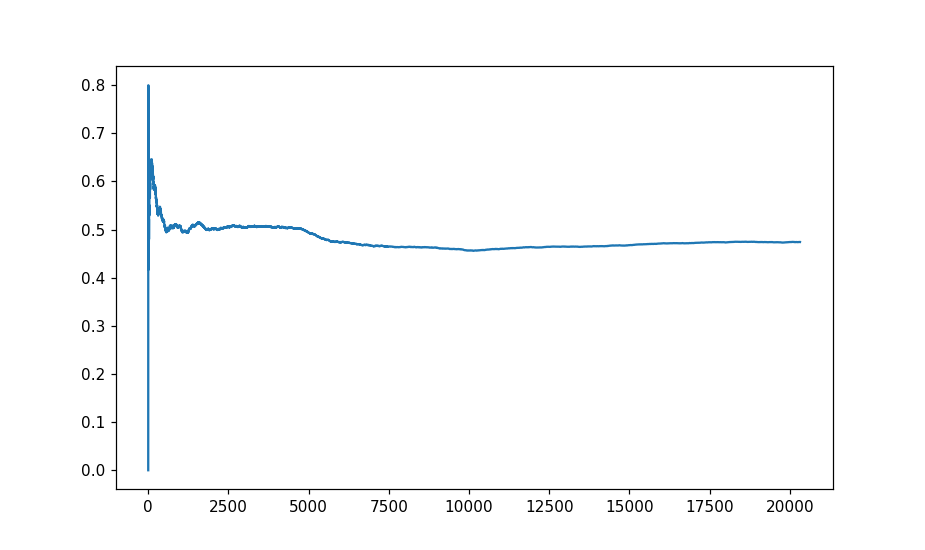

In [40]:
%matplotlib notebook
plt.plot(range(len(accuracy)),accuracy)
plt.show()

<img src="https://cdn-images-1.medium.com/max/800/1*UEFD6lJ7PKGNTt5yqtEXEA.png">